In [1]:
import math
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pyclustering.cluster.xmeans import xmeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

from utilities import plot_boxplot

In [2]:
from google.colab import drive

drive.mount('/content/drive')

DATA_PATH = '/content/drive/MyDrive/'

ModuleNotFoundError: No module named 'google.colab'

In [3]:
DATA_PATH = 'G:/Shared drives/DM_tweets/data/'

In [ ]:
DATA_PATH = 'G:/Drive condivisi/DM_tweets/data/'

In [4]:
df_indicators = pd.read_csv(DATA_PATH + 'indicators_clean.csv', sep='#')
#df_tweets_ind = pd.read_csv(DATA_PATH+'tweets_with_indicators.csv', sep='#')
df_users = pd.read_csv(DATA_PATH + 'users_clean.csv', sep='#')

In [5]:
def get_metrics(data_scaled, labels, print_out=True):
    silohuette = metrics.silhouette_score(data_scaled, labels)
    DBscore = metrics.davies_bouldin_score(data_scaled, labels)
    if print_out:
        print(f"Silouhette score: {silohuette}")  # [-1, 1] Good when near 1
        print(f"Davies Bouldin score: {DBscore}")  # Good when near 0
    else:
        return silohuette, DBscore


In [6]:
def scatterplot(df, attr1, attr2, c_labels, centroids=None, filename=None, filter=None, xticks=None, yticks=None):
    #cent = scaler.inverse_transform(kmeans.cluster_centers_)
    plt.scatter(df[attr1], df[attr2], c=c_labels)

    if filter:
        df = df.loc[filter]
        c_labels = c_labels[filter]

    if centroids is not None:
        plt.scatter(centroids[:, 0], centroids[:, 1], s=100, marker='.', c='r')

    if xticks is not None:
        plt.xticks(xticks)
    if yticks is not None:
        plt.yticks(yticks)

    plt.tick_params(axis='both', which='major')

    plt.savefig(filename)


In [7]:
def plots(df, labels, path=None, centroids=None, attributes=None):
  if attributes is None:
    attributes = df.columns

  try:
      os.mkdir(path)
  except FileExistsError:
      pass
  
  # Line plot
  plt.figure(figsize=(50, 5))
  for label in np.unique(labels):
    if centroids is None:
      cent = df[attributes][labels == label].median()
    else:   
      cent = centroids[label]
    plt.plot(cent, label="Cluster %s" % label)
  plt.tick_params(axis='both', which='major')
  plt.xticks(range(0, len(df[attributes].columns)), df[attributes].columns)
  plt.legend()
  if path is not None:
    plt.savefig(path + "/landscape.png")
  else:
      plt.show()

  # Radar plot
  N = len(attributes)

  plt.figure(figsize=(8, 8))
  for label in np.unique(labels):
      angles = [n / float(N) * 2 * math.pi for n in range(N)]
      if centroids is None:
        values = df[attributes].loc[np.where(labels == label)].median().tolist()
      else:
        values = centroids[label].tolist()
      values += values[:1]
      angles += angles[:1]

      ax = plt.subplot(polar=True)
      plt.xticks(angles[:-1], attributes)
      ax.plot(angles, values, linewidth=2)
      ax.fill(angles, values, 'b', alpha=0.1)

  plt.savefig(path + "/radar.png")

  # Plot w.r.t. languages
  lang_ct = pd.crosstab(labels, df['lang'])

  fig, ax = plt.subplots(figsize=(46, 15))
  lang_ct.plot(kind='bar', stacked=False, ax=ax)
  plt.xlabel('Cluster')
  plt.ylabel('lang')
  plt.yscale('log')
  plt.legend(prop={'size': 15})
  plt.savefig(path + "/lang_characterization.png")

  # Plot w.r.t. bots
  bot_ct = pd.crosstab(labels, df['bot'])

  fig, ax = plt.subplots(figsize=(46, 15))  # Sample figsize in inches
  #plt.figure(figsize=(10,25))
  bot_ct.plot(kind='bar', stacked=False, ax=ax)
  plt.xlabel('Cluster')
  plt.ylabel('bot')
  plt.legend(prop={'size': 30})
  plt.savefig(path + "/bot_characterization.png")


In [8]:
df_indicators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140543 entries, 0 to 140542
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   user_id              140543 non-null  object 
 1   2012_tweets          140543 non-null  int64  
 2   2013_tweets          140543 non-null  int64  
 3   2014_tweets          140543 non-null  int64  
 4   2015_tweets          140543 non-null  int64  
 5   2016_tweets          140543 non-null  int64  
 6   2017_tweets          140543 non-null  int64  
 7   2018_tweets          140543 non-null  int64  
 8   2019_tweets          140543 non-null  int64  
 9   2020_tweets          140543 non-null  int64  
 10  mean_length          140543 non-null  float64
 11  retweets_count_mean  140543 non-null  float64
 12  retweets_count_std   13781 non-null   float64
 13  reply_count_mean     140543 non-null  float64
 14  favorite_count_mean  140543 non-null  float64
 15  num_hashtags_mean

In [9]:
df_users.id = df_users.id.astype(str)
df_merge = df_users.merge(df_indicators, left_on='id', right_on='user_id', how='left')

In [10]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 0 to 11507
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   11508 non-null  object 
 1   name                 11507 non-null  object 
 2   lang                 11508 non-null  object 
 3   bot                  11508 non-null  int64  
 4   created_at           11508 non-null  object 
 5   statuses_count       11508 non-null  float64
 6   created_at_conv      11508 non-null  int64  
 7   user_id              11504 non-null  object 
 8   2012_tweets          11504 non-null  float64
 9   2013_tweets          11504 non-null  float64
 10  2014_tweets          11504 non-null  float64
 11  2015_tweets          11504 non-null  float64
 12  2016_tweets          11504 non-null  float64
 13  2017_tweets          11504 non-null  float64
 14  2018_tweets          11504 non-null  float64
 15  2019_tweets          11504 non-null 

In [11]:
non_numeric_attributes = ['id', 'user_id', 'name', 'lang', 'created_at', 'bot']
numeric_attributes = [attr for attr in df_merge.columns if attr not in non_numeric_attributes]
#df_merge.drop(columns=[str(y)+'_tweets' for y in range(2012,2021)], inplace=True)

Drop categorical columns

In [12]:
# Replace NaN values in variance with 0 
# (NaN values are given when the user only has one tweet so it is safe to assume variance can be 0)
df_merge_numeric = df_merge[numeric_attributes].fillna(value=0)
#df_merge.drop(columns=['created_at_conv', 'created_at_mean'], inplace=True)

# Normalization of values

In [13]:
def to_log(df, attr):
    series = pd.Series(np.log(df[attr].values))
    series = series.replace(-np.inf, 0)
    series = series.fillna(value=0)
    return series

It is possible to see that our data has very different ranges of values for different attributes going from ranges from 0 to hundreds and from 0 to hundred thousands. This means that it would be best to normalize the values either in a range [0, 1] or in logscale.

C:\Users\al\AppData\Local\Temp\ipykernel_9064\98376669.py:2: RuntimeWarning: divide by zero encountered in log
  series = pd.Series(np.log(df[attr].values))


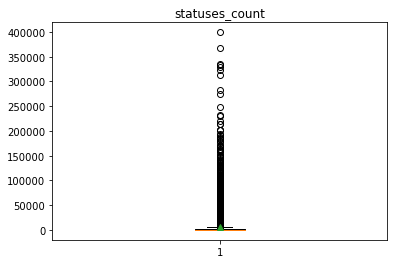

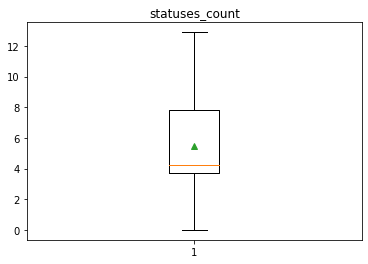

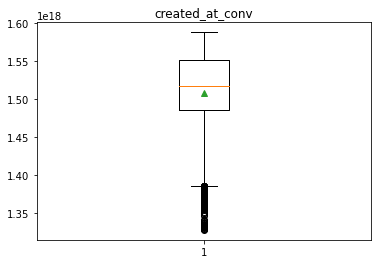

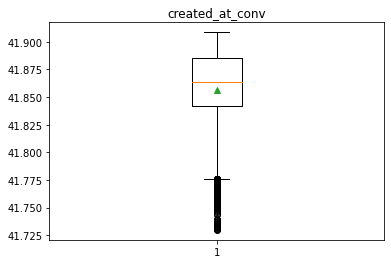

C:\Users\al\AppData\Local\Temp\ipykernel_9064\98376669.py:2: RuntimeWarning: divide by zero encountered in log
  series = pd.Series(np.log(df[attr].values))


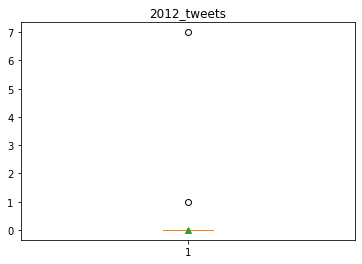

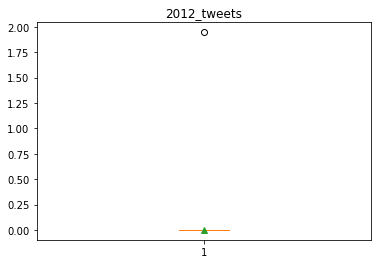

C:\Users\al\AppData\Local\Temp\ipykernel_9064\98376669.py:2: RuntimeWarning: divide by zero encountered in log
  series = pd.Series(np.log(df[attr].values))


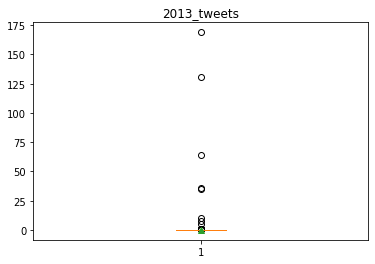

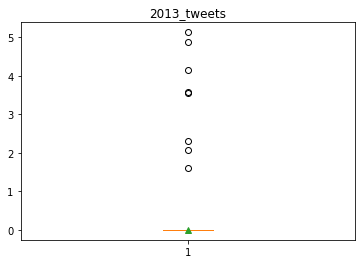

C:\Users\al\AppData\Local\Temp\ipykernel_9064\98376669.py:2: RuntimeWarning: divide by zero encountered in log
  series = pd.Series(np.log(df[attr].values))


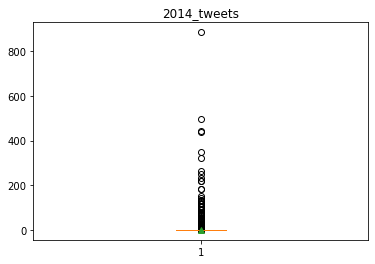

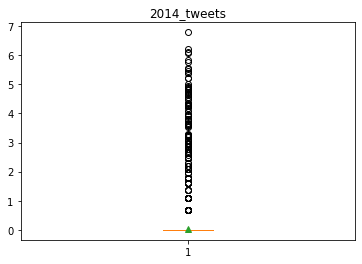

C:\Users\al\AppData\Local\Temp\ipykernel_9064\98376669.py:2: RuntimeWarning: divide by zero encountered in log
  series = pd.Series(np.log(df[attr].values))


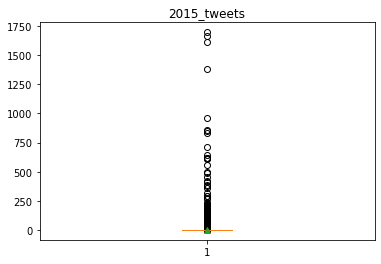

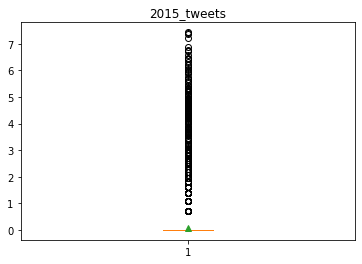

C:\Users\al\AppData\Local\Temp\ipykernel_9064\98376669.py:2: RuntimeWarning: divide by zero encountered in log
  series = pd.Series(np.log(df[attr].values))


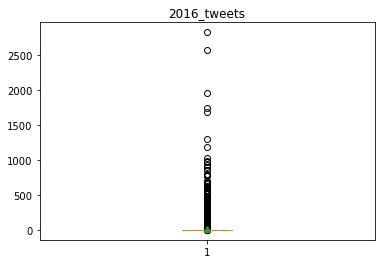

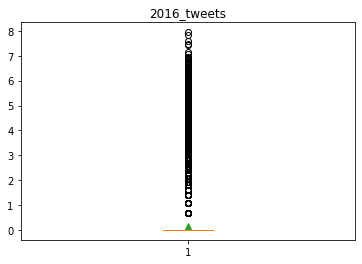

C:\Users\al\AppData\Local\Temp\ipykernel_9064\98376669.py:2: RuntimeWarning: divide by zero encountered in log
  series = pd.Series(np.log(df[attr].values))


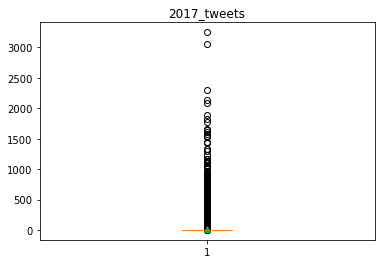

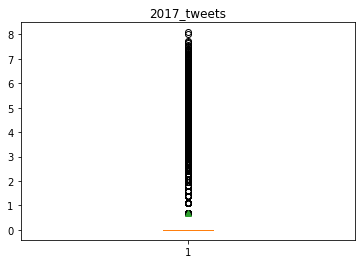

C:\Users\al\AppData\Local\Temp\ipykernel_9064\98376669.py:2: RuntimeWarning: divide by zero encountered in log
  series = pd.Series(np.log(df[attr].values))


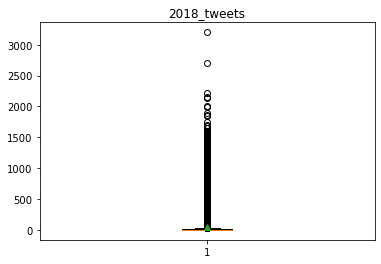

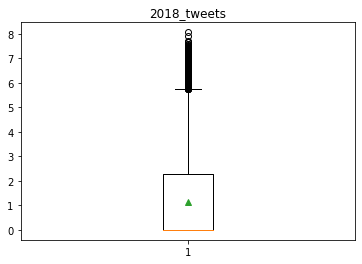

C:\Users\al\AppData\Local\Temp\ipykernel_9064\98376669.py:2: RuntimeWarning: divide by zero encountered in log
  series = pd.Series(np.log(df[attr].values))


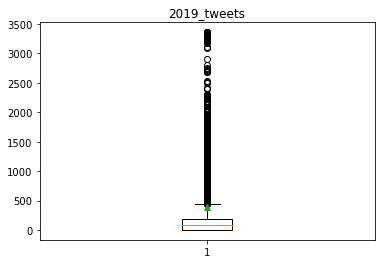

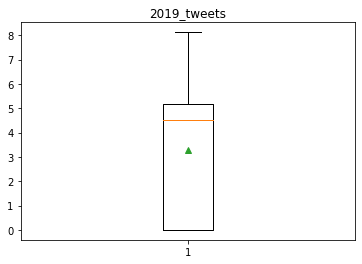

C:\Users\al\AppData\Local\Temp\ipykernel_9064\98376669.py:2: RuntimeWarning: divide by zero encountered in log
  series = pd.Series(np.log(df[attr].values))


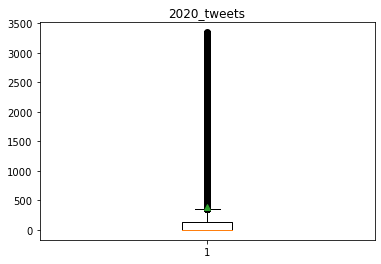

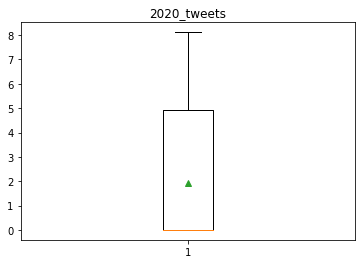

C:\Users\al\AppData\Local\Temp\ipykernel_9064\98376669.py:2: RuntimeWarning: divide by zero encountered in log
  series = pd.Series(np.log(df[attr].values))


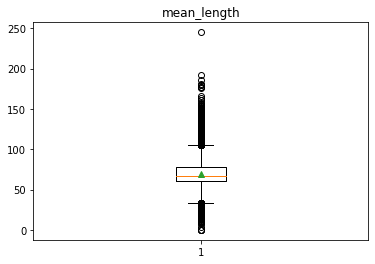

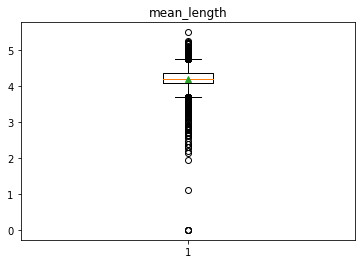

C:\Users\al\AppData\Local\Temp\ipykernel_9064\98376669.py:2: RuntimeWarning: divide by zero encountered in log
  series = pd.Series(np.log(df[attr].values))


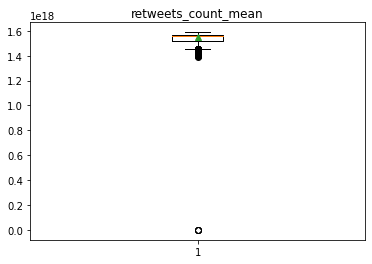

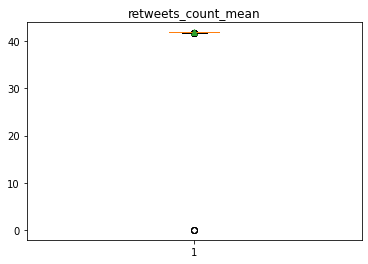

C:\Users\al\AppData\Local\Temp\ipykernel_9064\98376669.py:2: RuntimeWarning: divide by zero encountered in log
  series = pd.Series(np.log(df[attr].values))


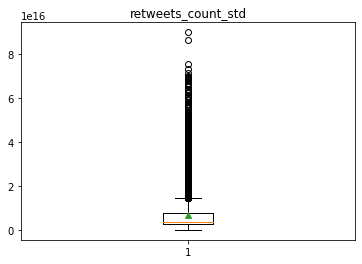

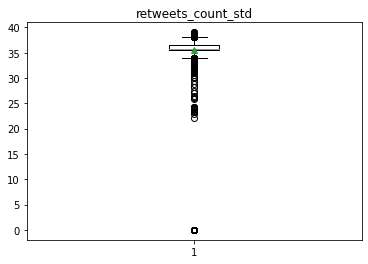

C:\Users\al\AppData\Local\Temp\ipykernel_9064\98376669.py:2: RuntimeWarning: divide by zero encountered in log
  series = pd.Series(np.log(df[attr].values))


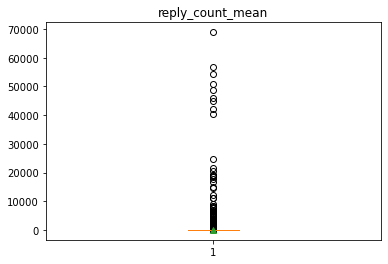

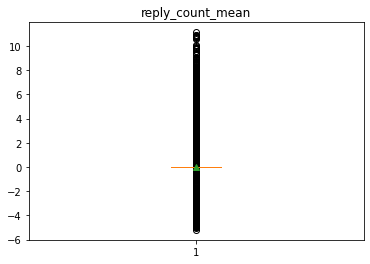

C:\Users\al\AppData\Local\Temp\ipykernel_9064\98376669.py:2: RuntimeWarning: divide by zero encountered in log
  series = pd.Series(np.log(df[attr].values))


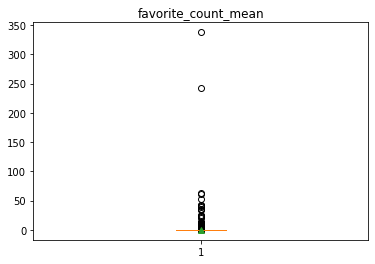

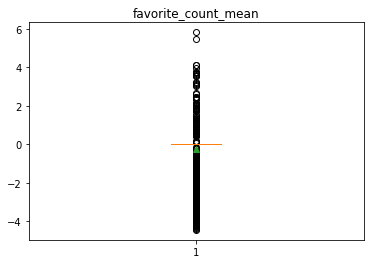

C:\Users\al\AppData\Local\Temp\ipykernel_9064\98376669.py:2: RuntimeWarning: divide by zero encountered in log
  series = pd.Series(np.log(df[attr].values))


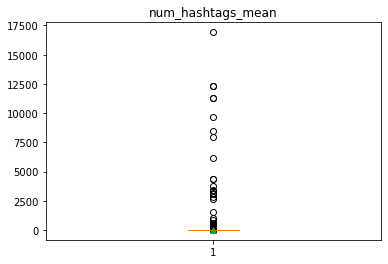

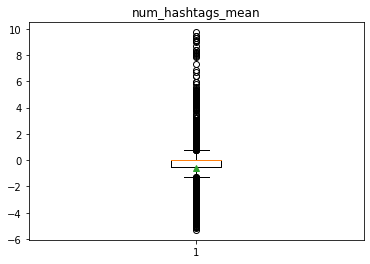

C:\Users\al\AppData\Local\Temp\ipykernel_9064\98376669.py:2: RuntimeWarning: divide by zero encountered in log
  series = pd.Series(np.log(df[attr].values))


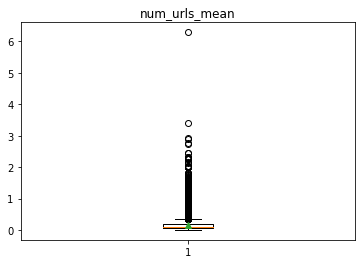

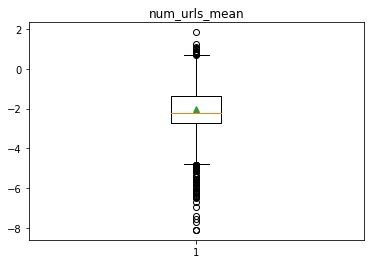

C:\Users\al\AppData\Local\Temp\ipykernel_9064\98376669.py:2: RuntimeWarning: divide by zero encountered in log
  series = pd.Series(np.log(df[attr].values))


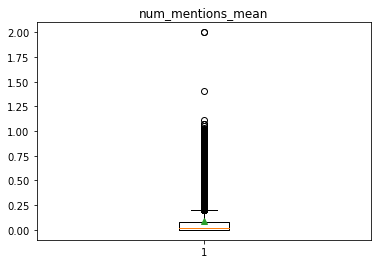

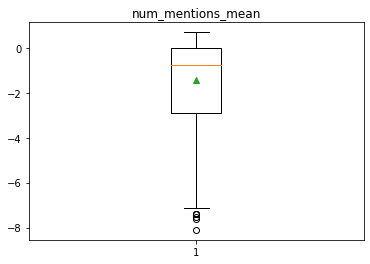

C:\Users\al\AppData\Local\Temp\ipykernel_9064\98376669.py:2: RuntimeWarning: divide by zero encountered in log
  series = pd.Series(np.log(df[attr].values))


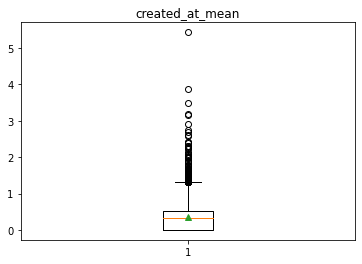

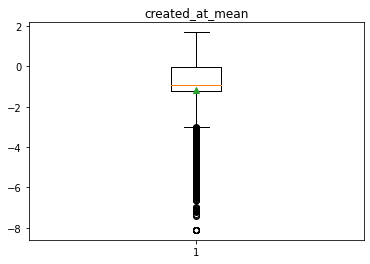

C:\Users\al\AppData\Local\Temp\ipykernel_9064\98376669.py:2: RuntimeWarning: divide by zero encountered in log
  series = pd.Series(np.log(df[attr].values))


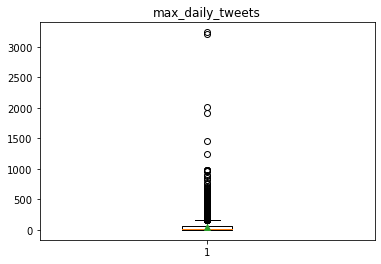

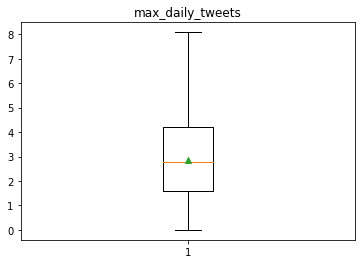

C:\Users\al\AppData\Local\Temp\ipykernel_9064\98376669.py:2: RuntimeWarning: divide by zero encountered in log
  series = pd.Series(np.log(df[attr].values))


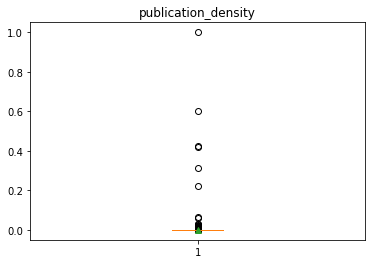

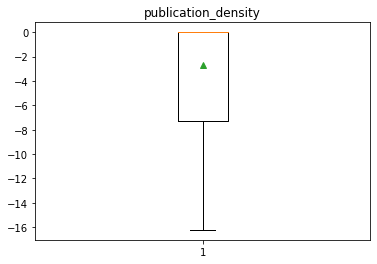

In [14]:
from prettytable import PrettyTable

table = PrettyTable(field_names=['attr', 'min', 'max', 'log_min','log_max'])
df_merge_log = pd.DataFrame()
for attr in numeric_attributes:
    df_merge_log[attr] = to_log(df_merge_numeric, attr)
    table.add_row([attr, df_merge_numeric[attr].min(), df_merge_numeric[attr].max(), df_merge_log[attr].min(), df_merge_log[attr].max()])
    plot_boxplot(df_merge_numeric, attr)
    plot_boxplot(df_merge_log, attr)

In [28]:
print(table)

+---------------------+---------------------+------------------------+---------------------+--------------------+
|         attr        |         min         |          max           |       log_min       |      log_max       |
+---------------------+---------------------+------------------------+---------------------+--------------------+
|    statuses_count   |         0.0         |        399555.0        |         0.0         | 12.898106706802647 |
|   created_at_conv   | 1327370258000000000 |  1587454111000000000   |  41.72973140916386  | 41.90866321880304  |
|     2012_tweets     |         0.0         |          7.0           |         0.0         | 1.9459101490553132 |
|     2013_tweets     |         0.0         |         169.0          |         0.0         | 5.1298987149230735 |
|     2014_tweets     |         0.0         |         885.0          |         0.0         | 6.785587645007929  |
|     2015_tweets     |         0.0         |         1697.0         |         0.0      

For num_urls_mean, num_mentions_mean,

In [35]:
# Normalizzare i valori in log
scaler = MinMaxScaler()
scaler.fit(df_merge_log.values)
df_merge_scaled = scaler.transform(df_merge_log.values)

In [36]:
df_merge_scaled = pd.DataFrame(df_merge_scaled, columns=df_merge_log.columns)
df_merge_scaled[non_numeric_attributes] = df_merge[non_numeric_attributes]

In [37]:
df_merge_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   statuses_count       11508 non-null  float64
 1   created_at_conv      11508 non-null  float64
 2   2012_tweets          11508 non-null  float64
 3   2013_tweets          11508 non-null  float64
 4   2014_tweets          11508 non-null  float64
 5   2015_tweets          11508 non-null  float64
 6   2016_tweets          11508 non-null  float64
 7   2017_tweets          11508 non-null  float64
 8   2018_tweets          11508 non-null  float64
 9   2019_tweets          11508 non-null  float64
 10  2020_tweets          11508 non-null  float64
 11  mean_length          11508 non-null  float64
 12  retweets_count_mean  11508 non-null  float64
 13  retweets_count_std   11508 non-null  float64
 14  reply_count_mean     11508 non-null  float64
 15  favorite_count_mean  11508 non-null 

# DB Scan

In [38]:
dist = pdist(df_merge_scaled[numeric_attributes], 'euclidean')
dist_matrix = squareform(dist)

First we compute the distance matrix to choose the epsilon parameter.
We choose quite a high k since we have a considerably high amount of samples and high dimensionality

In [39]:
distances = list()
k = 20
for d in dist_matrix:
    index_kth_distance = np.argsort(d)[k]
    distances.append(d[index_kth_distance])

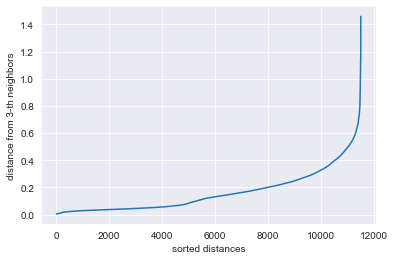

In [40]:
plt.plot(range(0, len(distances)), sorted(distances))
plt.ylabel('distance from %s-th neighbors' % 3)
plt.xlabel('sorted distances')

plt.savefig('dbscan/distances_curve.png')

The knee of the curve is around 0.3, so values around this point will be investigated. Interstingle, our curve bens in the 0.1 neighborhood, hence also this zone is worth investigating.

In [41]:
table = PrettyTable(field_names=['eps', 'silohuette', 'DB score', 'n clusters'])
for eps in [0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3, 0.325]:
    dbscan = DBSCAN(eps=eps, min_samples=42)
    clusters = dbscan.fit(df_merge_scaled[numeric_attributes])
    n_clusters = len(np.unique(clusters.labels_))
    silhouette, DBscore = get_metrics(df_merge_scaled[numeric_attributes], dbscan.labels_, print_out=False)
    table.add_row([eps, silhouette, DBscore, n_clusters])
print(table)

+-------+----------------------+--------------------+------------+
|  eps  |      silohuette      |      DB score      | n clusters |
+-------+----------------------+--------------------+------------+
| 0.075 | 0.08159689514003385  | 1.1618571666353026 |     12     |
|  0.1  | 0.028954194770931904 | 1.1219824407733967 |     12     |
| 0.125 |  0.0890672049370497  | 1.125525294991496  |     13     |
|  0.15 |  0.1877714981341073  | 1.192304471349886  |     17     |
| 0.175 |  0.257814745089147   | 1.2342269629440121 |     19     |
|  0.2  | 0.33544815398847144  | 1.2837639287547213 |     18     |
| 0.225 |  0.3558523370818563  | 1.2800714475343584 |     13     |
|  0.25 |  0.3804363673754632  | 1.315152940281892  |     12     |
| 0.275 |  0.4191083029512266  | 1.317754788419997  |     11     |
|  0.3  | 0.41545129592994107  | 1.2521401879980585 |     13     |
| 0.325 |  0.3894192545015634  | 1.3237684823144475 |     9      |
+-------+----------------------+--------------------+---------

The zone around 0.3 seems the more promising.

In [42]:
table = PrettyTable(field_names=['eps', 'silohuette', 'DB score', 'n clusters'])
for eps in [0.28, 0.29, 0.3, 0.31]:
    dbscan = DBSCAN(eps=eps, min_samples=42)
    clusters = dbscan.fit(df_merge_scaled[numeric_attributes])
    n_clusters = len(np.unique(clusters.labels_))
    silhouette, DBscore = get_metrics(df_merge_scaled[numeric_attributes], dbscan.labels_, print_out=False)
    table.add_row([eps, silhouette, DBscore, n_clusters])
print(table)

+------+---------------------+--------------------+------------+
| eps  |      silohuette     |      DB score      | n clusters |
+------+---------------------+--------------------+------------+
| 0.28 | 0.38708113164324115 | 1.3078924256547084 |     12     |
| 0.29 | 0.41224775268875646 | 1.2425175105840007 |     12     |
| 0.3  | 0.41545129592994107 | 1.2521401879980585 |     13     |
| 0.31 |  0.380283411590873  | 1.2771945879577482 |     11     |
+------+---------------------+--------------------+------------+


In [43]:
dbscan = DBSCAN(eps=0.29, min_samples=42)
clusters = dbscan.fit(df_merge_scaled[numeric_attributes])

In [44]:
try:
  os.mkdir('dbscan')
except:
  pass

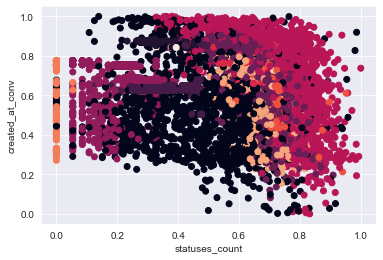

In [45]:
plt.ylabel('created_at_conv')
plt.xlabel('statuses_count')
scatterplot(df_merge_scaled, 'statuses_count', 'created_at_conv', clusters.labels_, filename="dbscan/scatter.png")

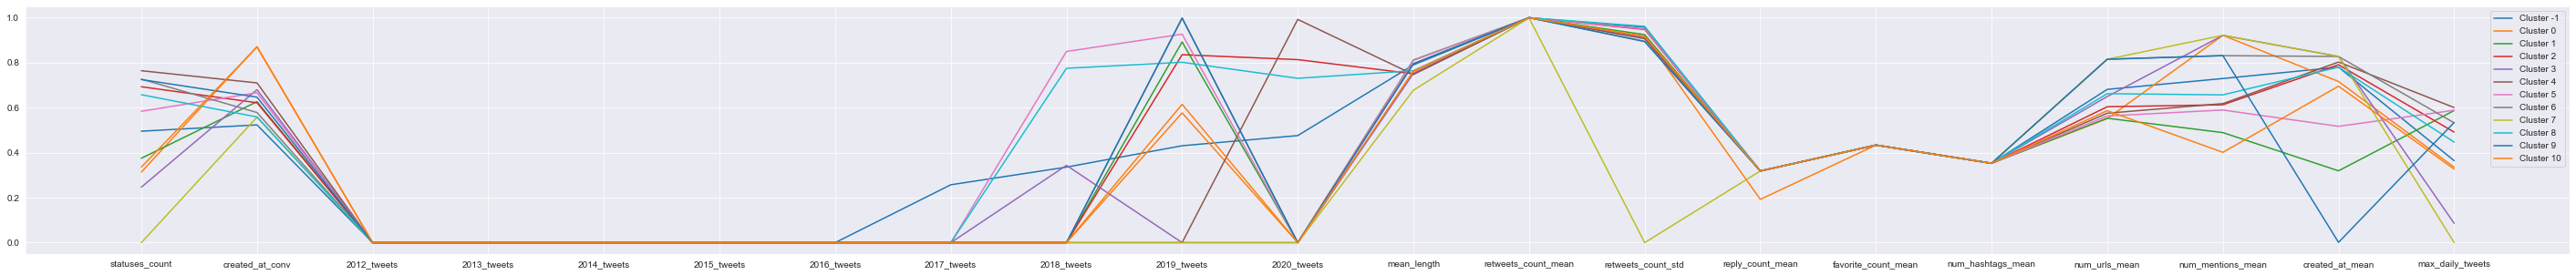

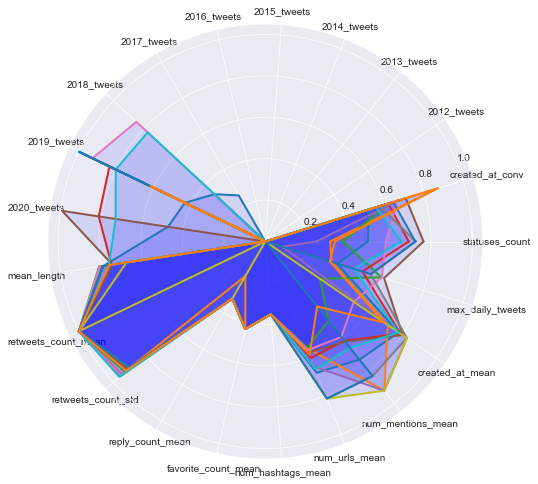

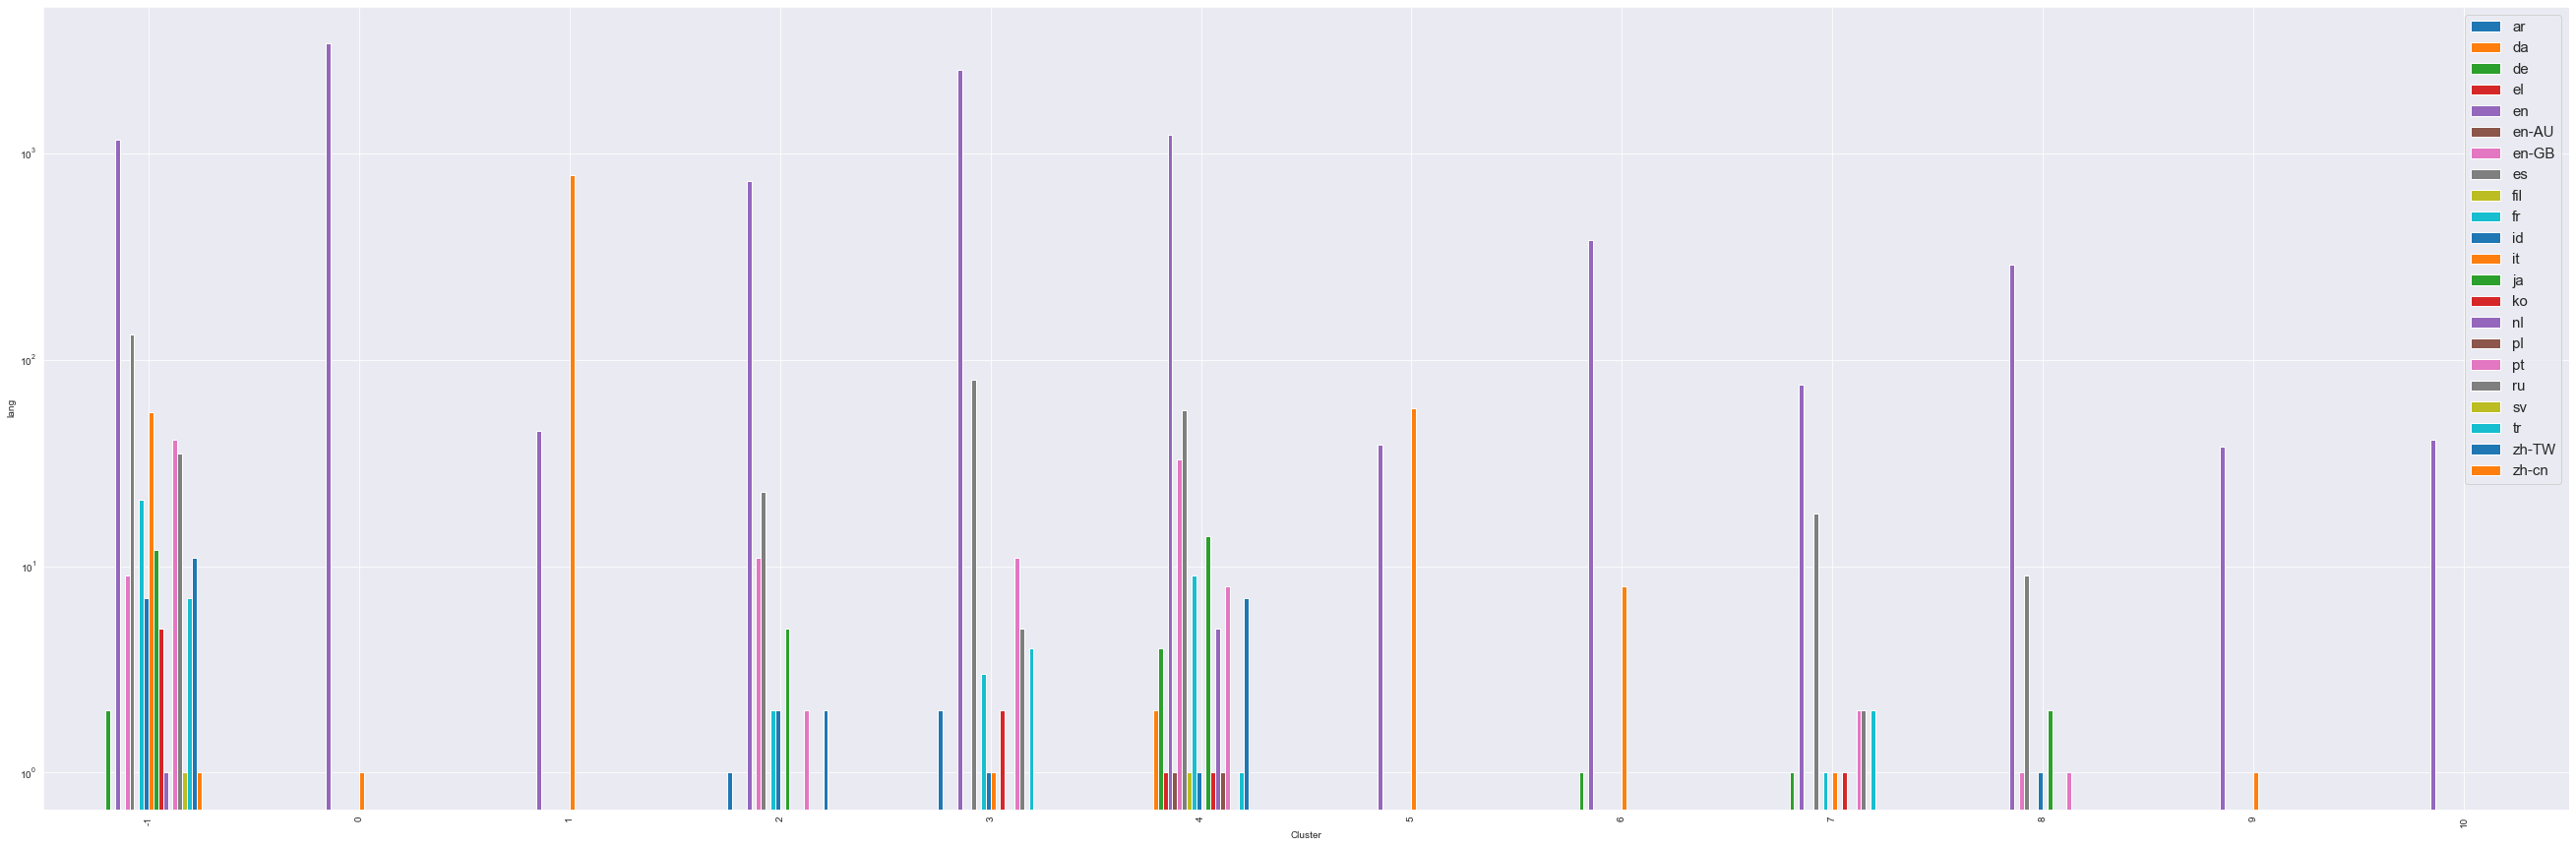

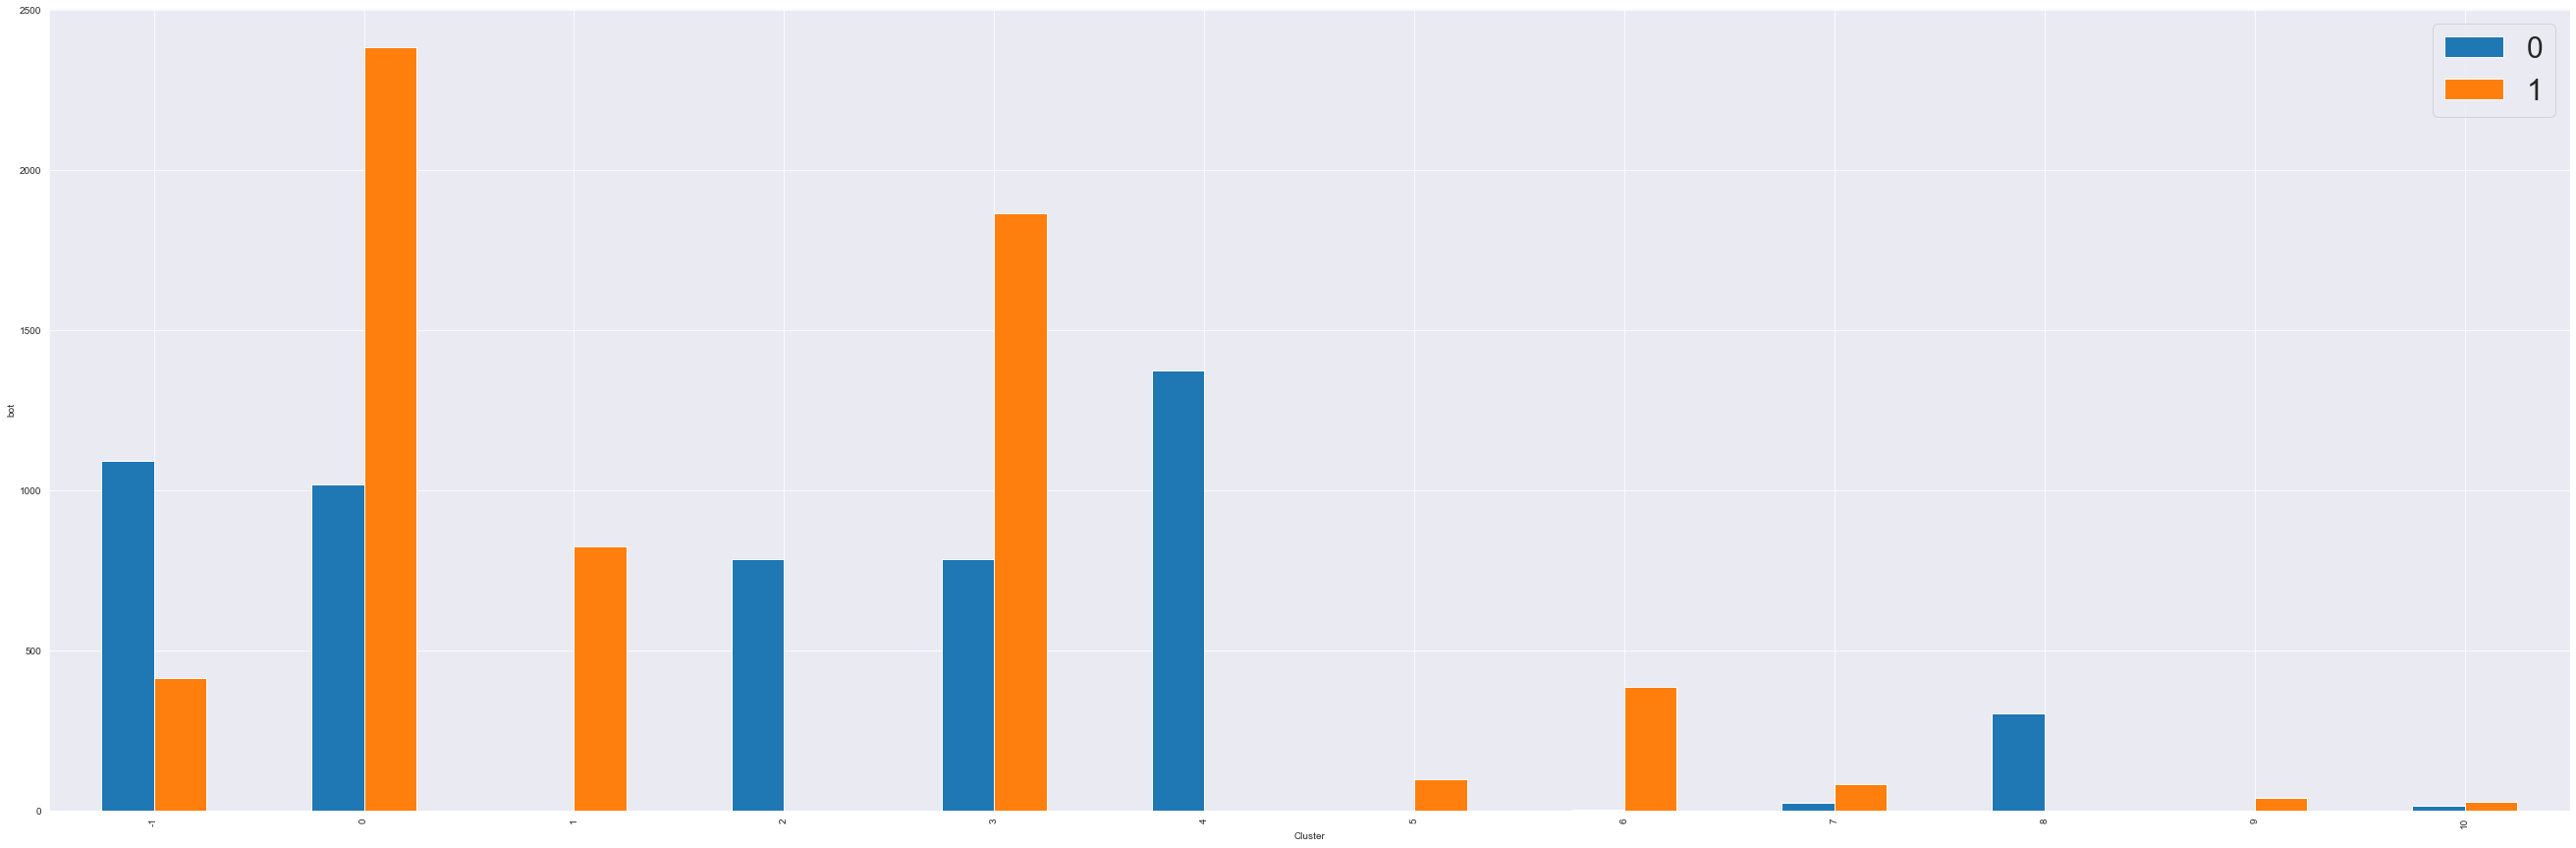

In [46]:
plots(df_merge_scaled, clusters.labels_, path="dbscan", attributes=numeric_attributes)

In [89]:
df_denoised = df_merge_scaled[clusters.labels_!=-1]

# KMeans

In [36]:
try:
  os.mkdir('kmeans')
except:
  pass

K means is run in two ways: with the complete set of users and removing the samples identified as noisy by DBscan

In [37]:
def find_optimal_k(df, max_k=40):
    sse_list = list()

    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300)
        kmeans.fit(df)
        sse_list.append(kmeans.inertia_)

    plt.plot(range(2, len(sse_list) + 2), sse_list)
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.show()

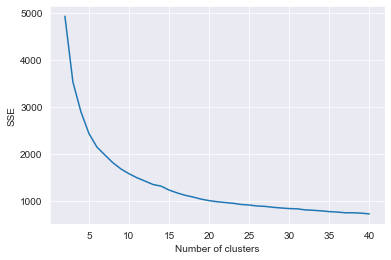

In [38]:
find_optimal_k(df_merge_scaled[numeric_attributes])

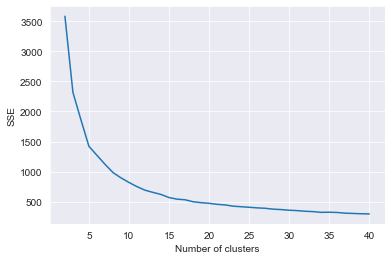

In [39]:
find_optimal_k(df_denoised[numeric_attributes])

The optimal number of clusters seems to be around 10.

In [167]:
def kmeans_analysis(df, k, n_init=20, max_iter=300, out_dir=None, combinations=False):
    try:
        os.mkdir(out_dir)
    except FileExistsError:
        pass

    kmeans = KMeans(n_clusters=k, n_init=n_init, max_iter=max_iter)
    kmeans.fit(df[numeric_attributes])
    cent = kmeans.cluster_centers_

    print(f'SSE:', kmeans.inertia_)
    print(f'mySSE:', sse(df[numeric_attributes], kmeans.labels_))
    get_metrics(df[numeric_attributes], kmeans.labels_)

    if combinations:
        try:
            os.mkdir(os.path.join(out_dir, 'combinations'))
        except FileExistsError:
            pass
        combs = combinations(df[numeric_attributes].columns, 2)
        os.mkdir('kmeans')
        os.mkdir('kmeans/log_denoised')
        for comb in combs:
            plt.ylabel(comb[1])
            plt.xlabel(comb[0])
            print(*comb)
            scatterplot(df, *comb, kmeans.labels_, centroids=cent,
                        filename=os.path.join(out_dir, 'combinations', f"scatterplot_{comb[1]}_{comb[0]}.png"))
    else:
        scatterplot(df, 'created_at_conv', 'statuses_count', kmeans.labels_,
                    centroids=cent, filename=os.path.join(out_dir, "clusters"))

    plots(df, kmeans.labels_, path = out_dir, centroids = cent, attributes=numeric_attributes)

SSE: 1582.0191240051968
14181.805176935562
9254.198921694602
13634.693759544396
11012.775622526642
16690.43255725895
18054.0575254192
14172.36530201292
12455.385040810295
15054.814988073493
24132.788526753226
mySSE: 148643.3174210293
Silouhette score: 0.47100891448425497
Davies Bouldin score: 1.1331444914241595


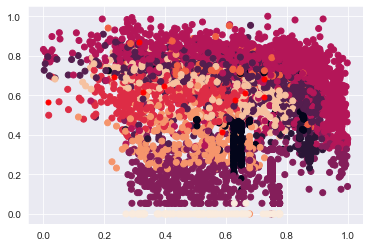

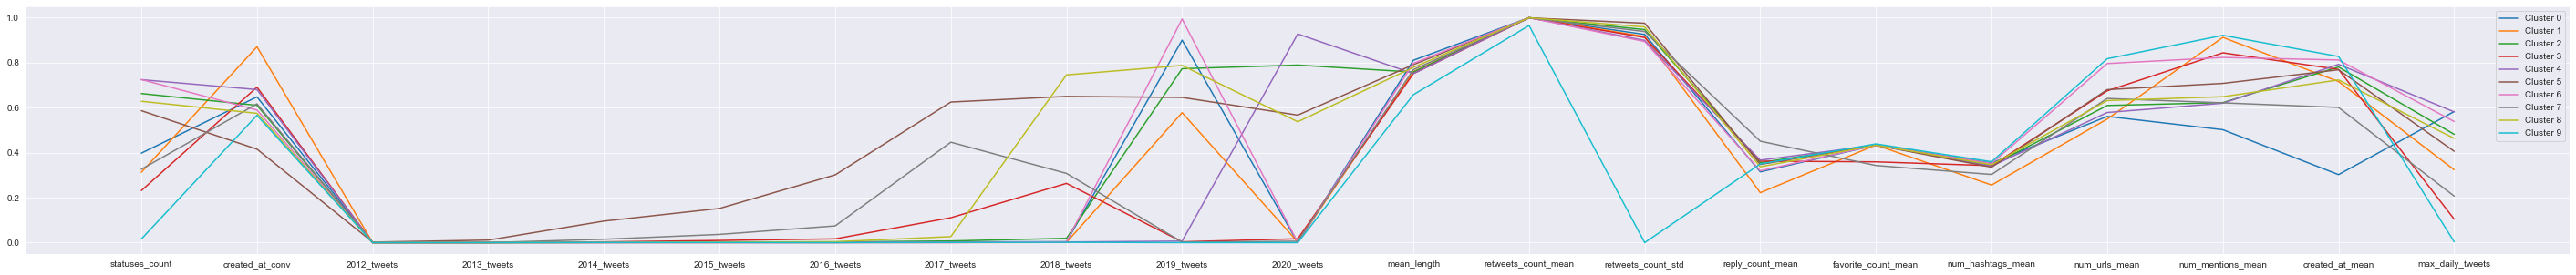

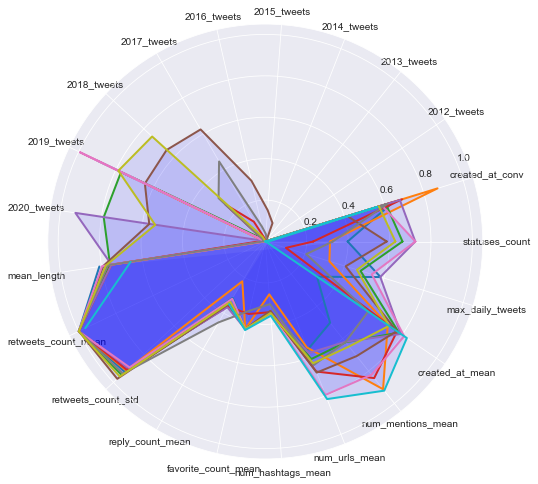

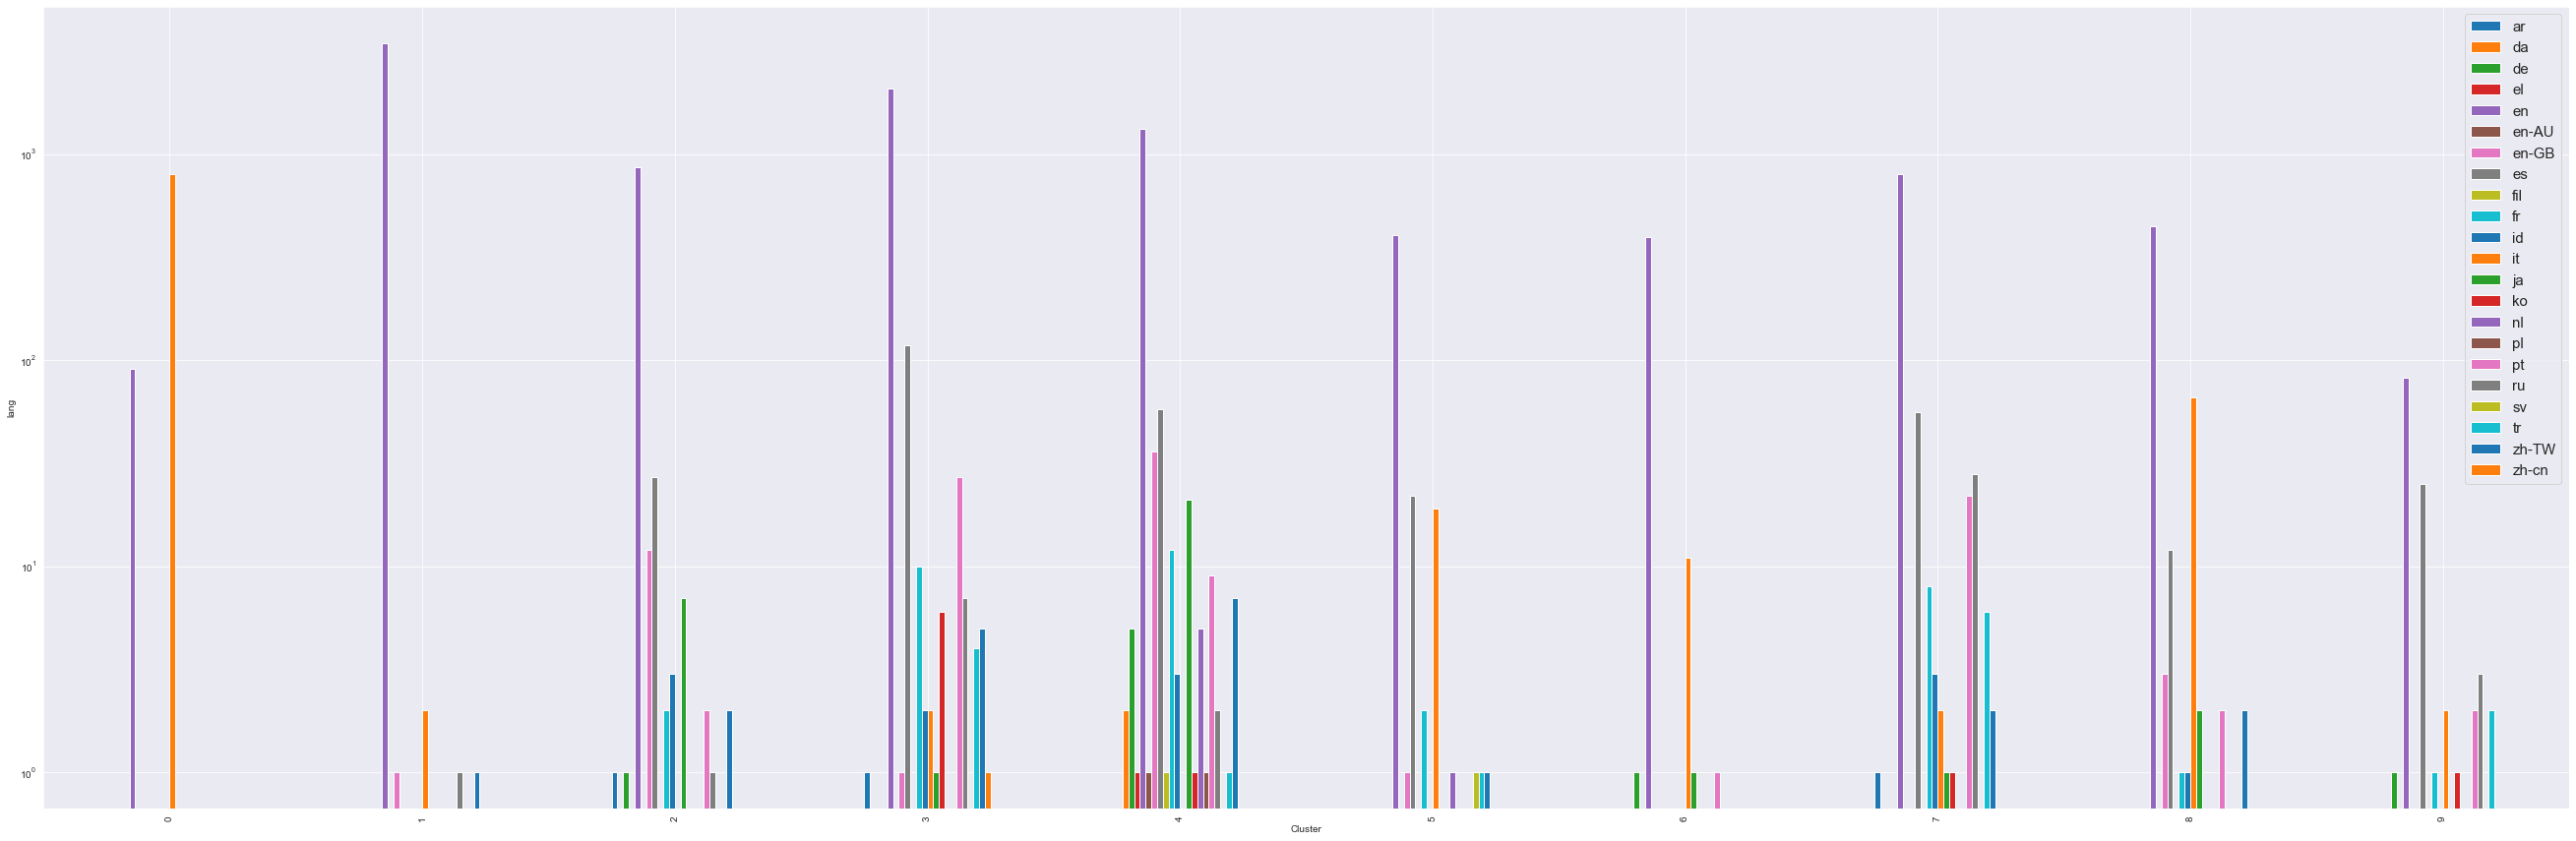

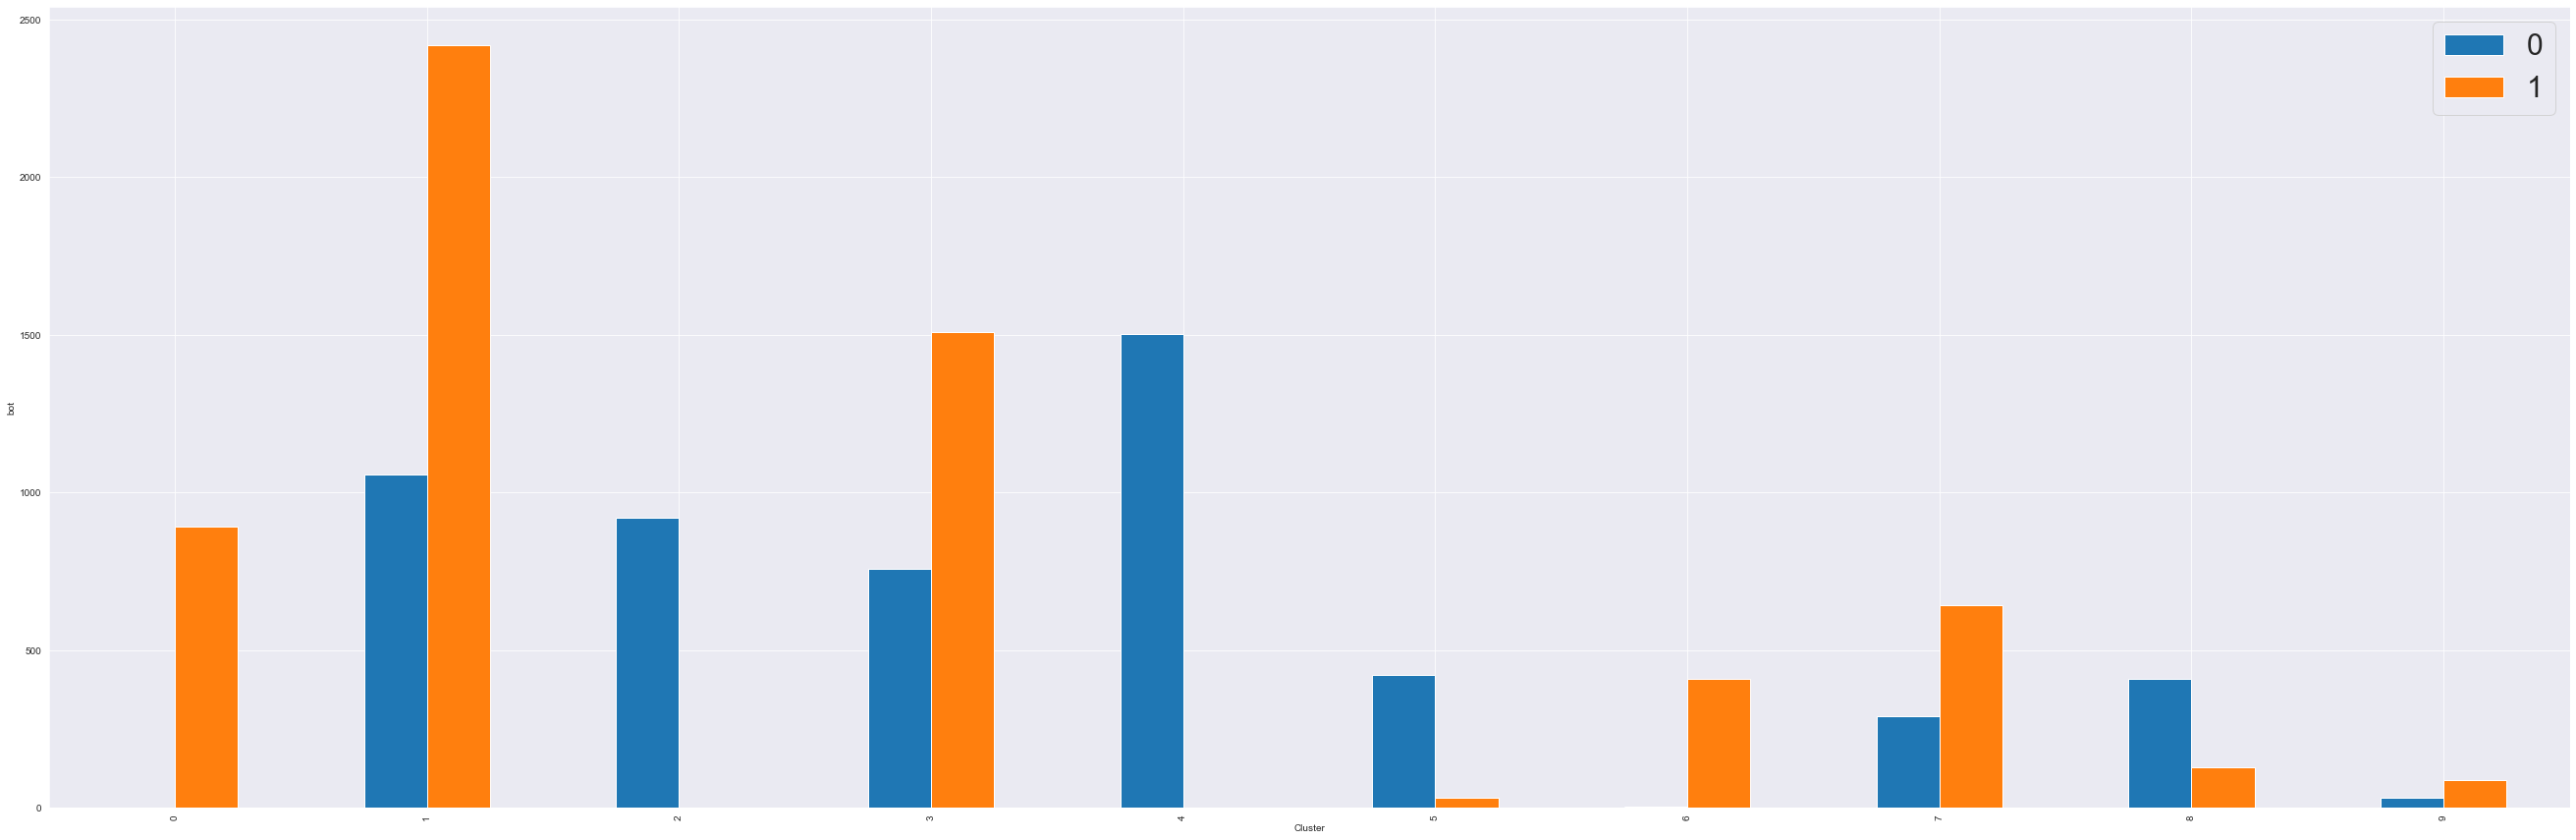

In [168]:
kmeans_analysis(df_merge_scaled, k=10, out_dir='kmeans/scaled_k10')

SSE: 1122.7596261398367
Silouhette score: 0.5122081730297648
Davies Bouldin score: 1.0242155378699824


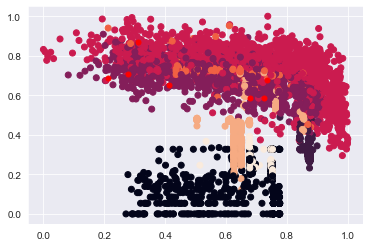

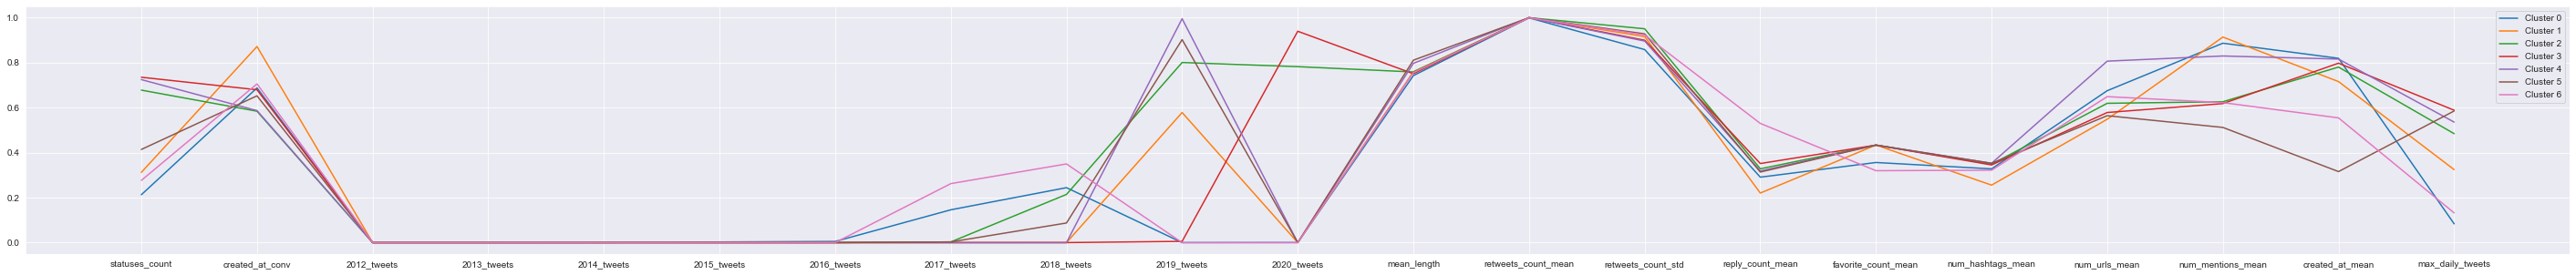

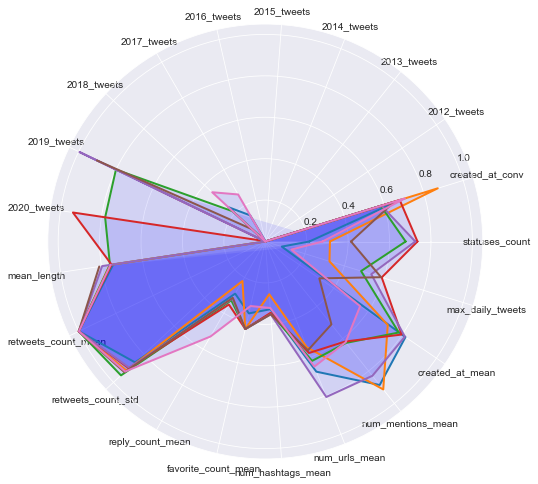

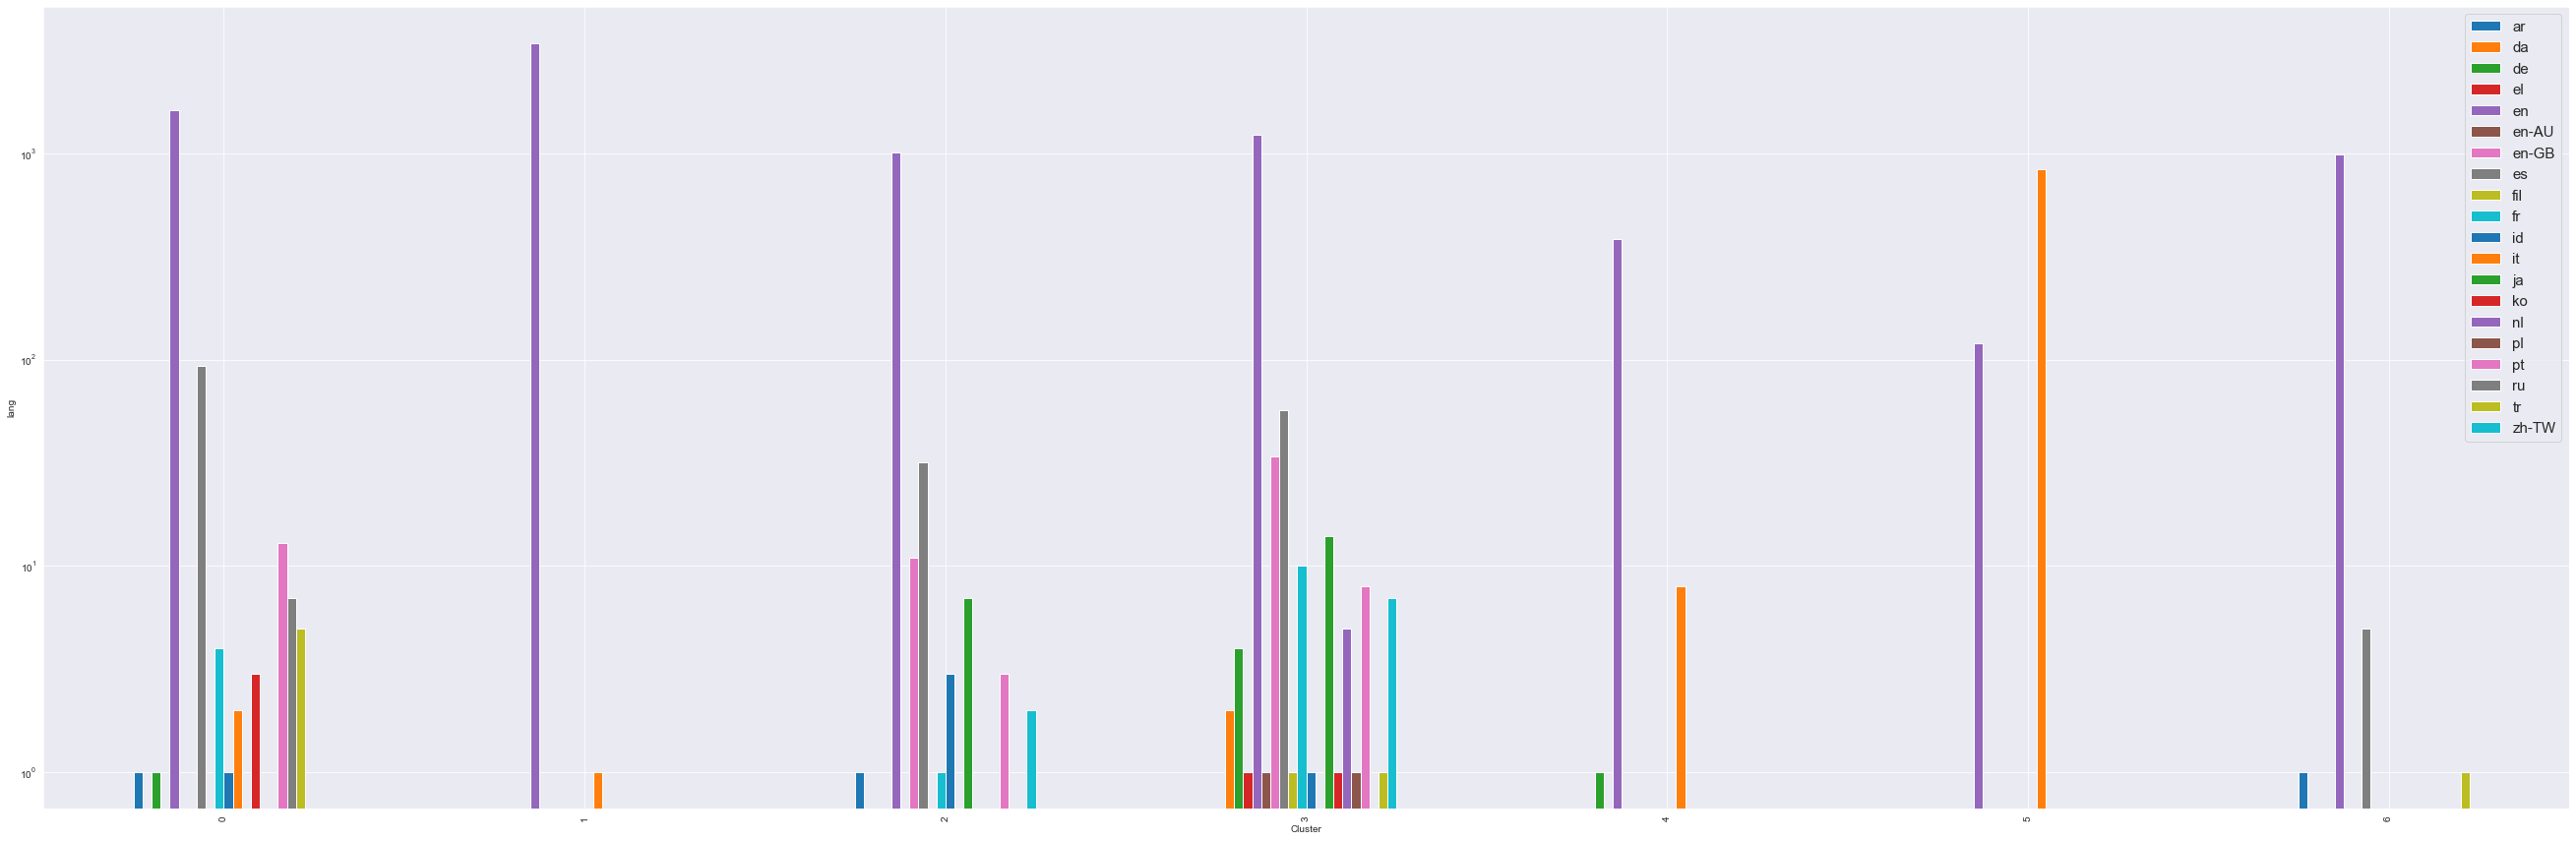

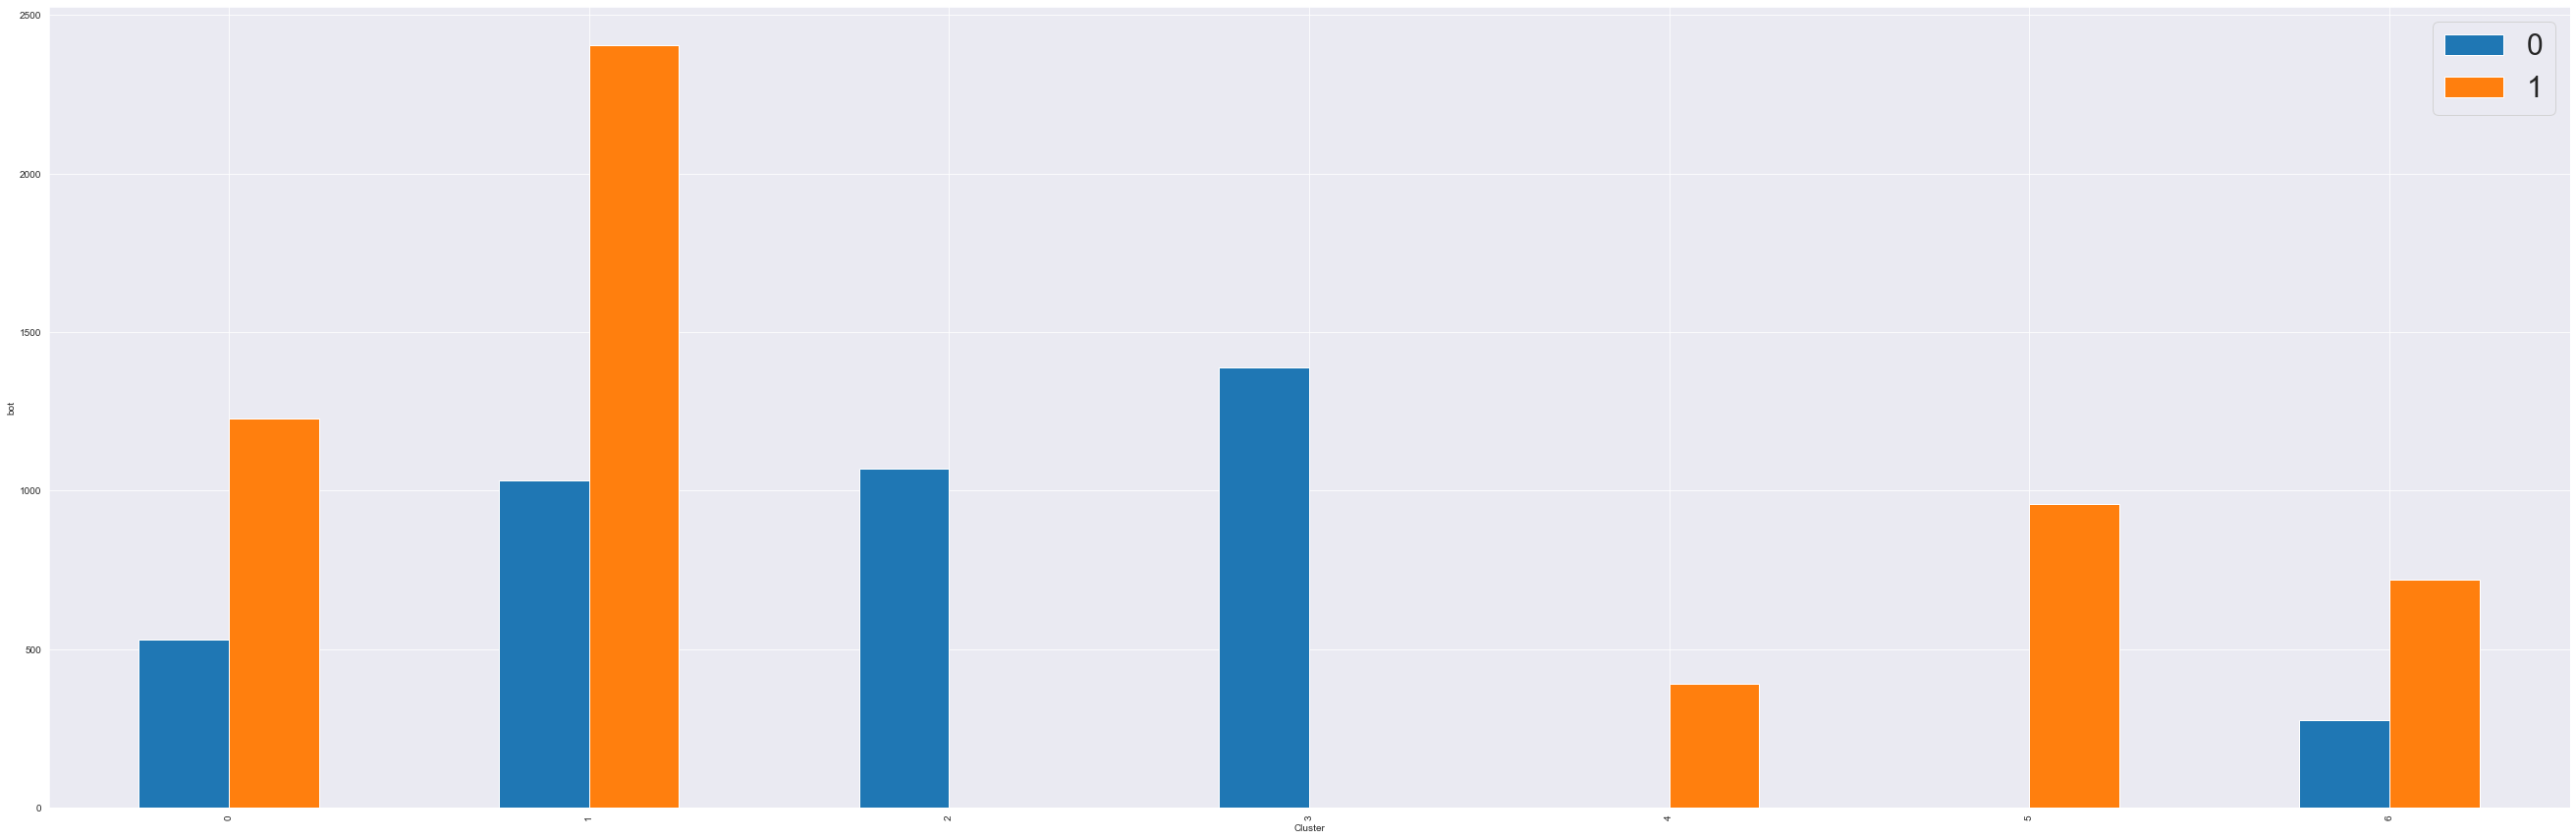

In [42]:
kmeans_analysis(df_denoised, k=7, out_dir='kmeans/denoised_k7')

SSE: 979.9203324064931
Silouhette score: 0.5265355737877931
Davies Bouldin score: 0.9629460508378526


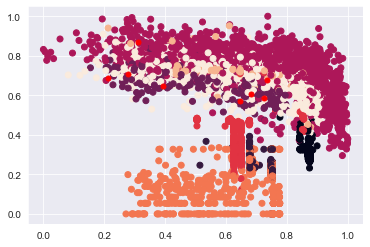

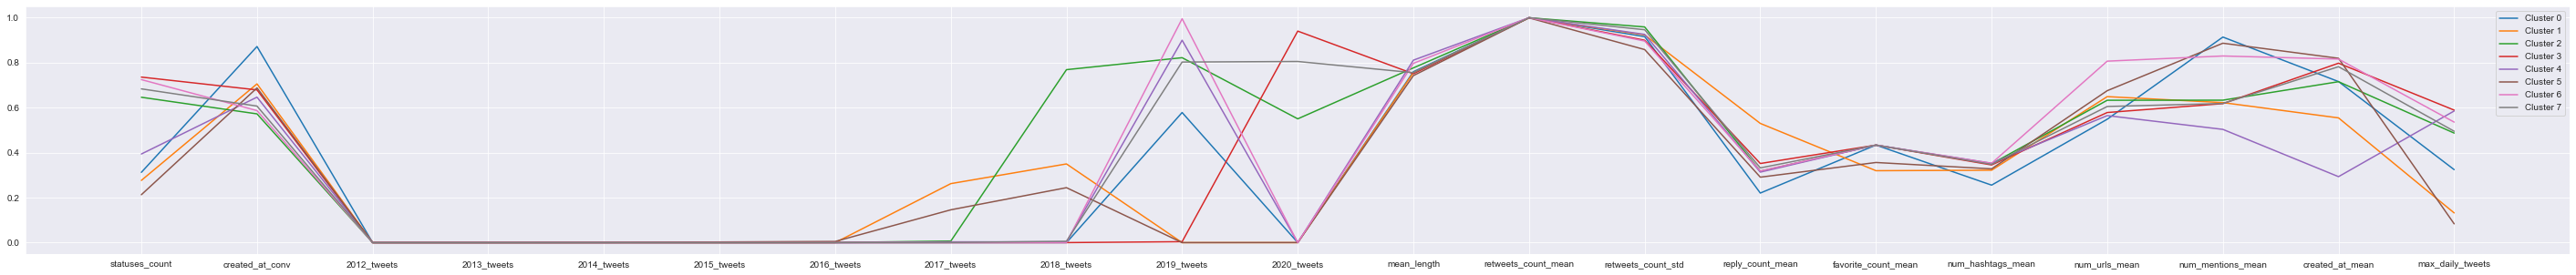

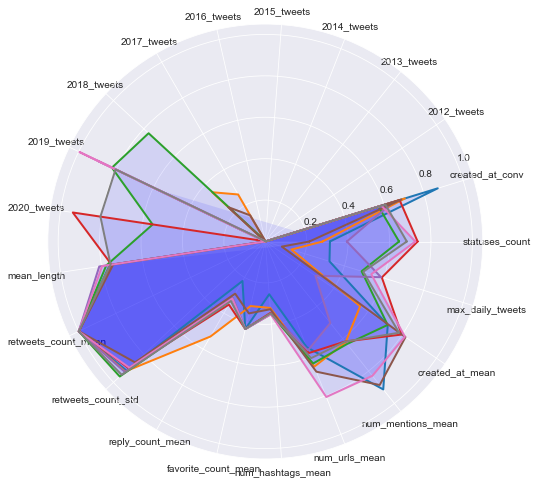

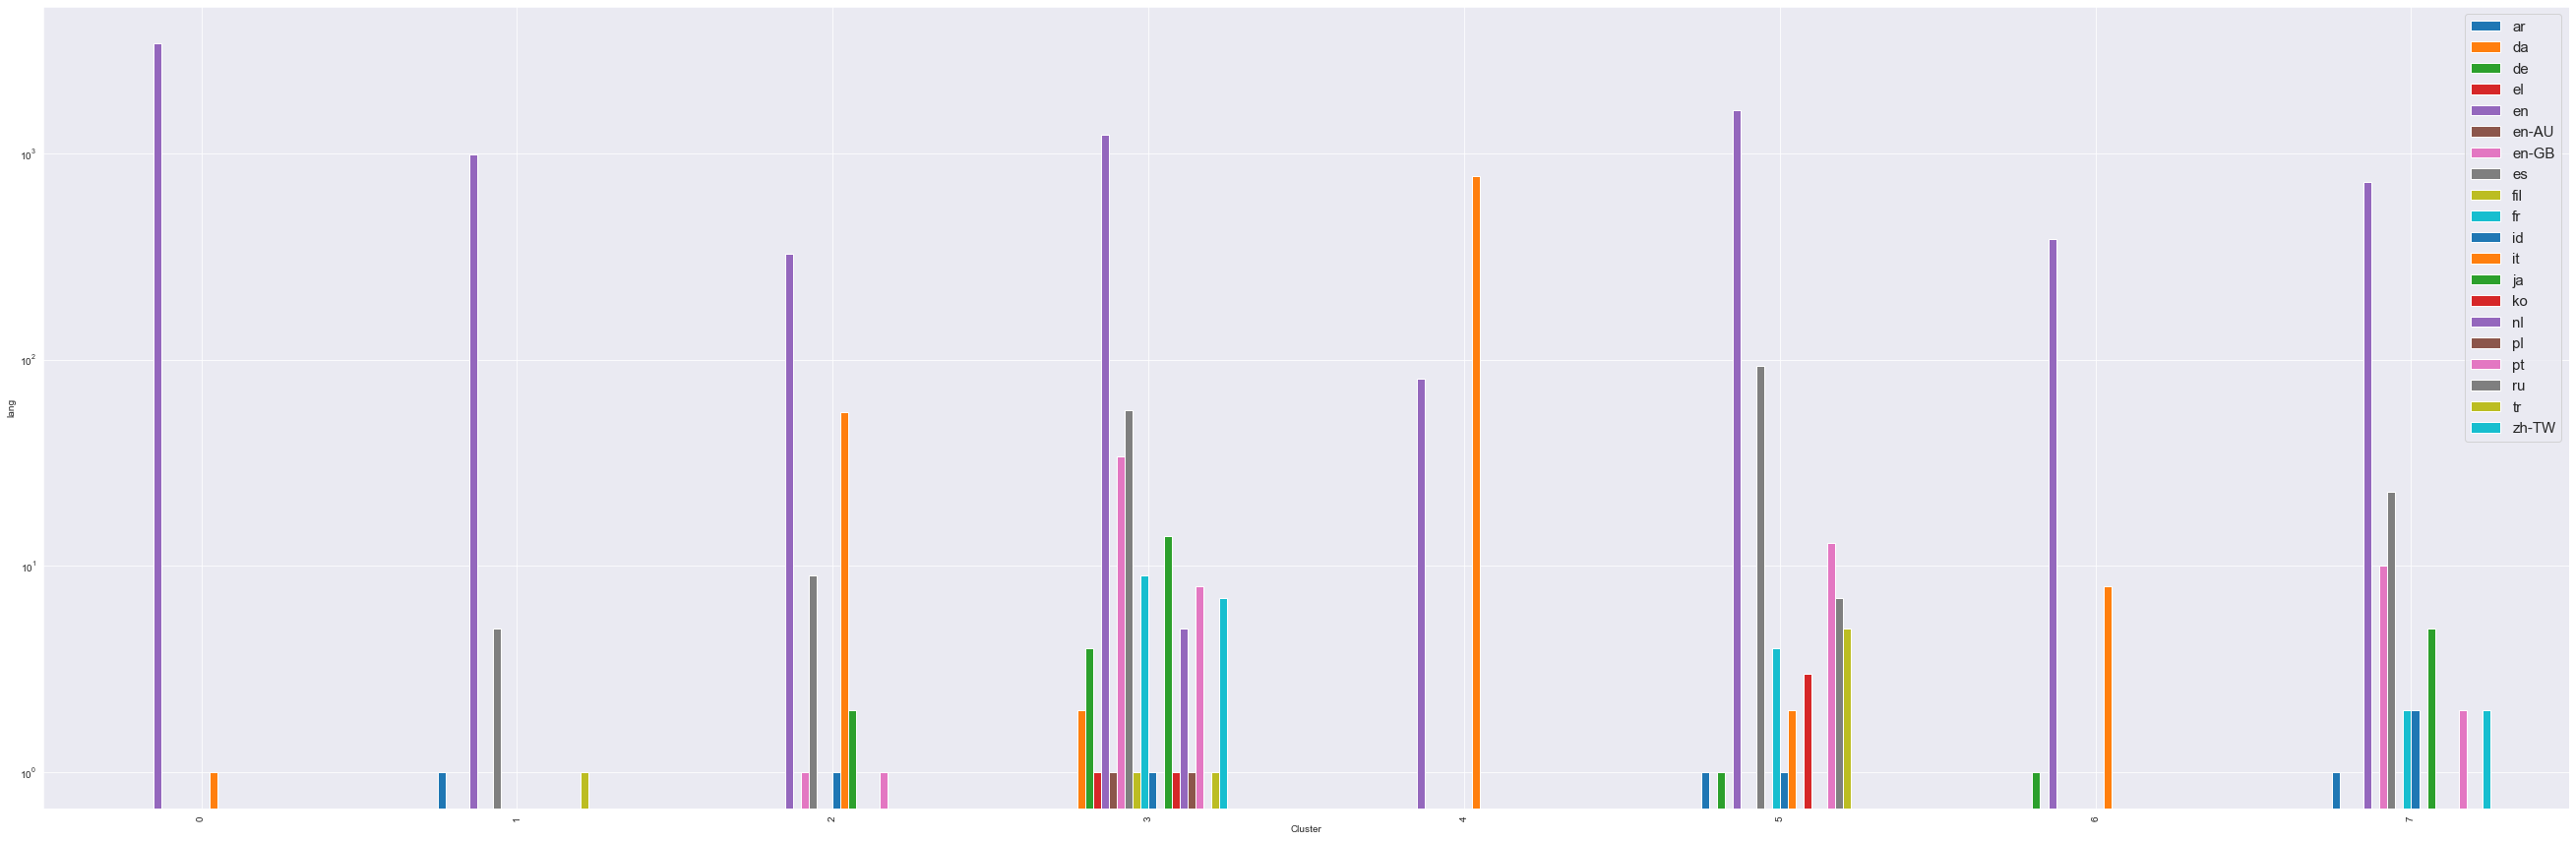

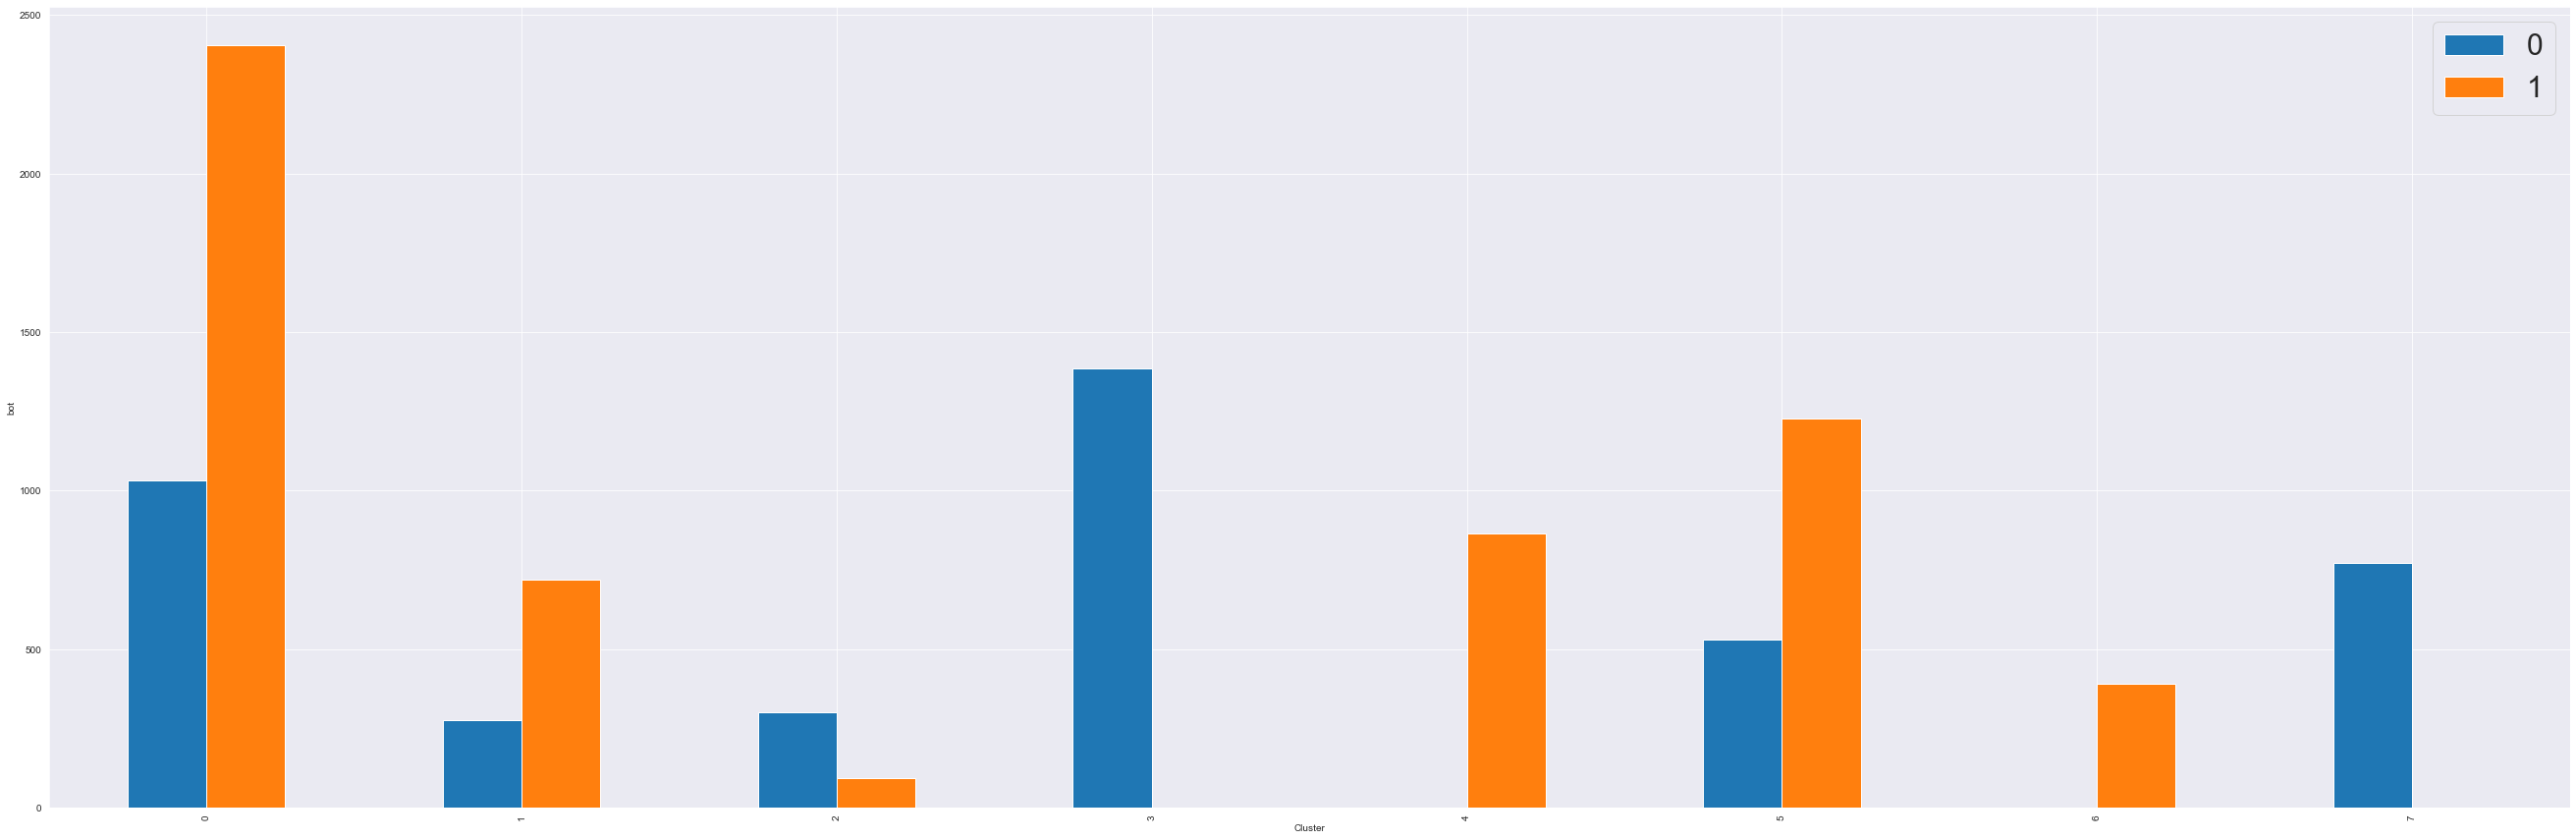

In [43]:
kmeans_analysis(df_denoised, k=8, out_dir='kmeans/denoised_k8')

SSE: 878.7360759387989
Silouhette score: 0.5374736259354937
Davies Bouldin score: 0.8971197680196629


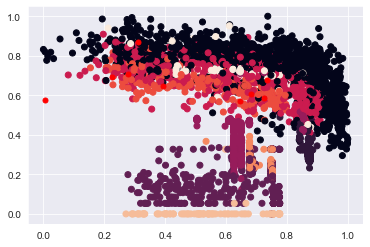

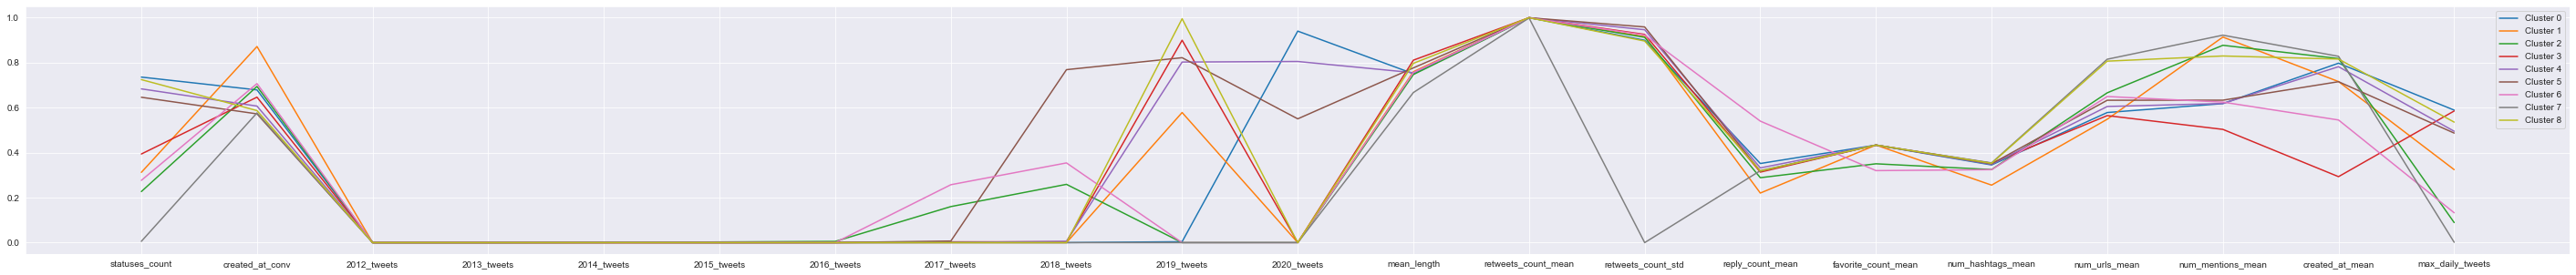

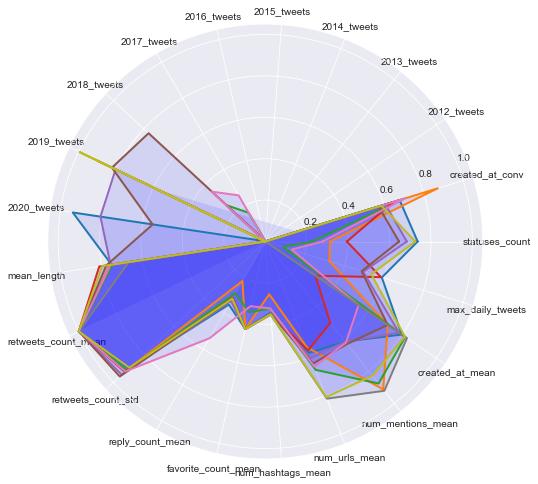

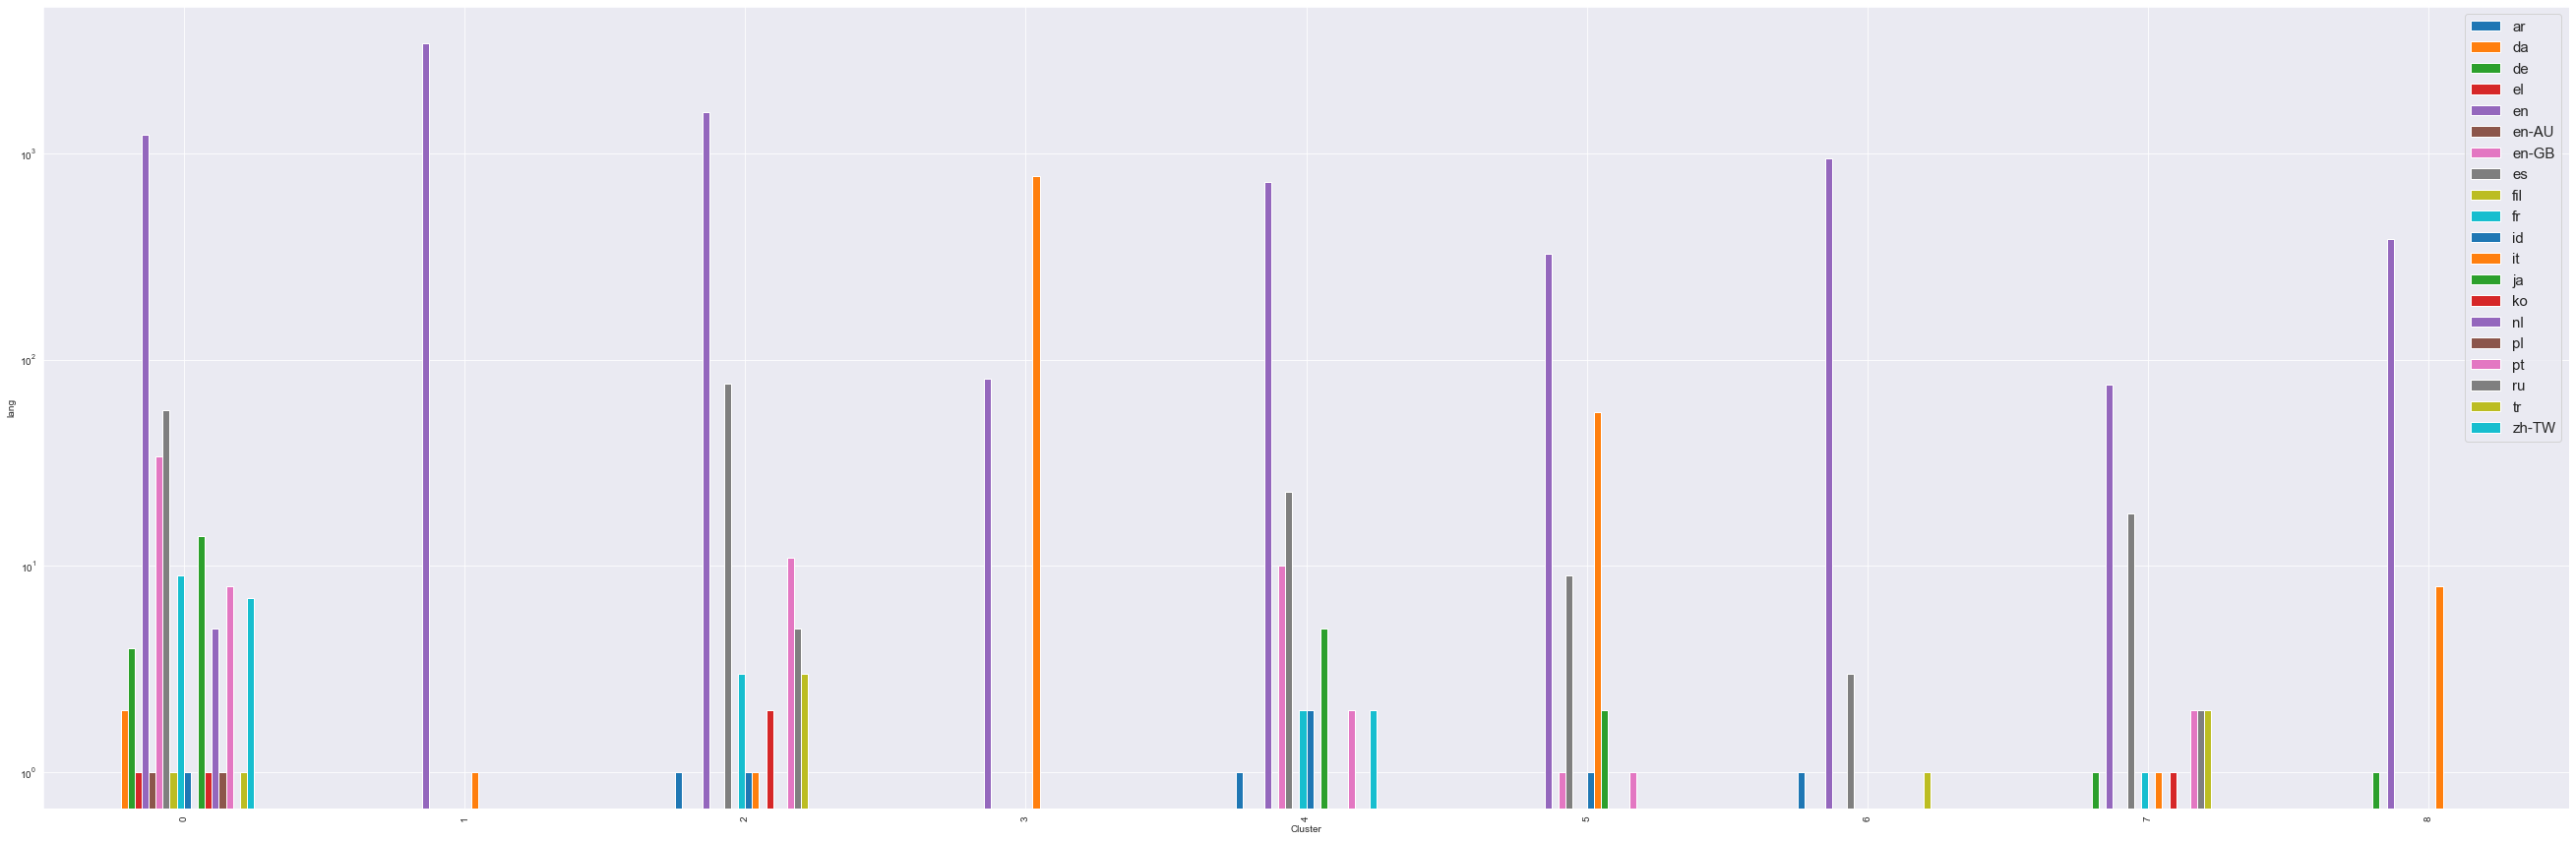

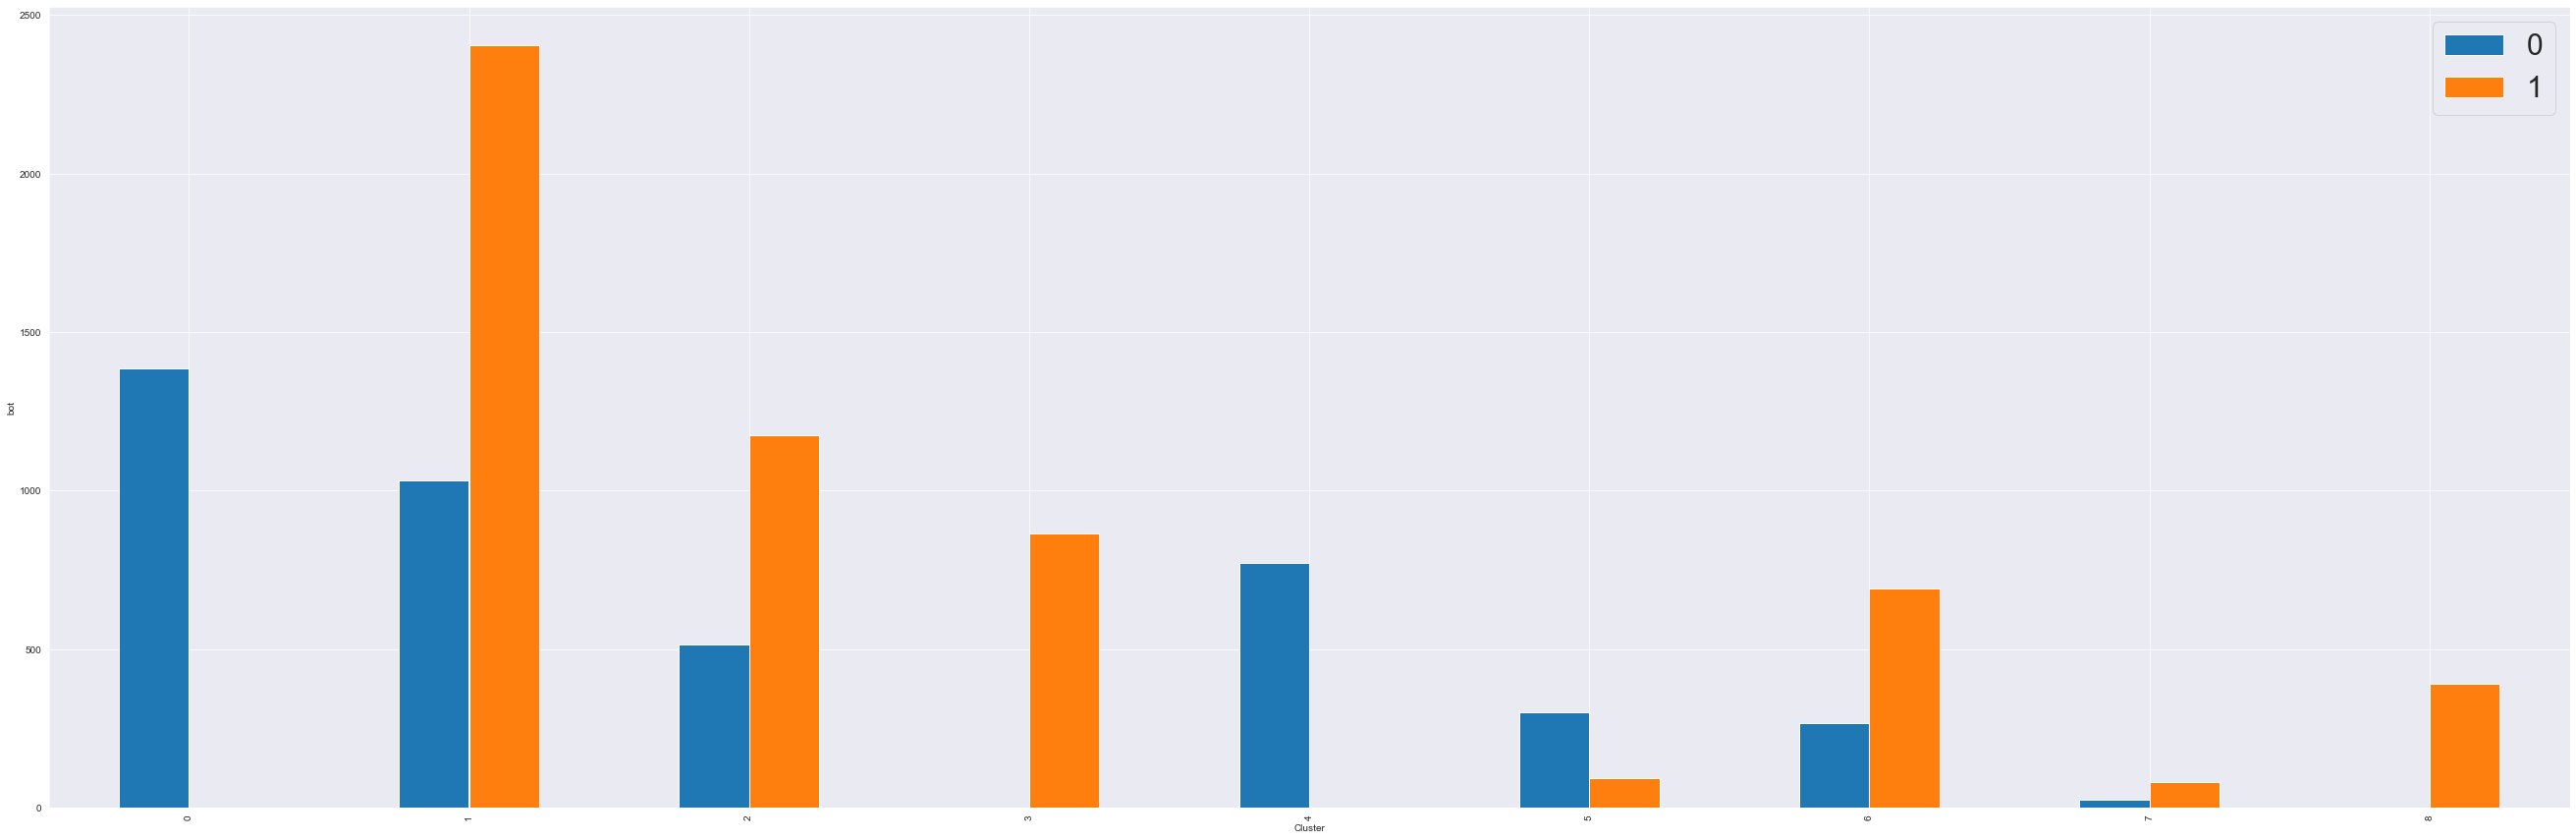

In [44]:
kmeans_analysis(df_denoised, k=9, out_dir='kmeans/denoised_k9')

SSE: 802.8614618405678
Silouhette score: 0.5343835484616772
Davies Bouldin score: 0.8844508621035228


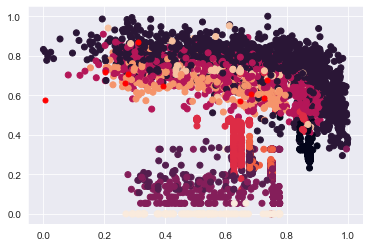

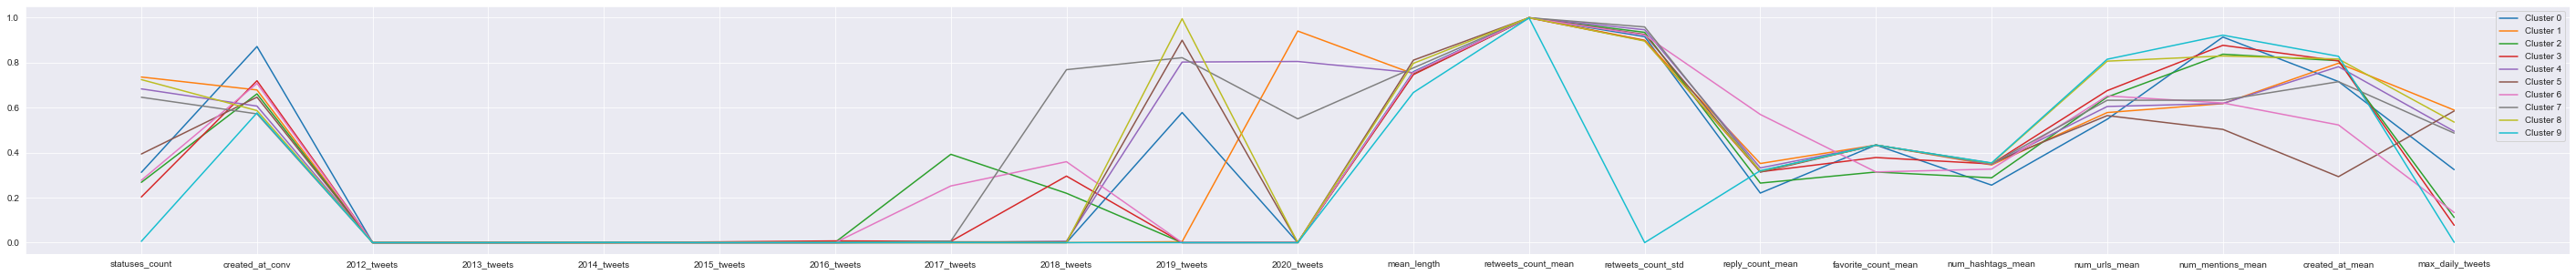

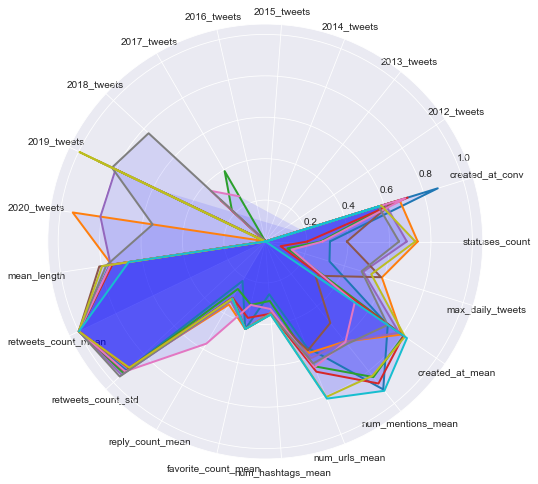

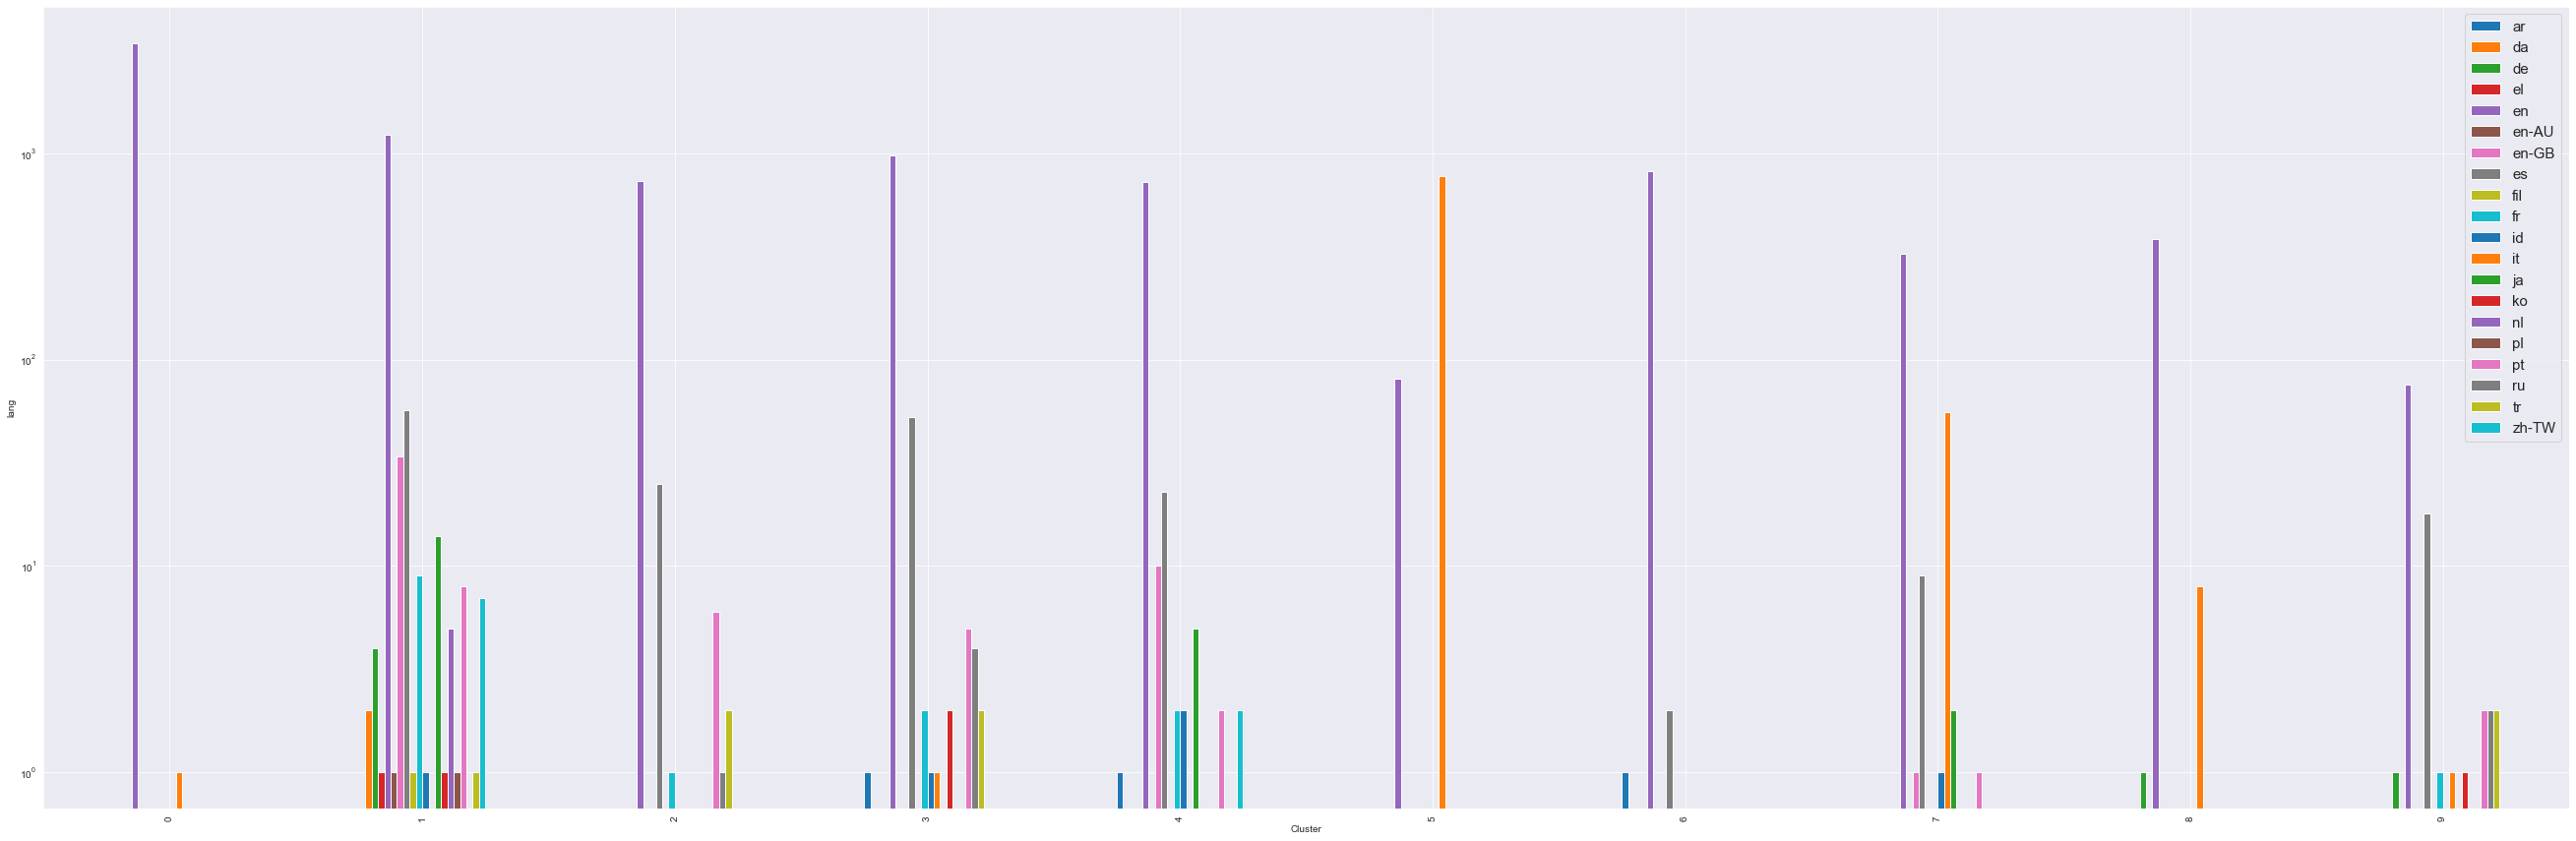

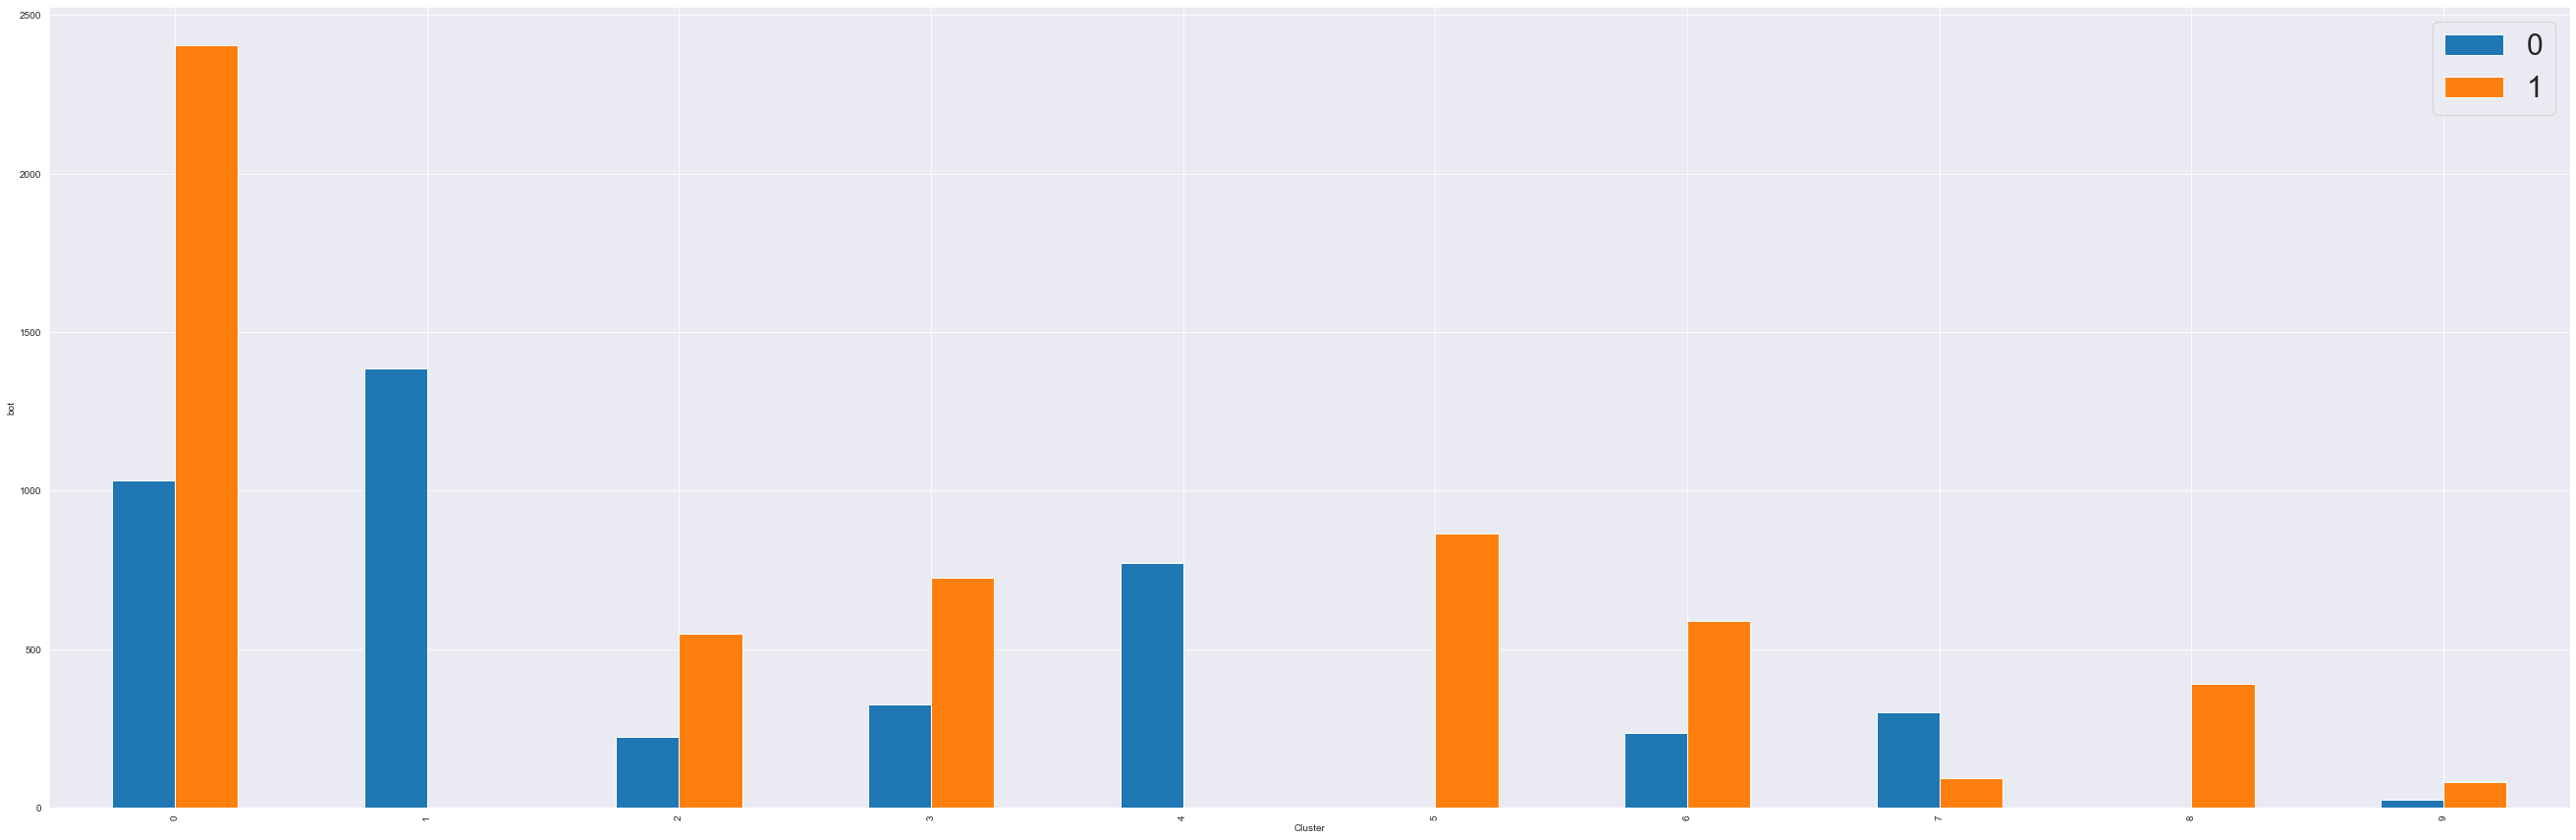

In [45]:
kmeans_analysis(df_denoised, k=10, out_dir='kmeans/denoised_k10')

# Hierarchical clustering

In [48]:
try:
  os.mkdir('hierarchical')
except FileExistsError:
  pass

In [165]:
def sse(df, labels):
    sum = 0
    for label in np.unique(labels):
        mean = df[labels==label].mean().values
        row_sums = df.apply(lambda row: np.linalg.norm(row.values - mean)**2,axis=1).sum()
        print(row_sums)
        sum += np.sum(row_sums)
    return sum

In [164]:
df_merge_scaled[numeric_attributes].loc[[0,1,3]].mean()

statuses_count         0.316112
created_at_conv        0.788800
2012_tweets            0.000000
2013_tweets            0.000000
2014_tweets            0.000000
2015_tweets            0.000000
2016_tweets            0.000000
2017_tweets            0.000000
2018_tweets            0.000000
2019_tweets            0.680968
2020_tweets            0.000000
mean_length            0.777269
retweets_count_mean    0.999599
retweets_count_std     0.918817
reply_count_mean       0.245703
favorite_count_mean    0.433457
num_hashtags_mean      0.218723
num_urls_mean          0.538350
num_mentions_mean      0.779331
created_at_mean        0.582593
max_daily_tweets       0.436781
dtype: float64

In [204]:
def hierarchical_analysis(df,metric, method, truncate_mode, p, n_clusters, directory, plot=False):
    df = df.reset_index()
    distances = pdist(df[numeric_attributes], metric=metric)
    dlinkage = linkage(distances, metric=metric, method=method)

    labels = fcluster(dlinkage,n_clusters,criterion='maxclust')
    if plot:
        try:
            os.mkdir(os.path.join('hierarchical',directory))
        except FileExistsError:
            pass

        dendrogram(dlinkage, truncate_mode=truncate_mode, p=p)
        plt.savefig(os.path.join('hierarchical',directory,"dendrogram.png"))
        plt.show()
        scatterplot(df[numeric_attributes], 'created_at_conv', 'statuses_count',c_labels=labels,filename=os.path.join('hierarchical',directory, 'scatterplot.png'))

        plots(df, labels, os.path.join('hierarchical',directory), attributes=numeric_attributes)


    #print(f"SSE: {sse(df[numeric_attributes],labels)}")
    if len(labels) > 1:
        try:
            return get_metrics(df[numeric_attributes], labels, print_out=False)
        except:
            return 0,0
    else: return 0,0

In [186]:
def hierarchial_gs(df):
    table = PrettyTable(colums=['metric','method','truncation_mode','truncation_level','n_clustes','sse',])
    for metric in ['cityblock','correlation', 'cosine', 'dice', 'euclidean']:
        methods = ['complete','single','average','weighted']
        if metric == 'euclidean':
            methods += ['ward','median','centroid']
        for method in methods:
            for truncation_mode in [None, 'lastp','level']:
                for level in [2,3,4]:
                    for k in [7,8,9,10]:
                        metrics = hierarchical_analysis(df[numeric_attributes], metric, method, truncate_mode=truncation_mode, p=level, n_clusters=k,
                                                           directory=f'hierarchical/{metric}_{method}_{truncation_mode}_{level}_{k}')
                        table.add_row([metric, method, truncation_mode, level, k, *metrics])
    print(table)

This approach is tested on both noisy and denoised data.

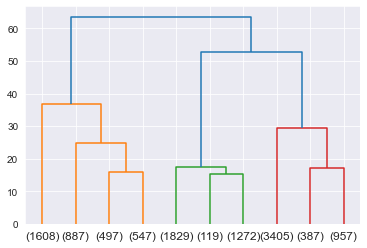

(0.4443250312080813, 1.1788554774526165)

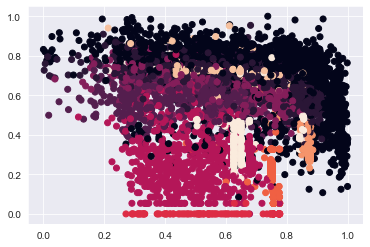

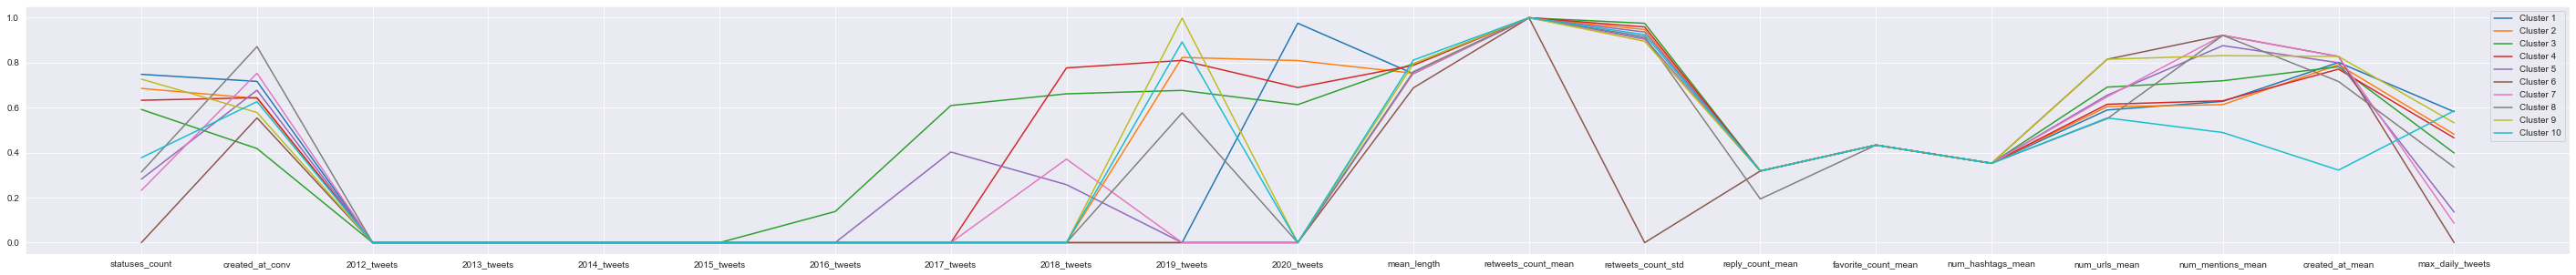

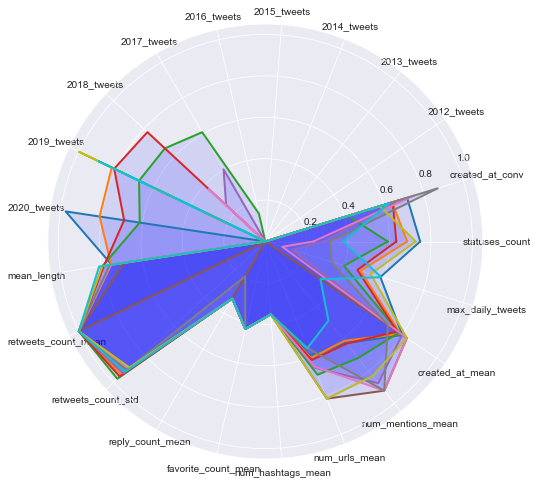

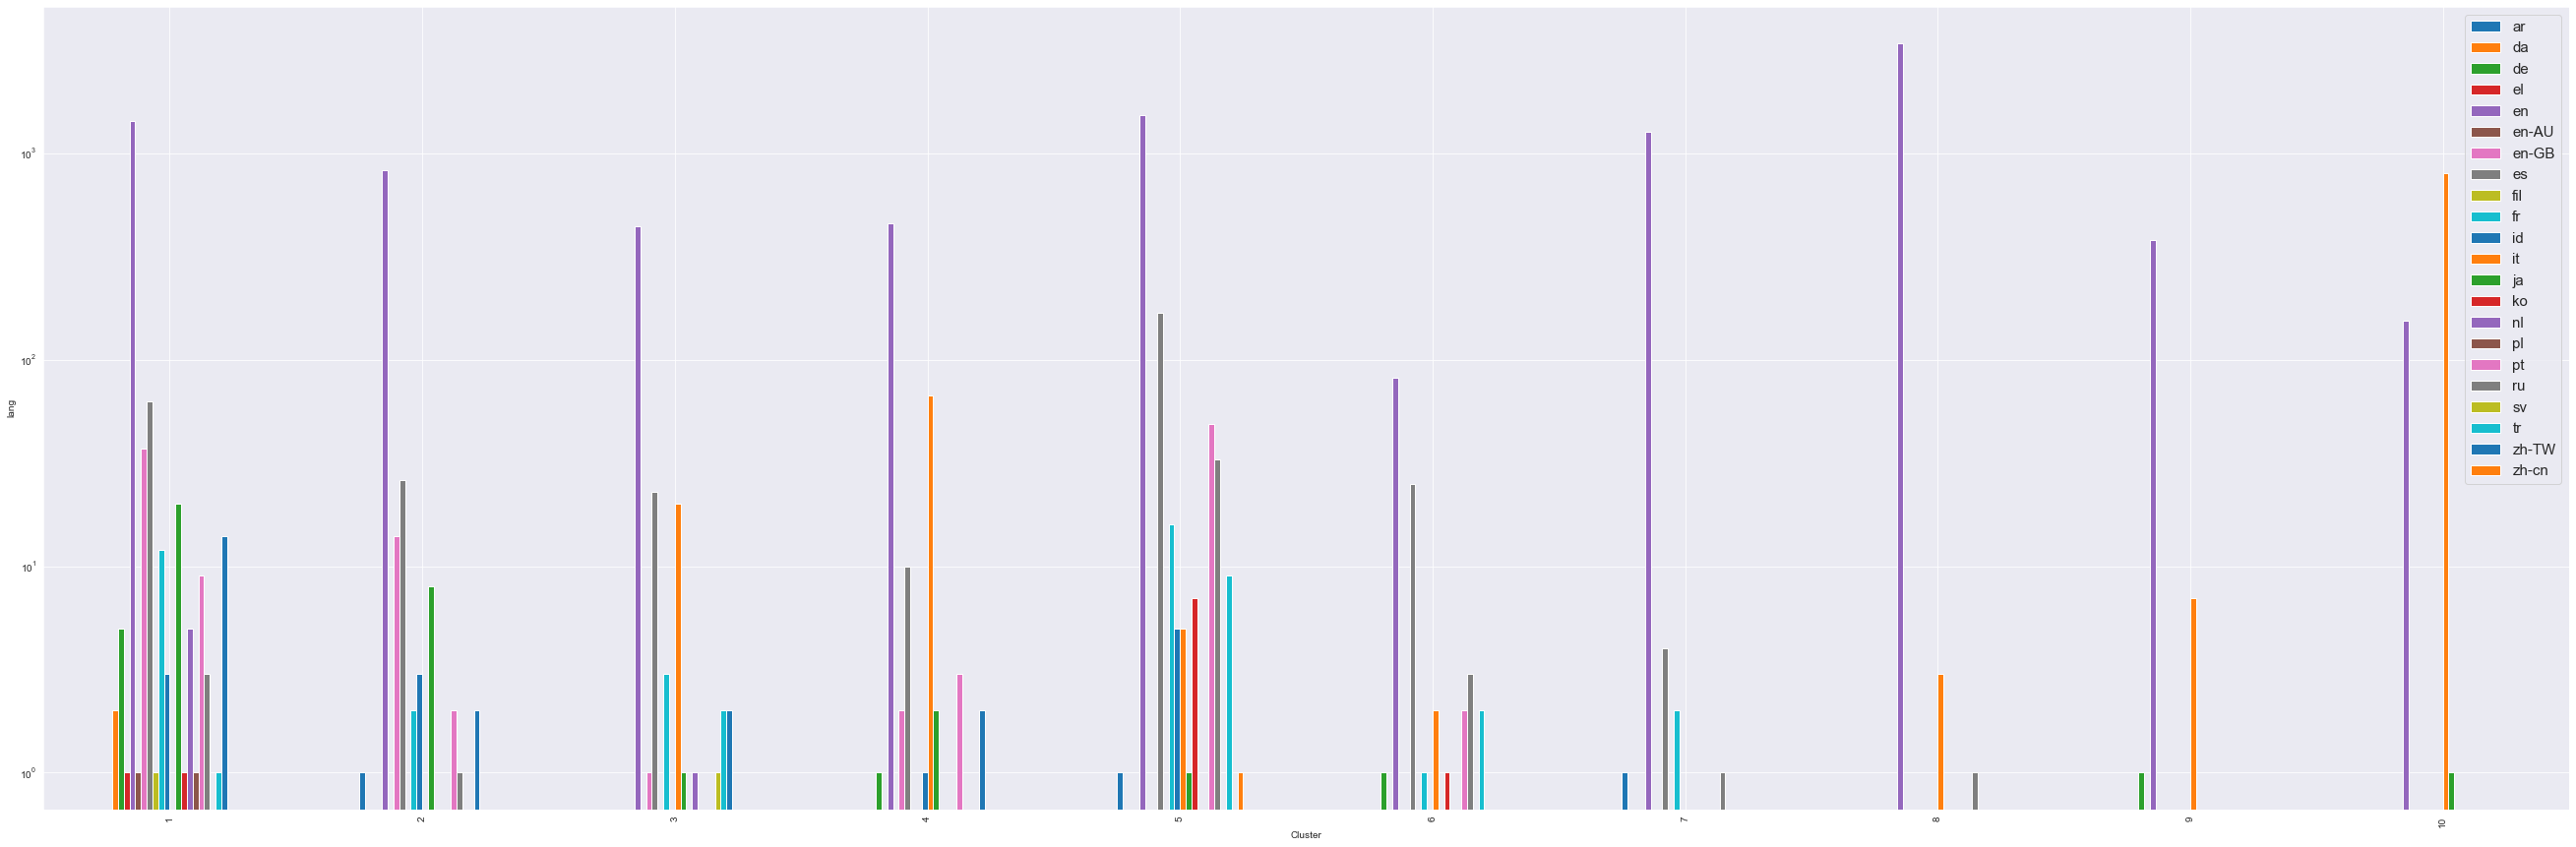

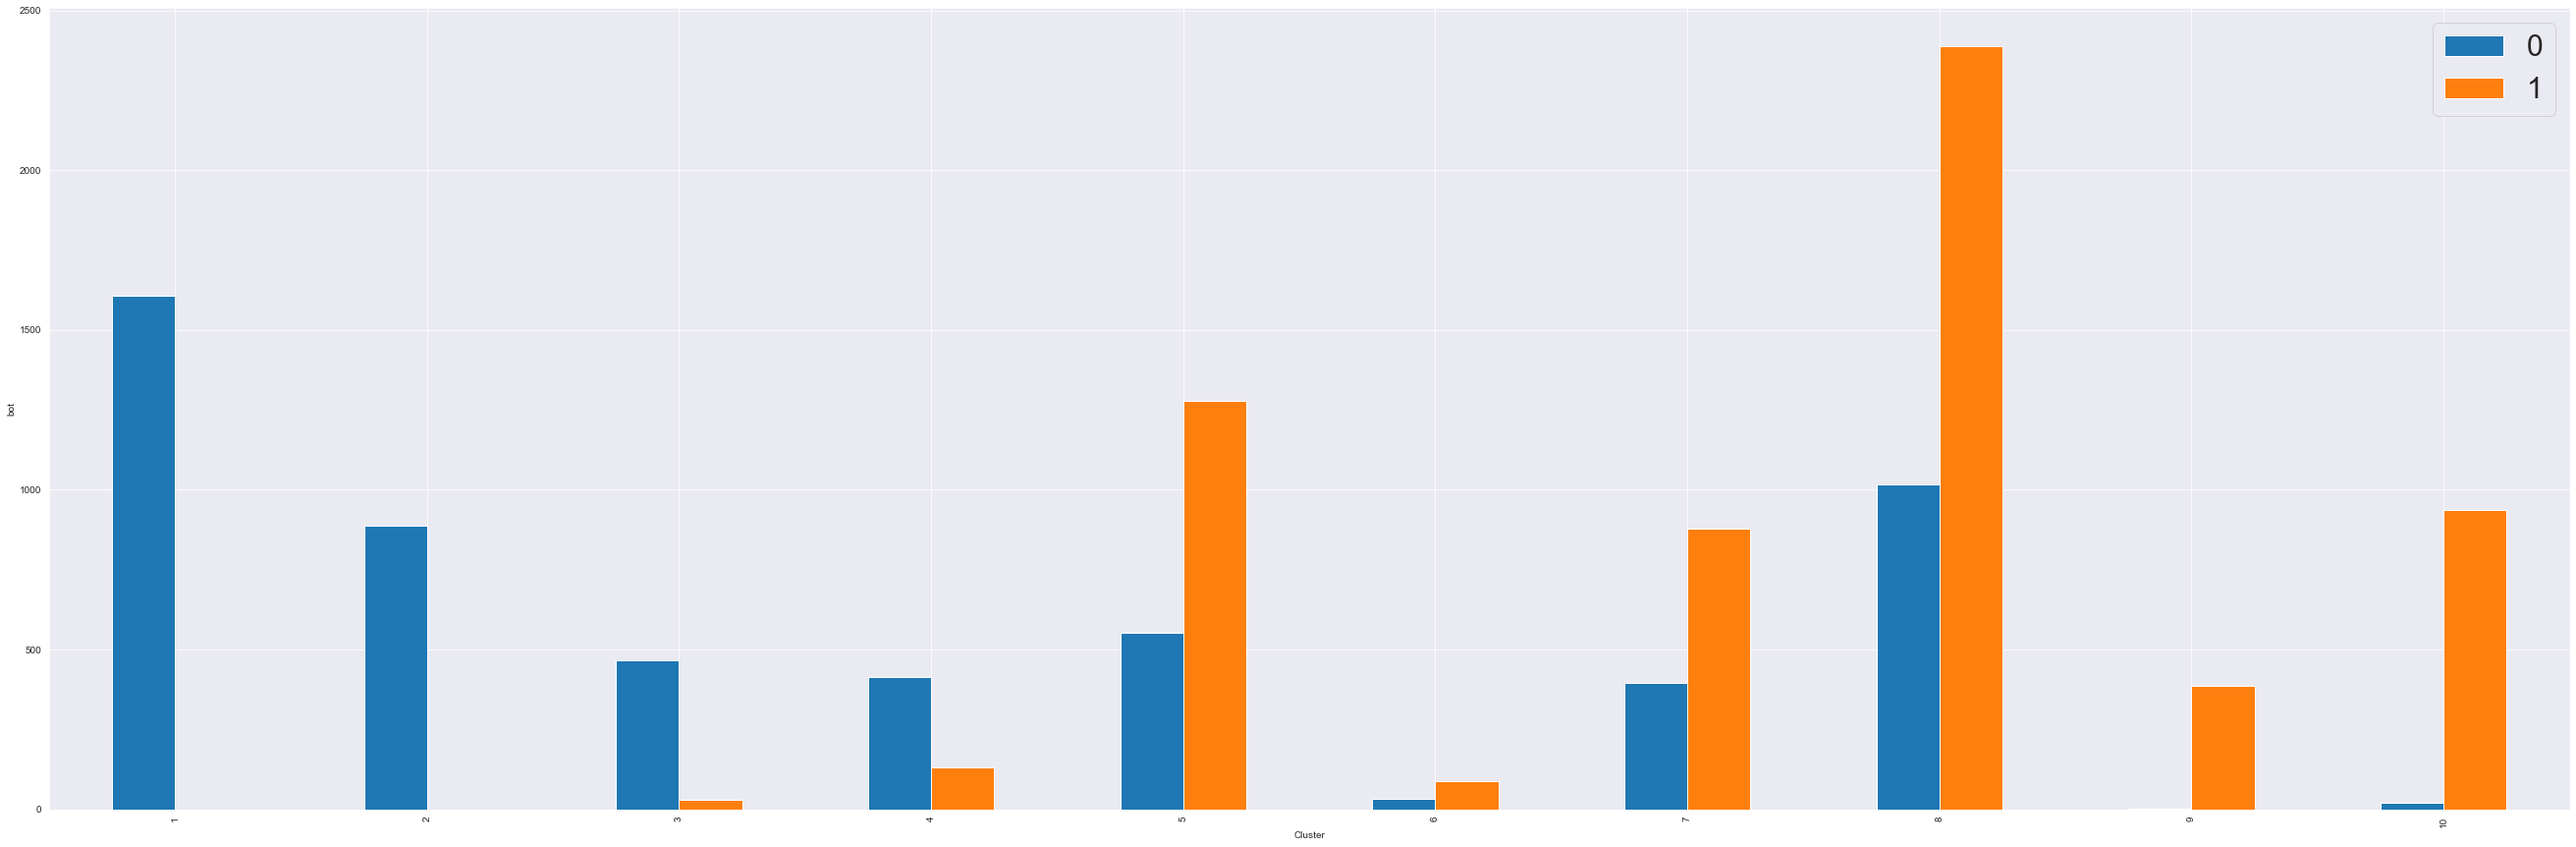

In [208]:
hierarchical_analysis(df_merge_scaled,'euclidean','ward','lastp',p=10,n_clusters=10,directory='euclidean_ward_k10_p4',plot=True)

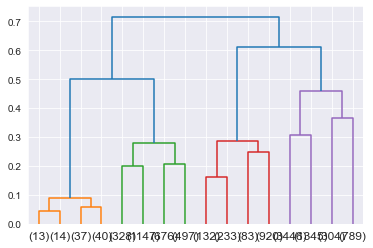

(0.5141175987798318, 0.793462032202427)

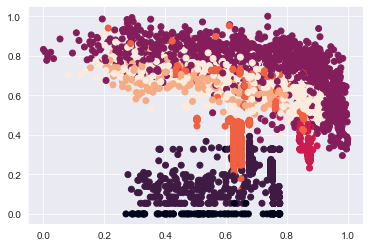

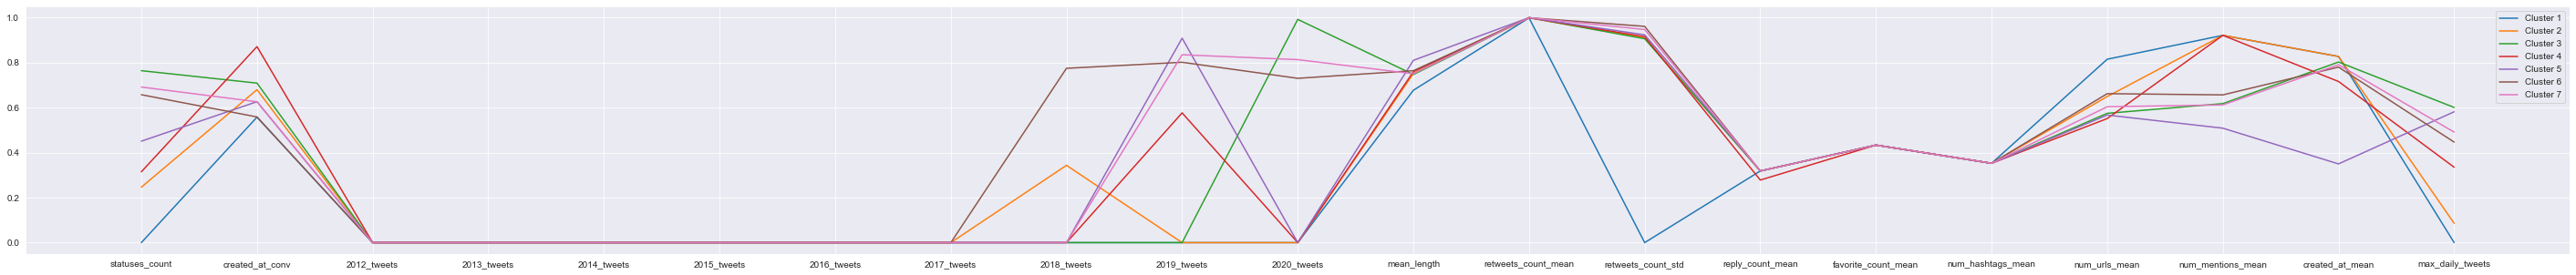

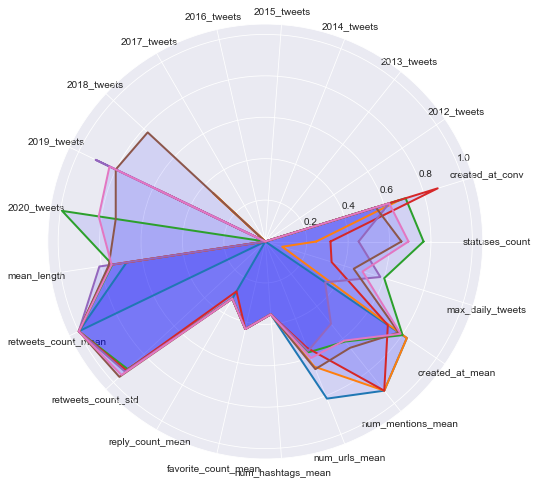

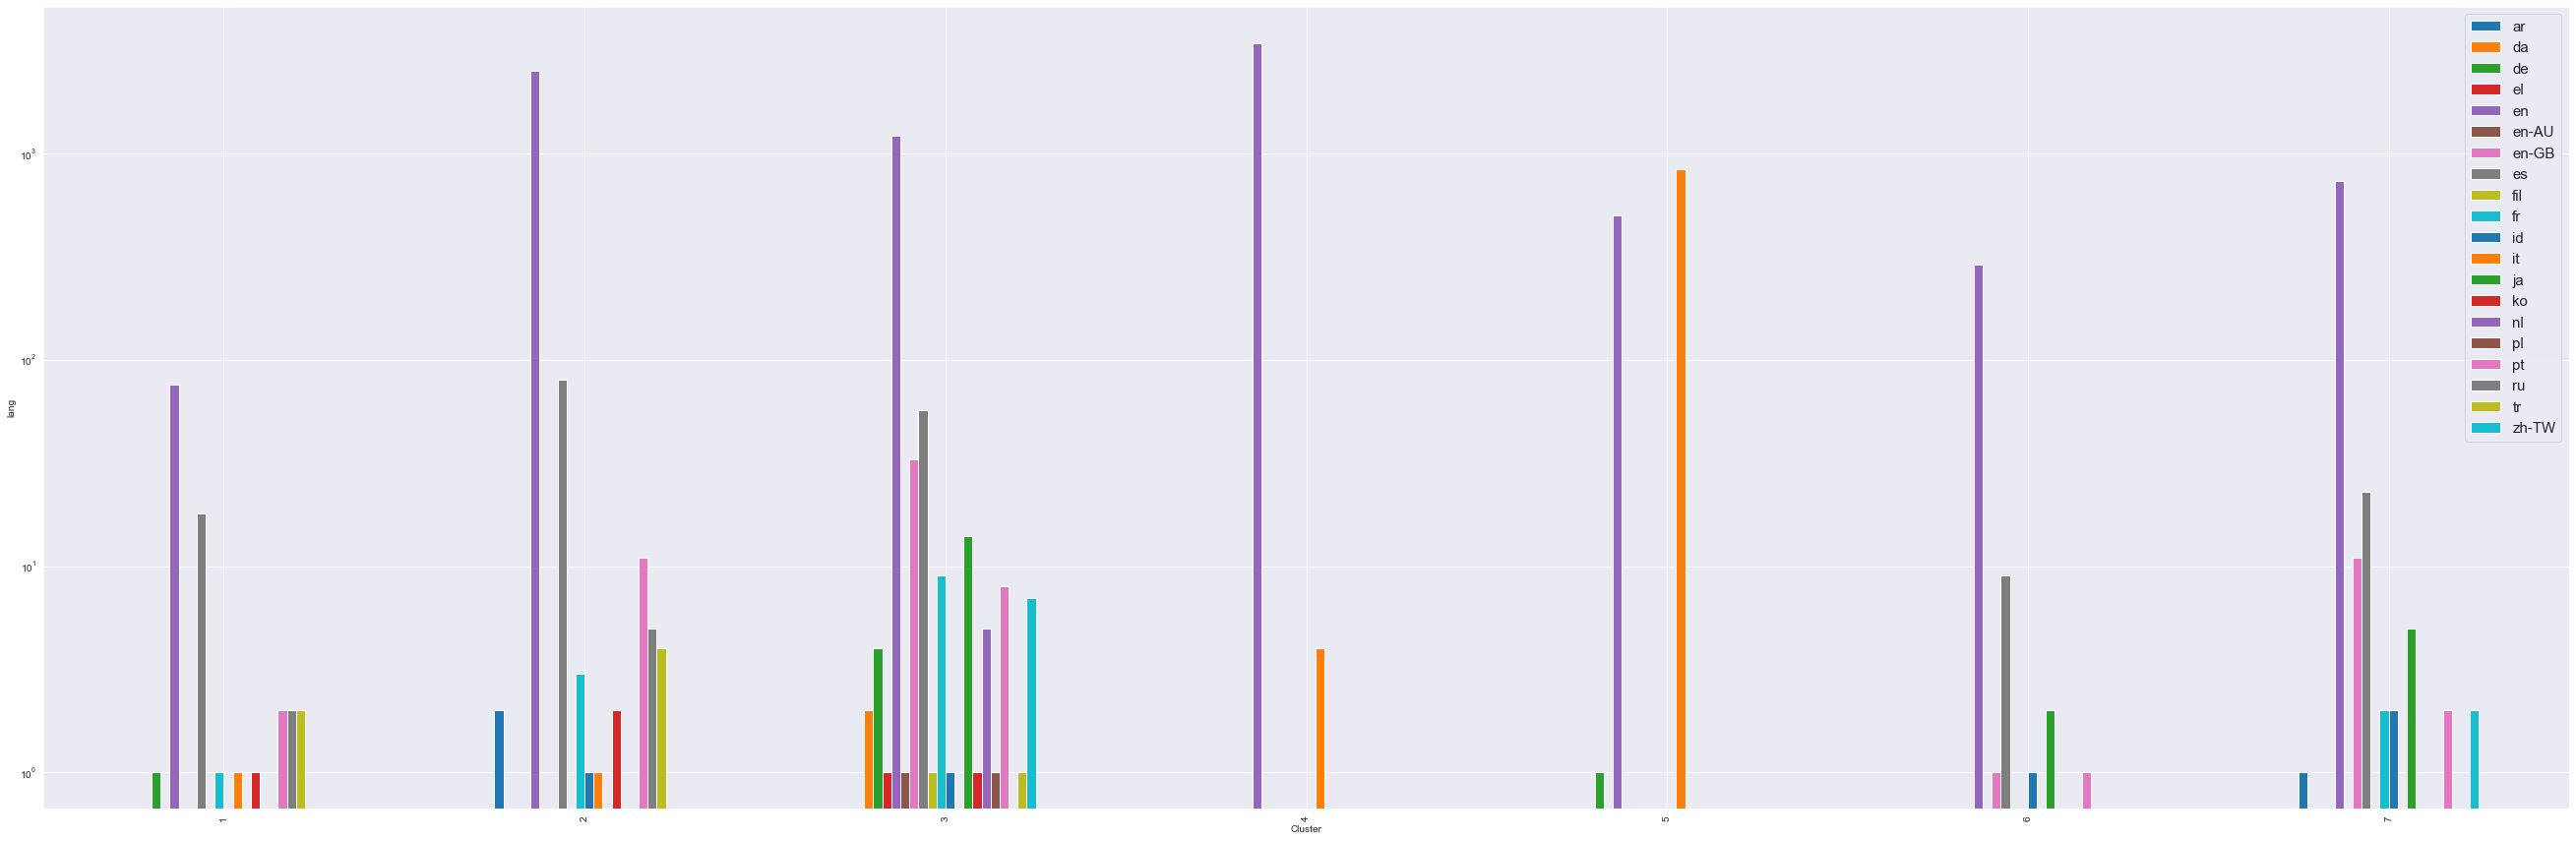

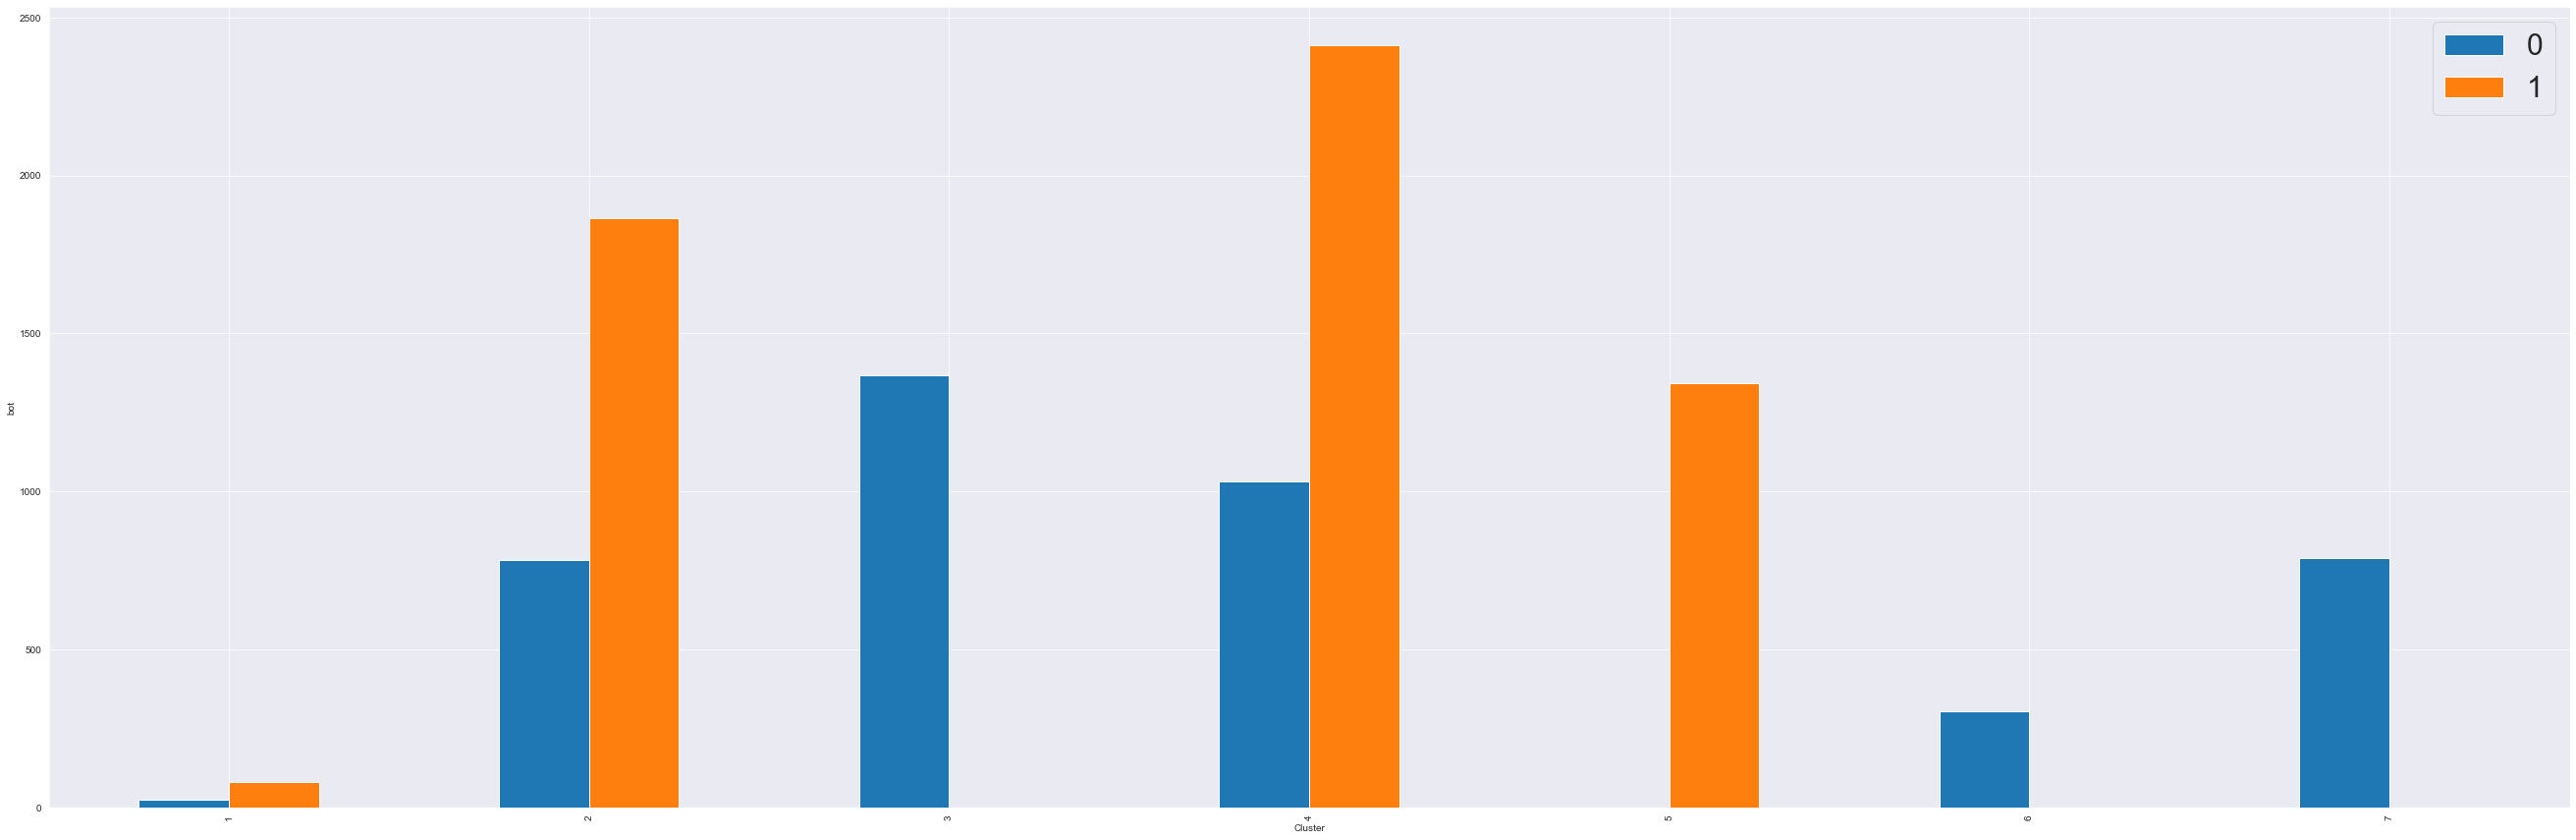

In [228]:
hierarchical_analysis(df_denoised,'correlation','complete','level',p=3,n_clusters=7,directory='denoised_correlation_k10',plot=True)

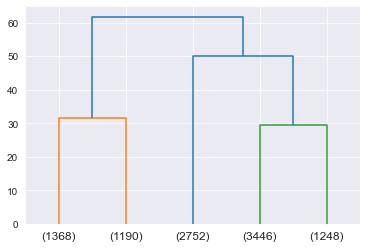

(0.5407185011616725, 0.7651400836066408)

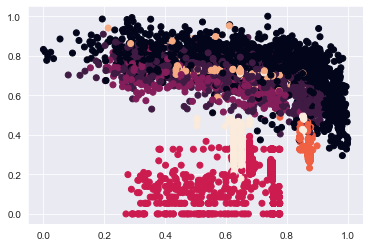

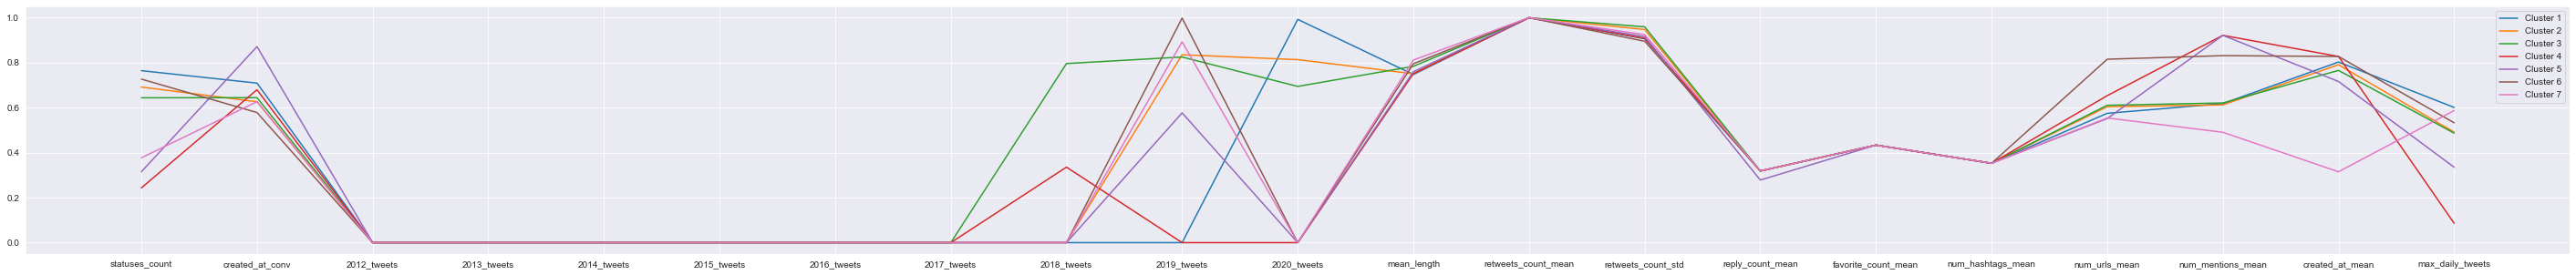

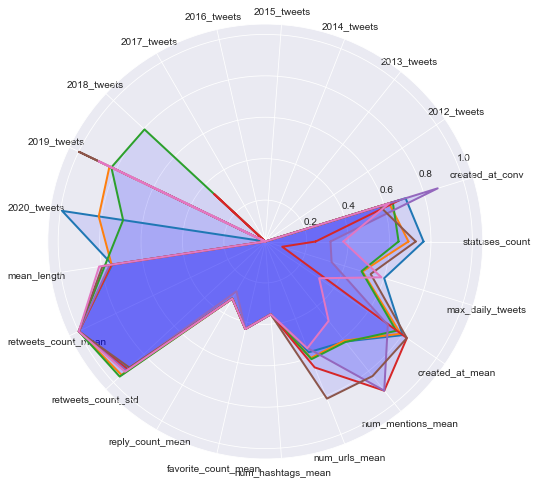

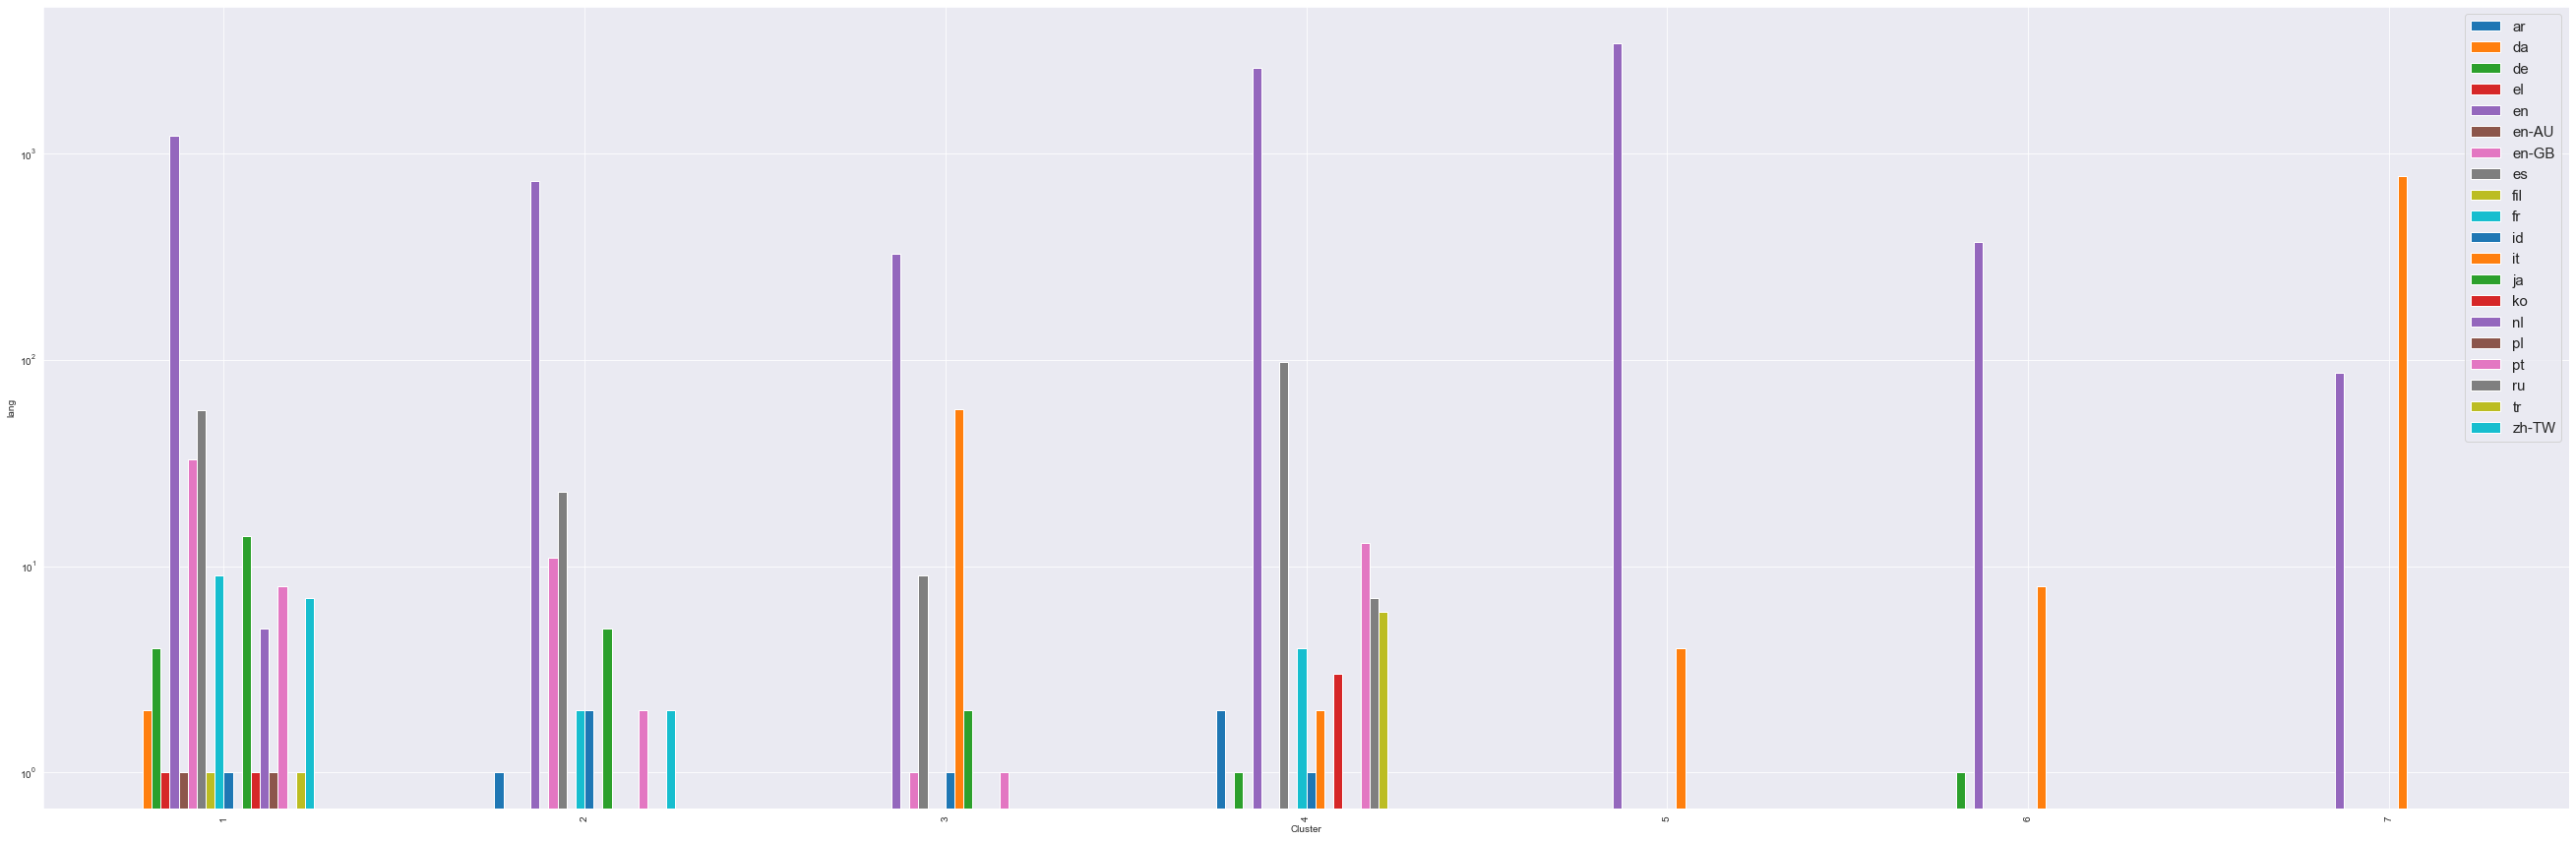

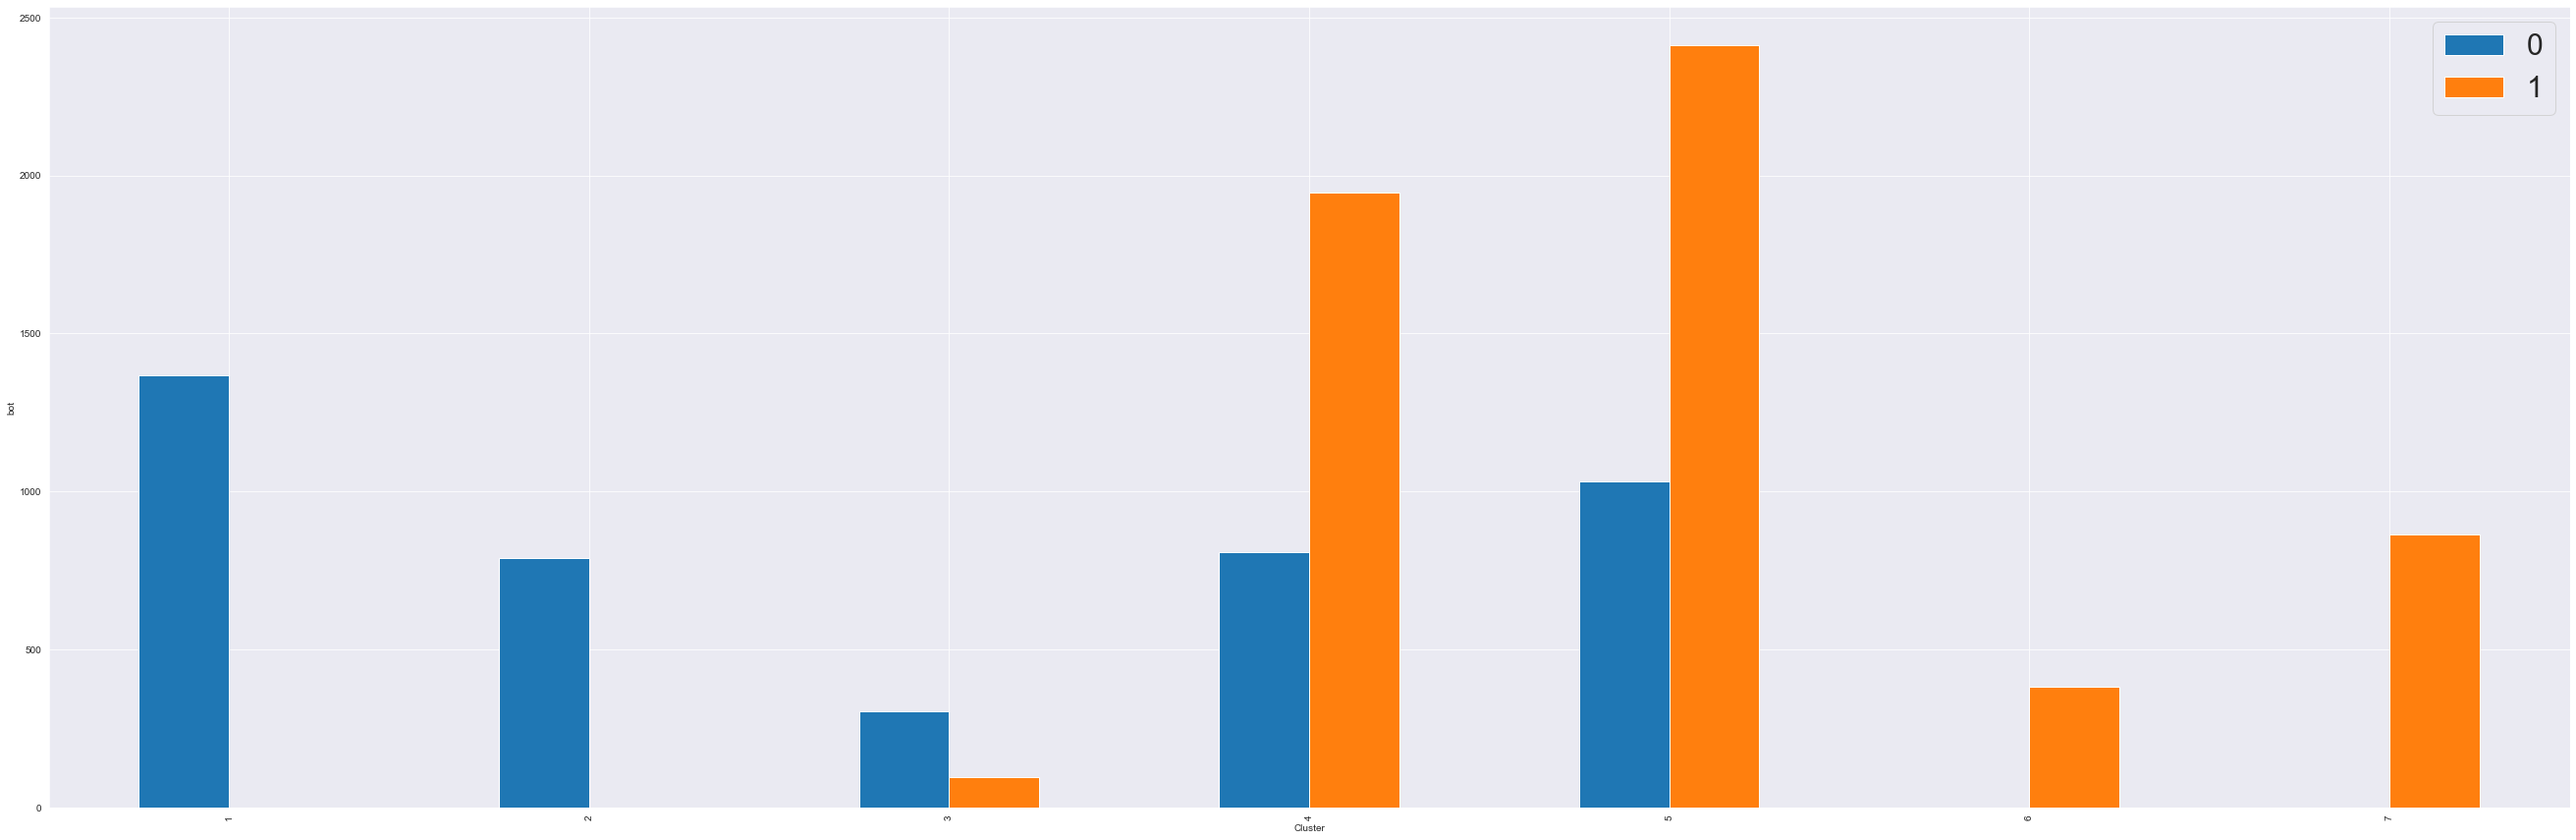

In [230]:
hierarchical_analysis(df_denoised,'euclidean','ward','lastp',p=5,n_clusters=7,directory='denoised_ward_k7',plot=True)

# Agglomerative clustering

In [225]:
def agglomerative_analysis(df, n_clusters, metric='euclidean', linkage='ward'):
    clusters = AgglomerativeClustering(affinity=metric, n_clusters=n_clusters, linkage=linkage)
    clusters.fit(df_merge_scaled[numeric_attributes])

    path=f'agglomerative/{metric}_{linkage}_k{n_clusters}/'
    get_metrics(df_merge_scaled[numeric_attributes], clusters.labels_)
    plots(df_merge_scaled, clusters.labels_, path=path, attributes=numeric_attributes)
    plt.show()
    scatterplot(df_merge_scaled, 'created_at_conv', 'statuses_count', clusters.labels_,filename=os.path.join(path,'scatterplot.png'))

Silouhette score: 0.4443250312080813
Davies Bouldin score: 1.1788554774526165


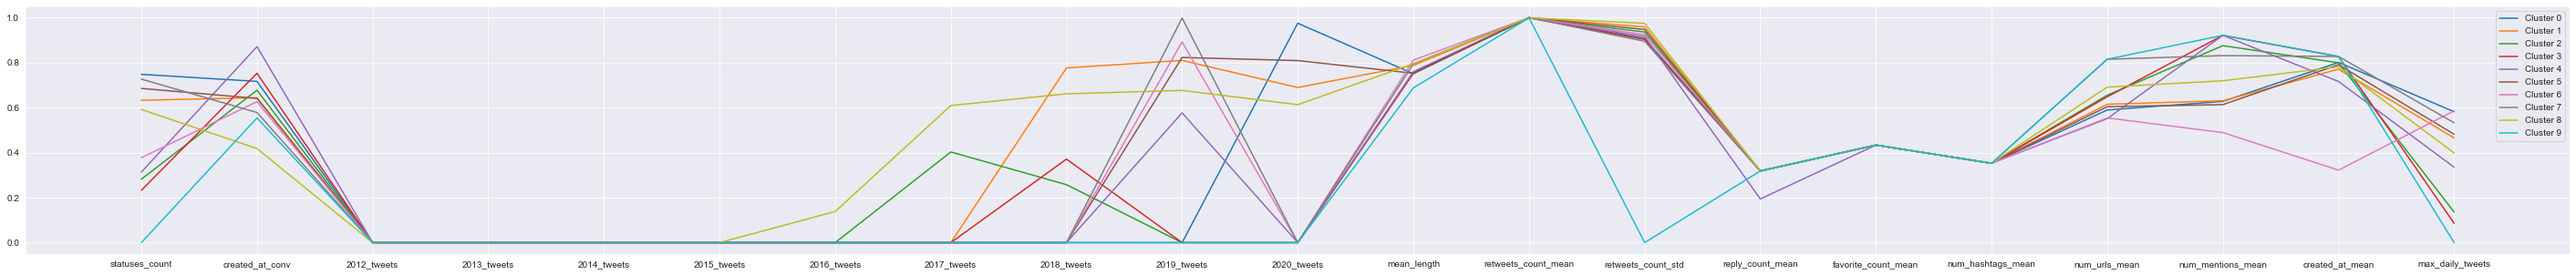

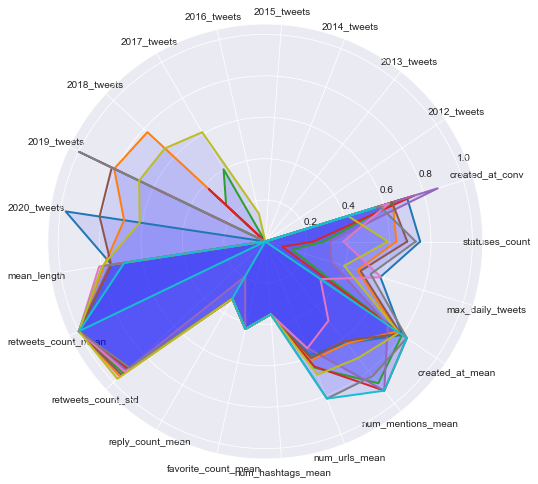

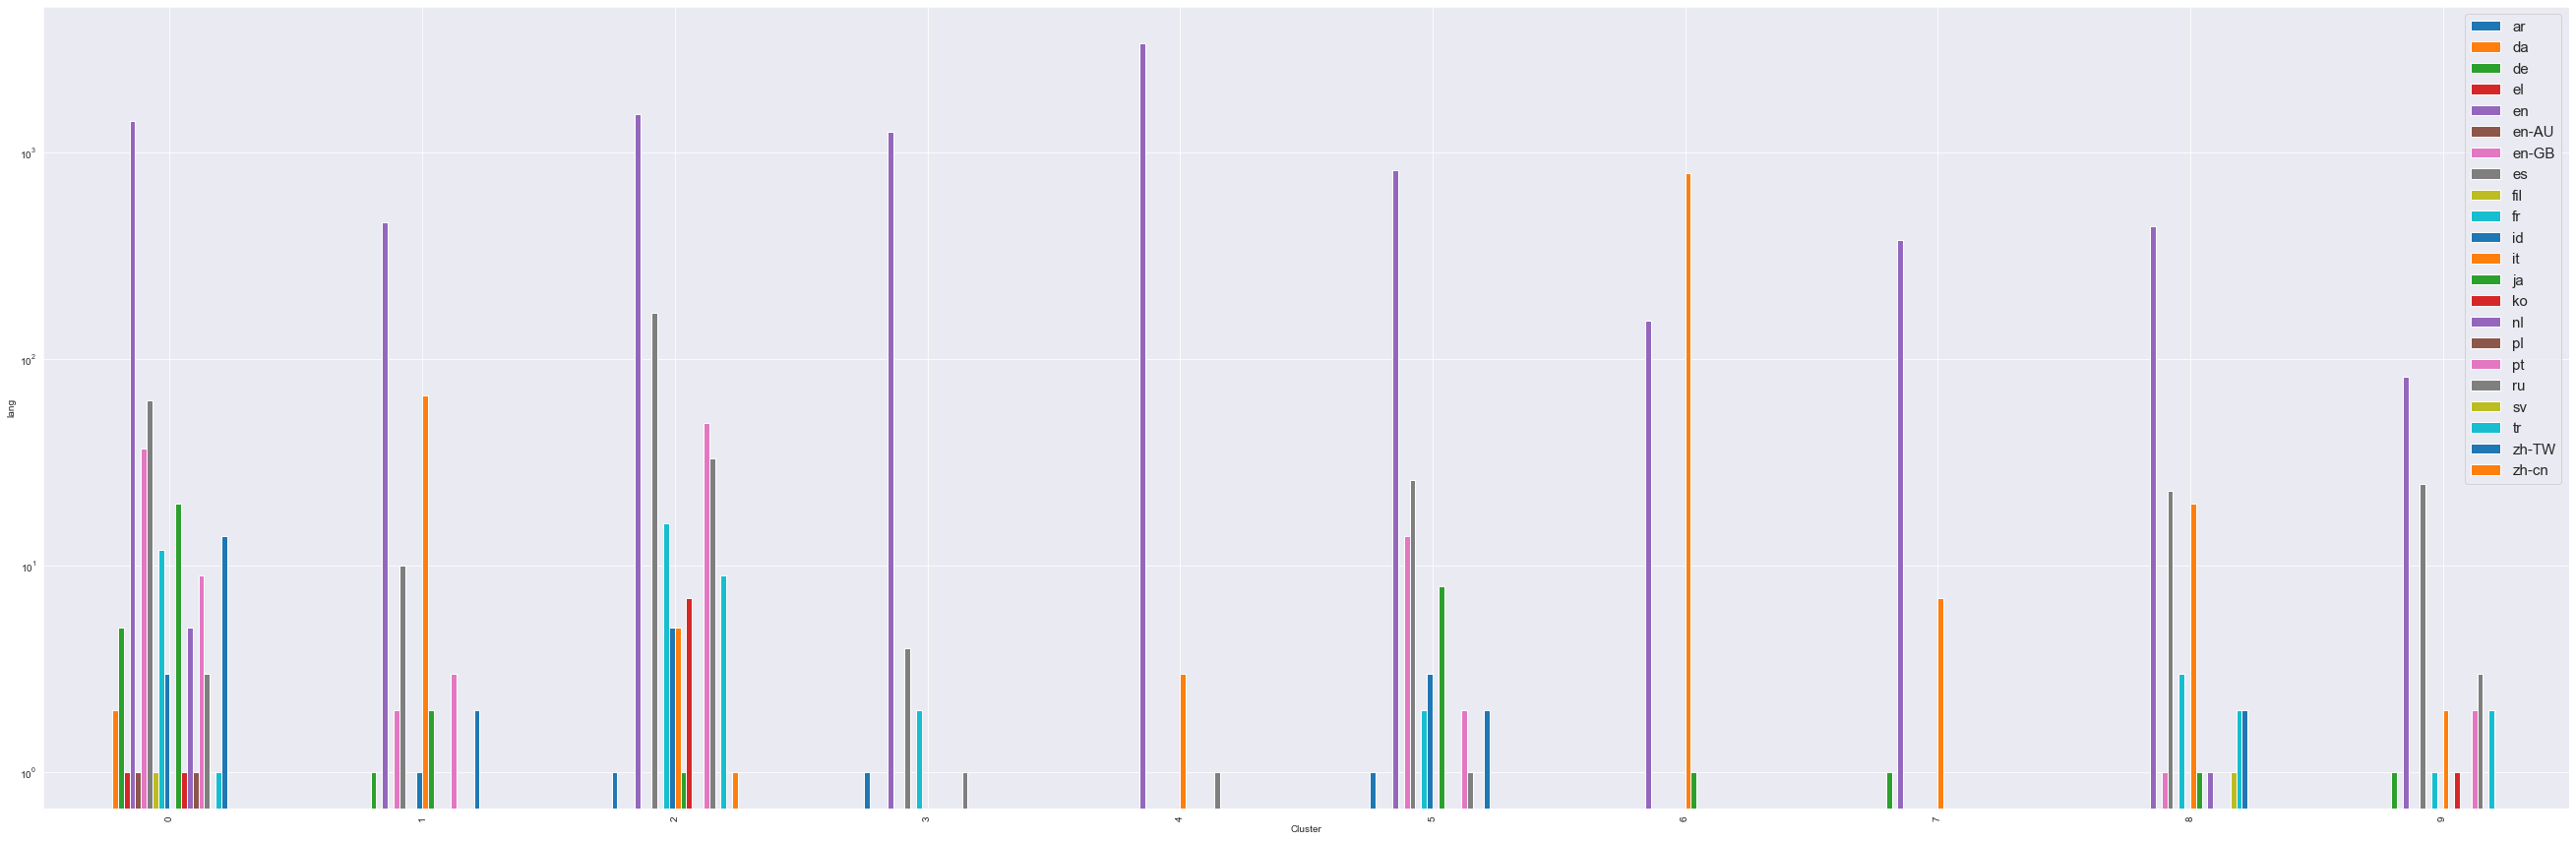

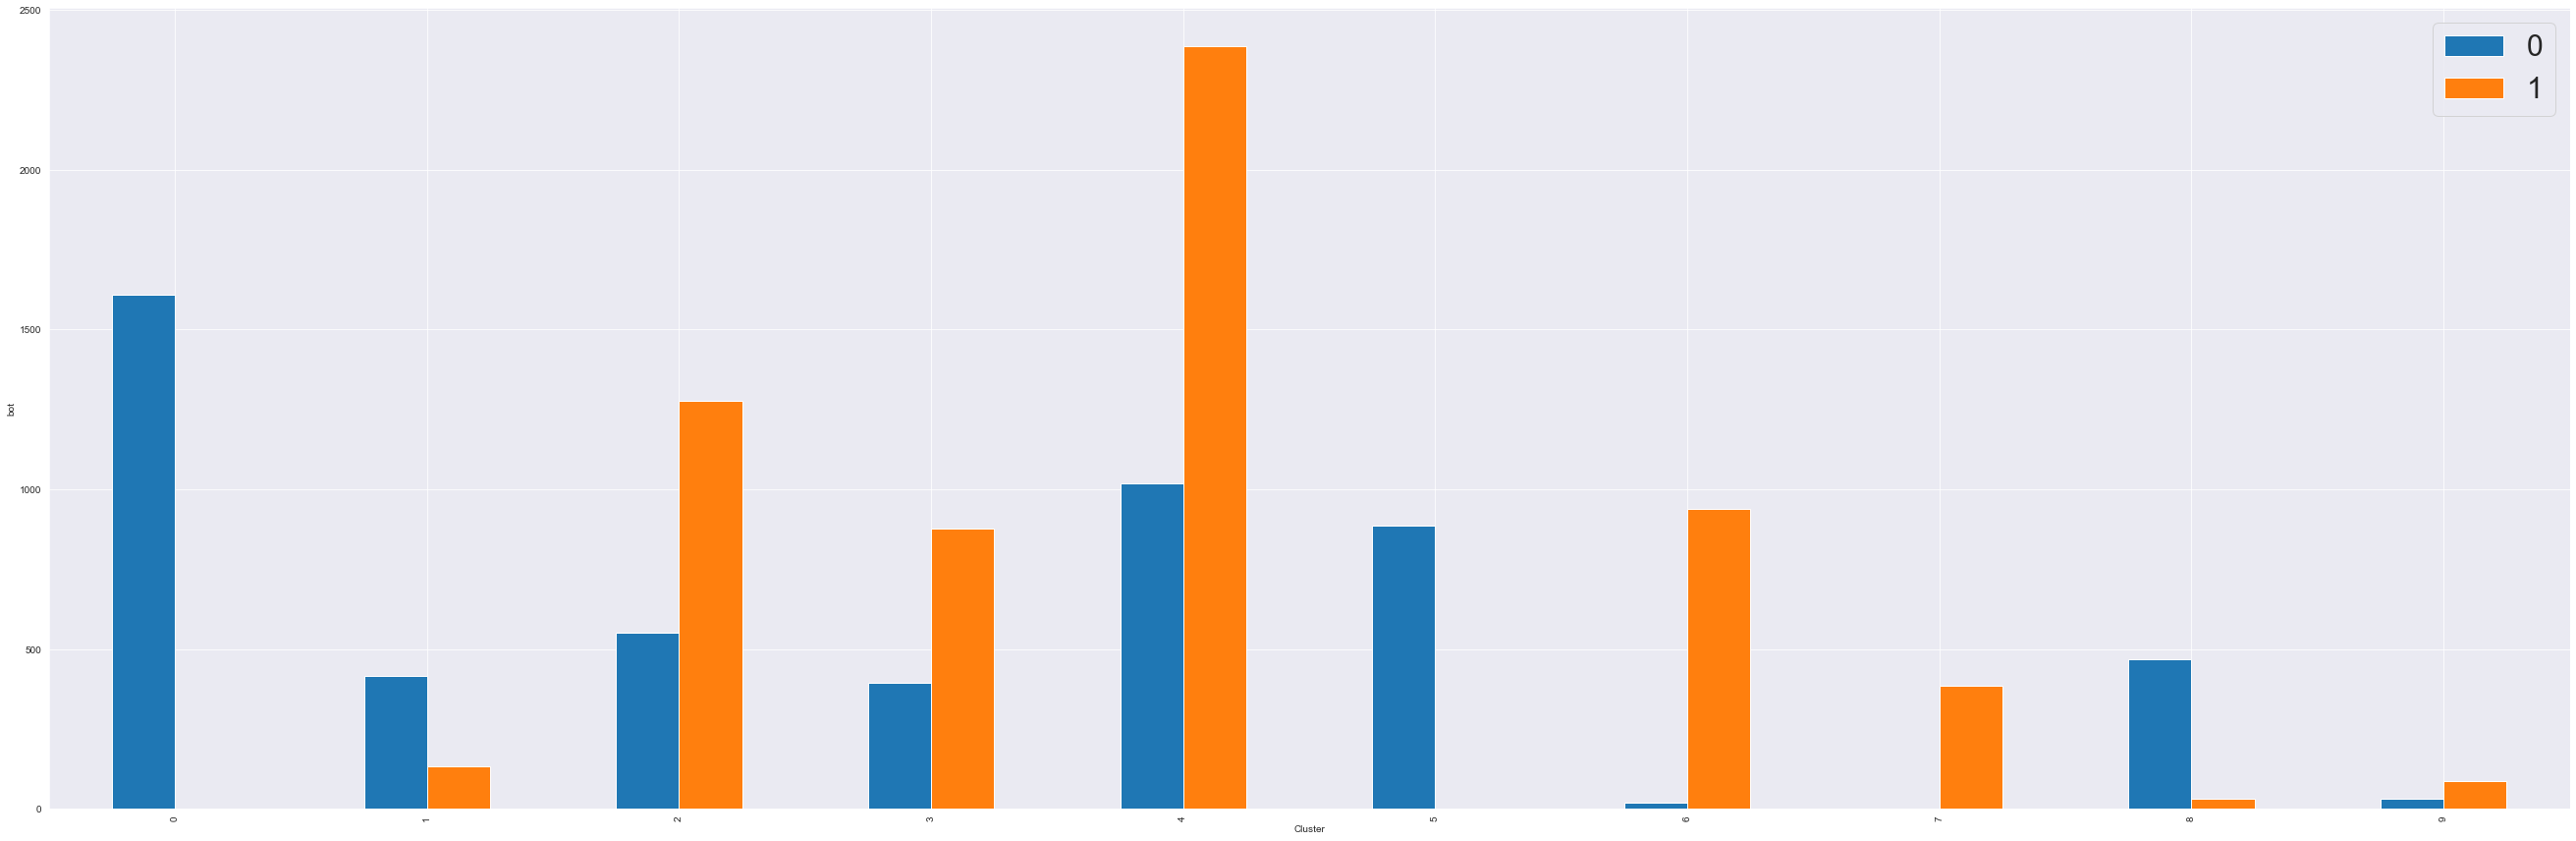

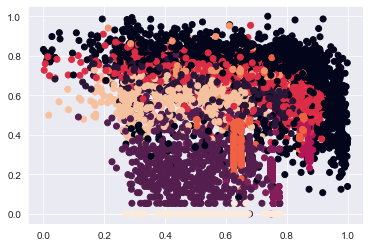

In [221]:
agglomerative_analysis(df_merge_scaled,10)

Silouhette score: 0.4045097351737031
Davies Bouldin score: 1.3371587748115306


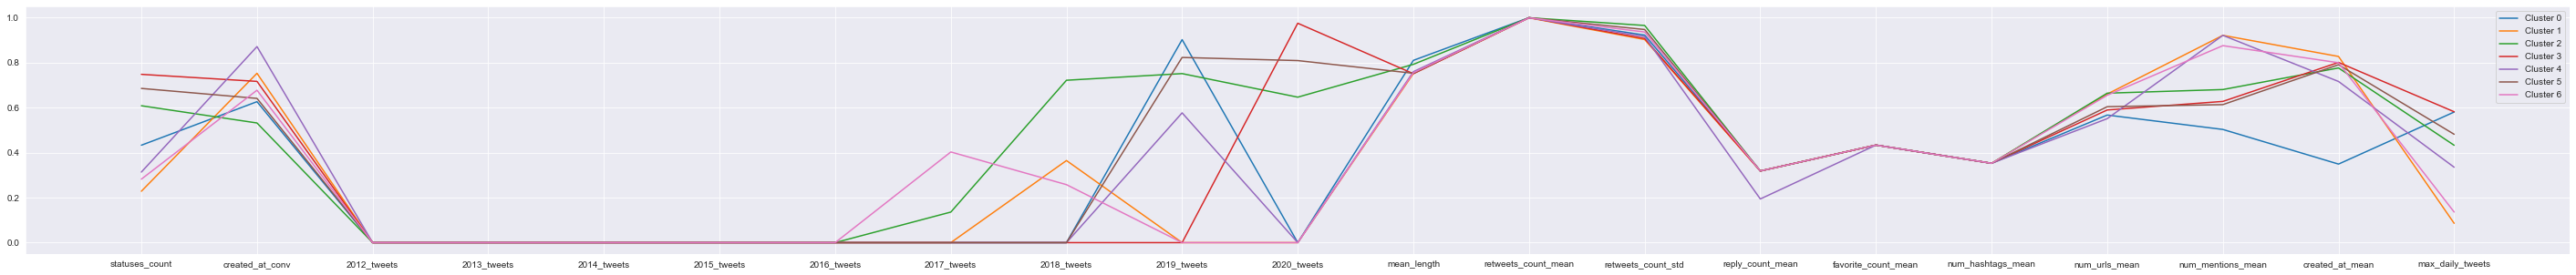

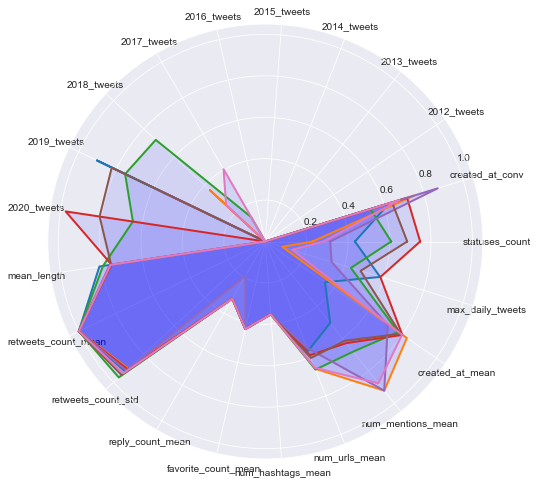

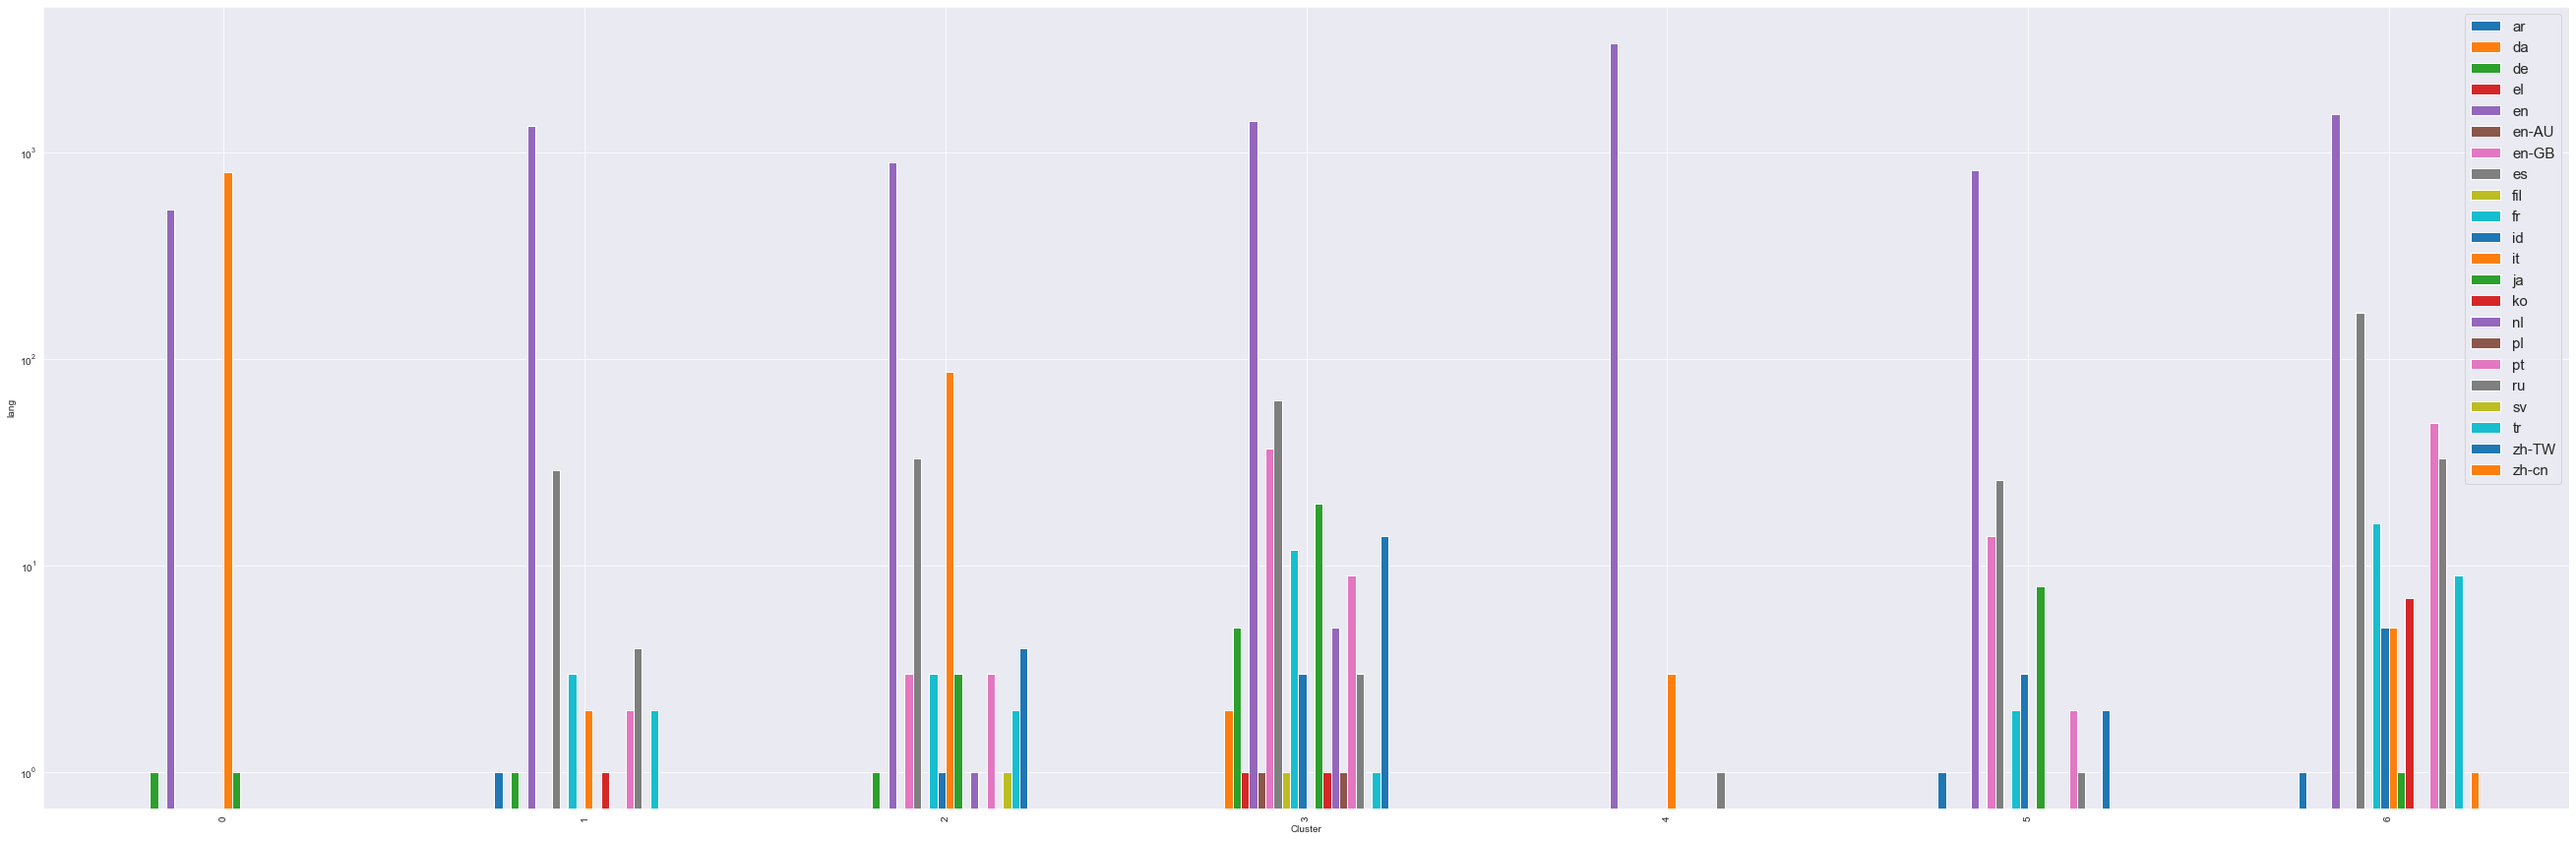

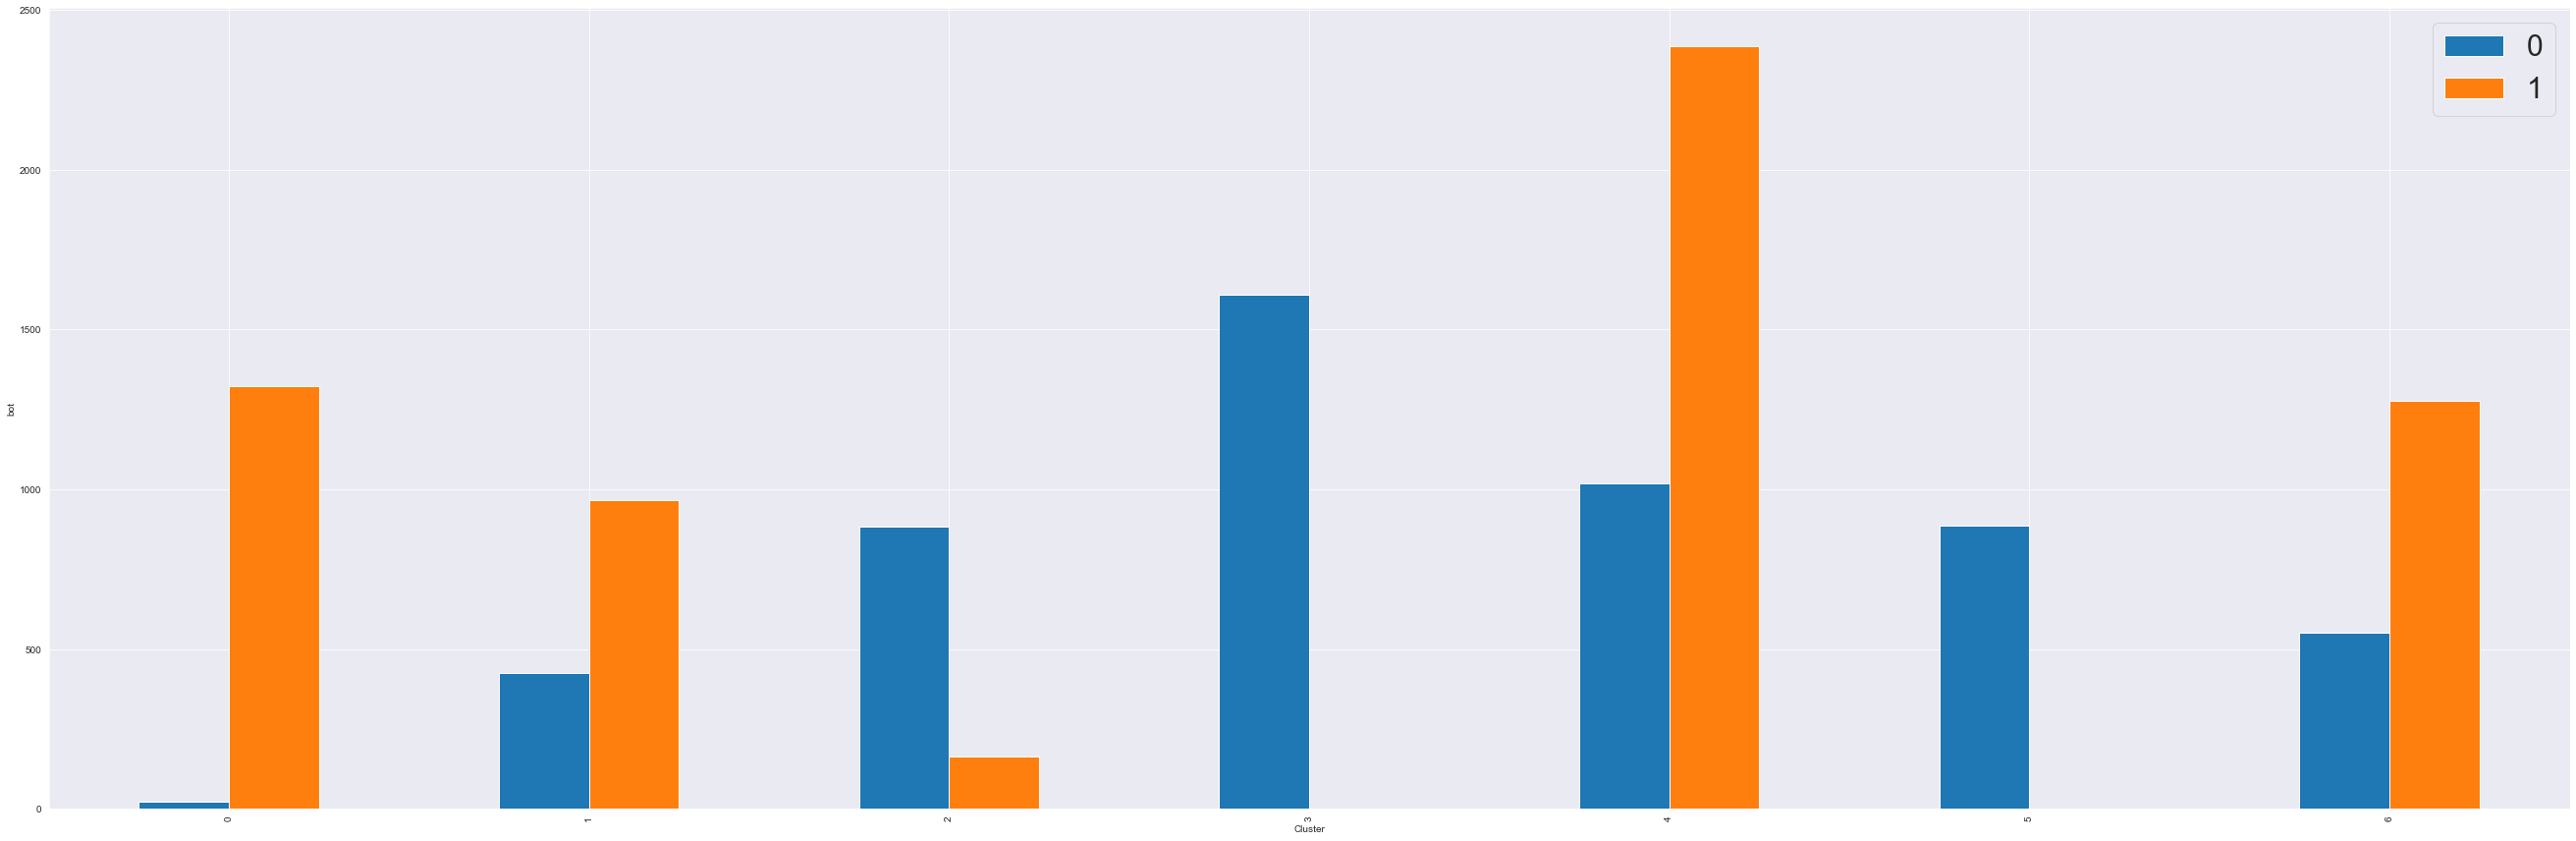

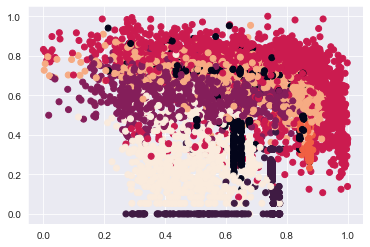

In [231]:
agglomerative_analysis(df_denoised,7)

# X-Means

from https://github.com/annoviko/pyclustering/

In [55]:
try:
  os.mkdir('xmeans')
except:
  pass

In [56]:

from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

k_start = 2
clusters_start = kmeans_plusplus_initializer(df_merge_scaled[numeric_attributes], 2).initialize()
 
# By defeault max # of clusters is 20, but we set it to 10
x_means = xmeans(df_merge_scaled[numeric_attributes], clusters_start, kmax=10, repeat=300) #, initial_centers, 20)
x_means.process()
 
# Extract clustering results: clusters and their centers
clusters = x_means.get_clusters()
centroids = x_means.get_centers()

print(f'Number of clusters found:', np.shape(centroids)[0])

Number of clusters found: 10


In [57]:
cluster_labels = dict()

''' 
Since for each cluster is saved the index in list of data
it is needed to convert it in such a way that
we have a list as long as the data, and in each
position it is saved the corresponding label for the
data with that index
'''
for label in range(0, np.shape(clusters)[0]):
  for i in range(0, len(clusters[label])):
    cluster_labels[clusters[label][i]] = label

cluster_labels = dict(sorted(cluster_labels.items()))

C:\Users\al\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [58]:
print("SSE:", x_means.get_total_wce())
get_metrics(df_merge_scaled[numeric_attributes], list(cluster_labels.values()))

SSE: 1803.7458298969798
Silouhette score: 0.4299258800185219
Davies Bouldin score: 1.146937973068482


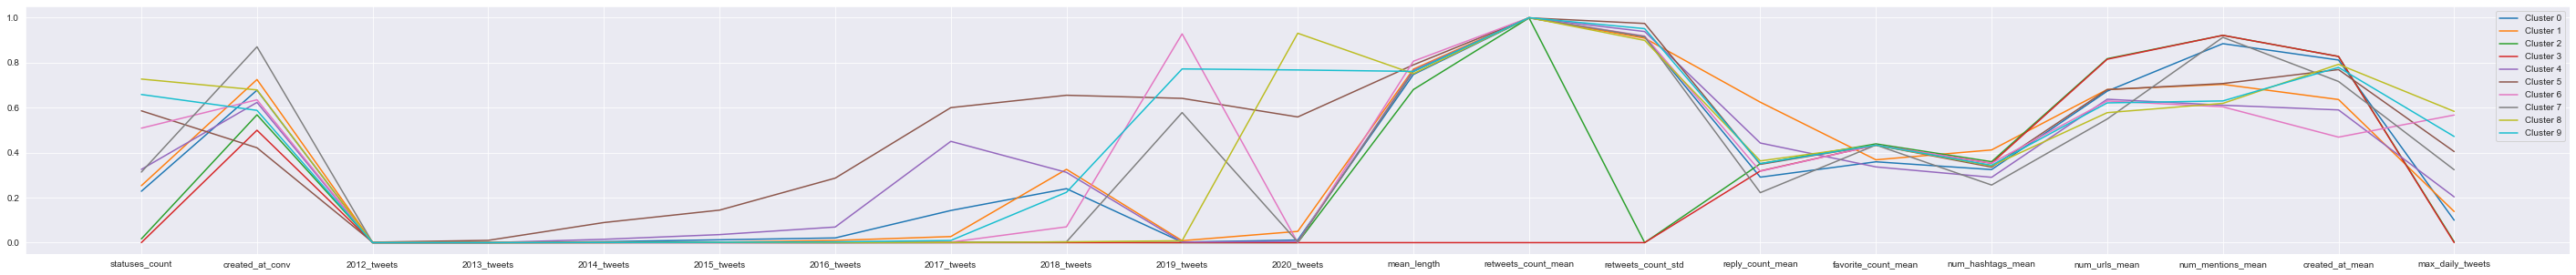

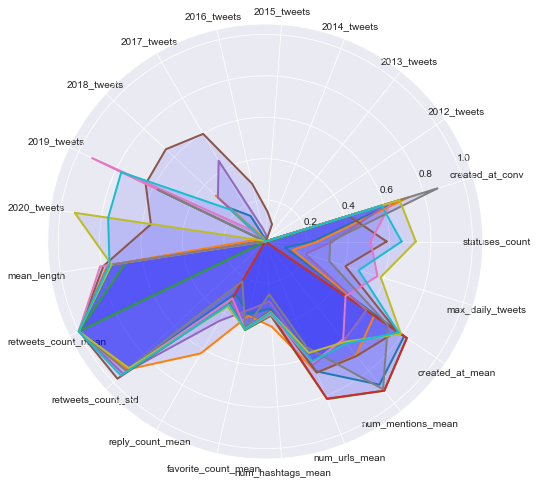

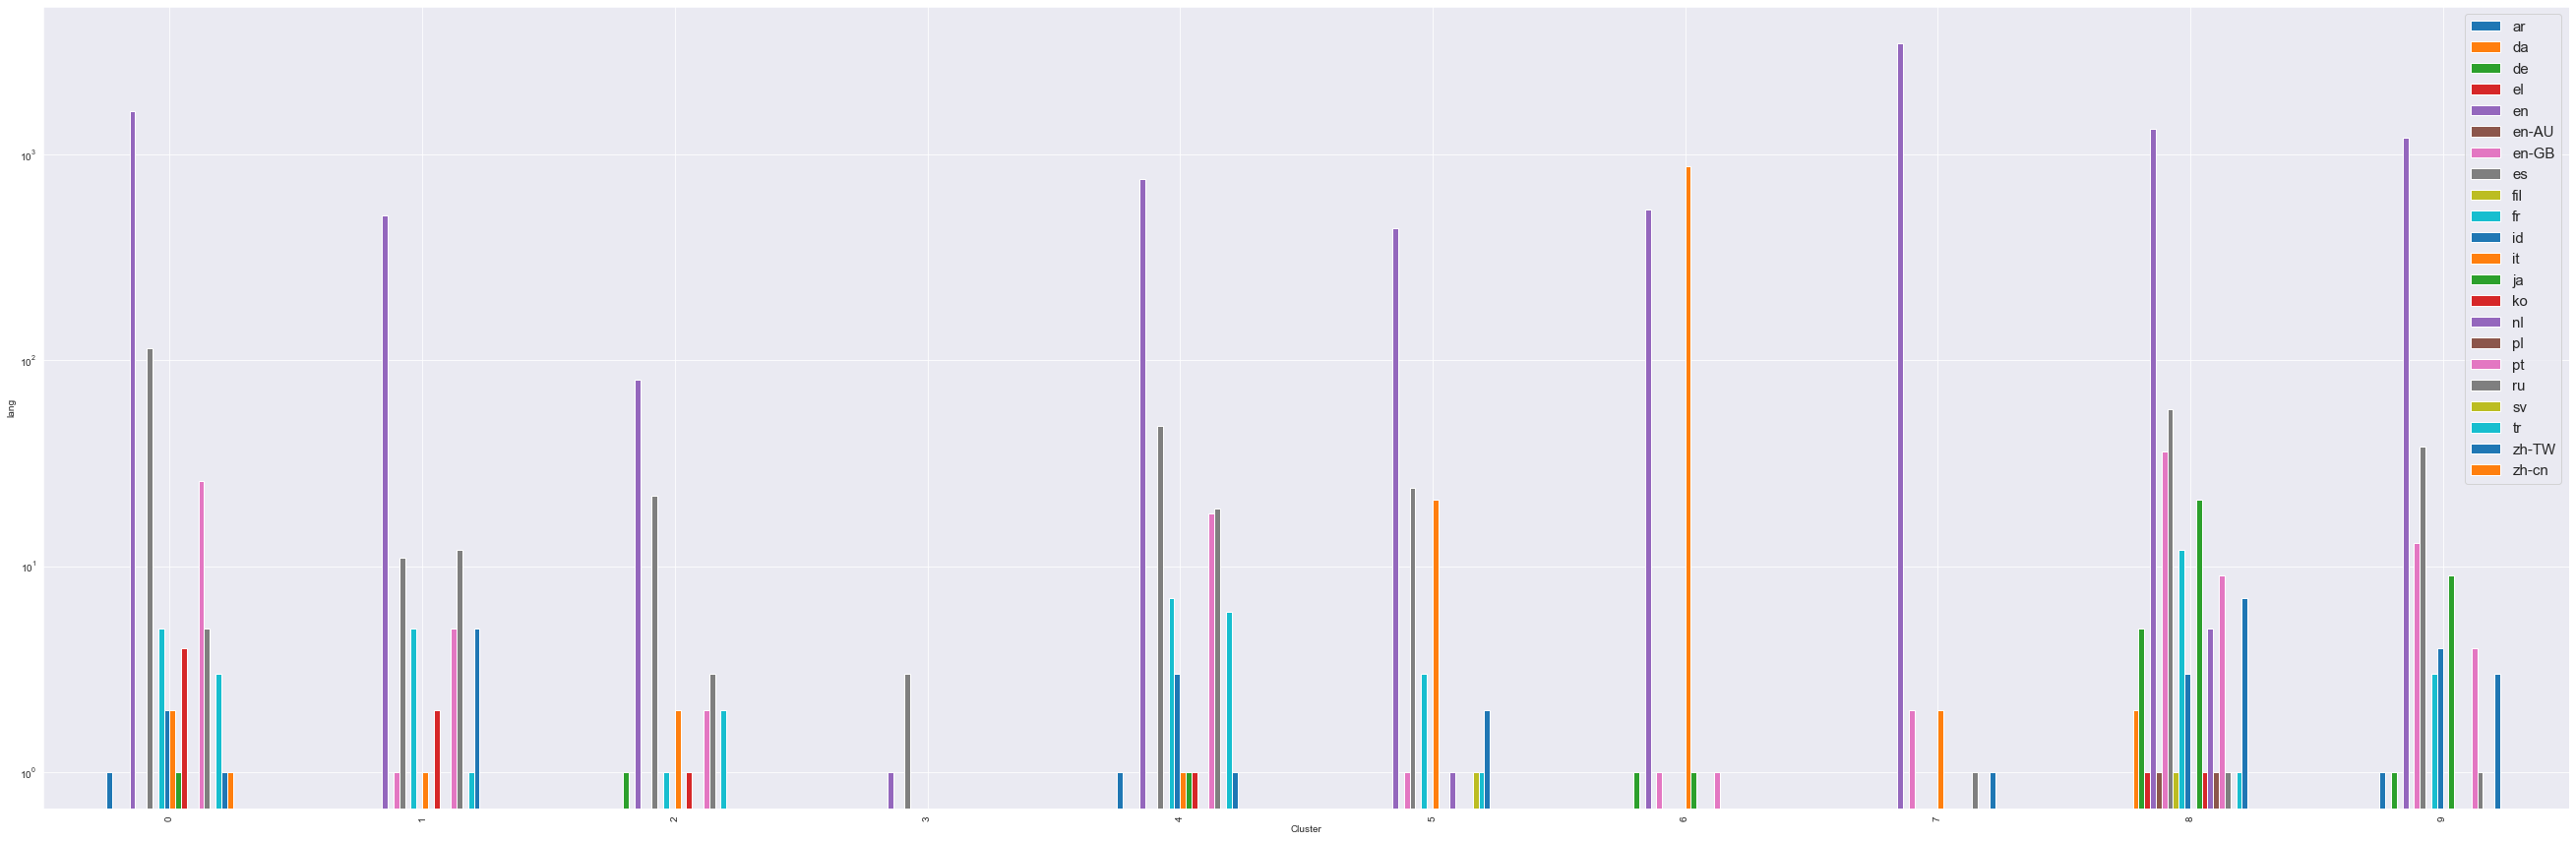

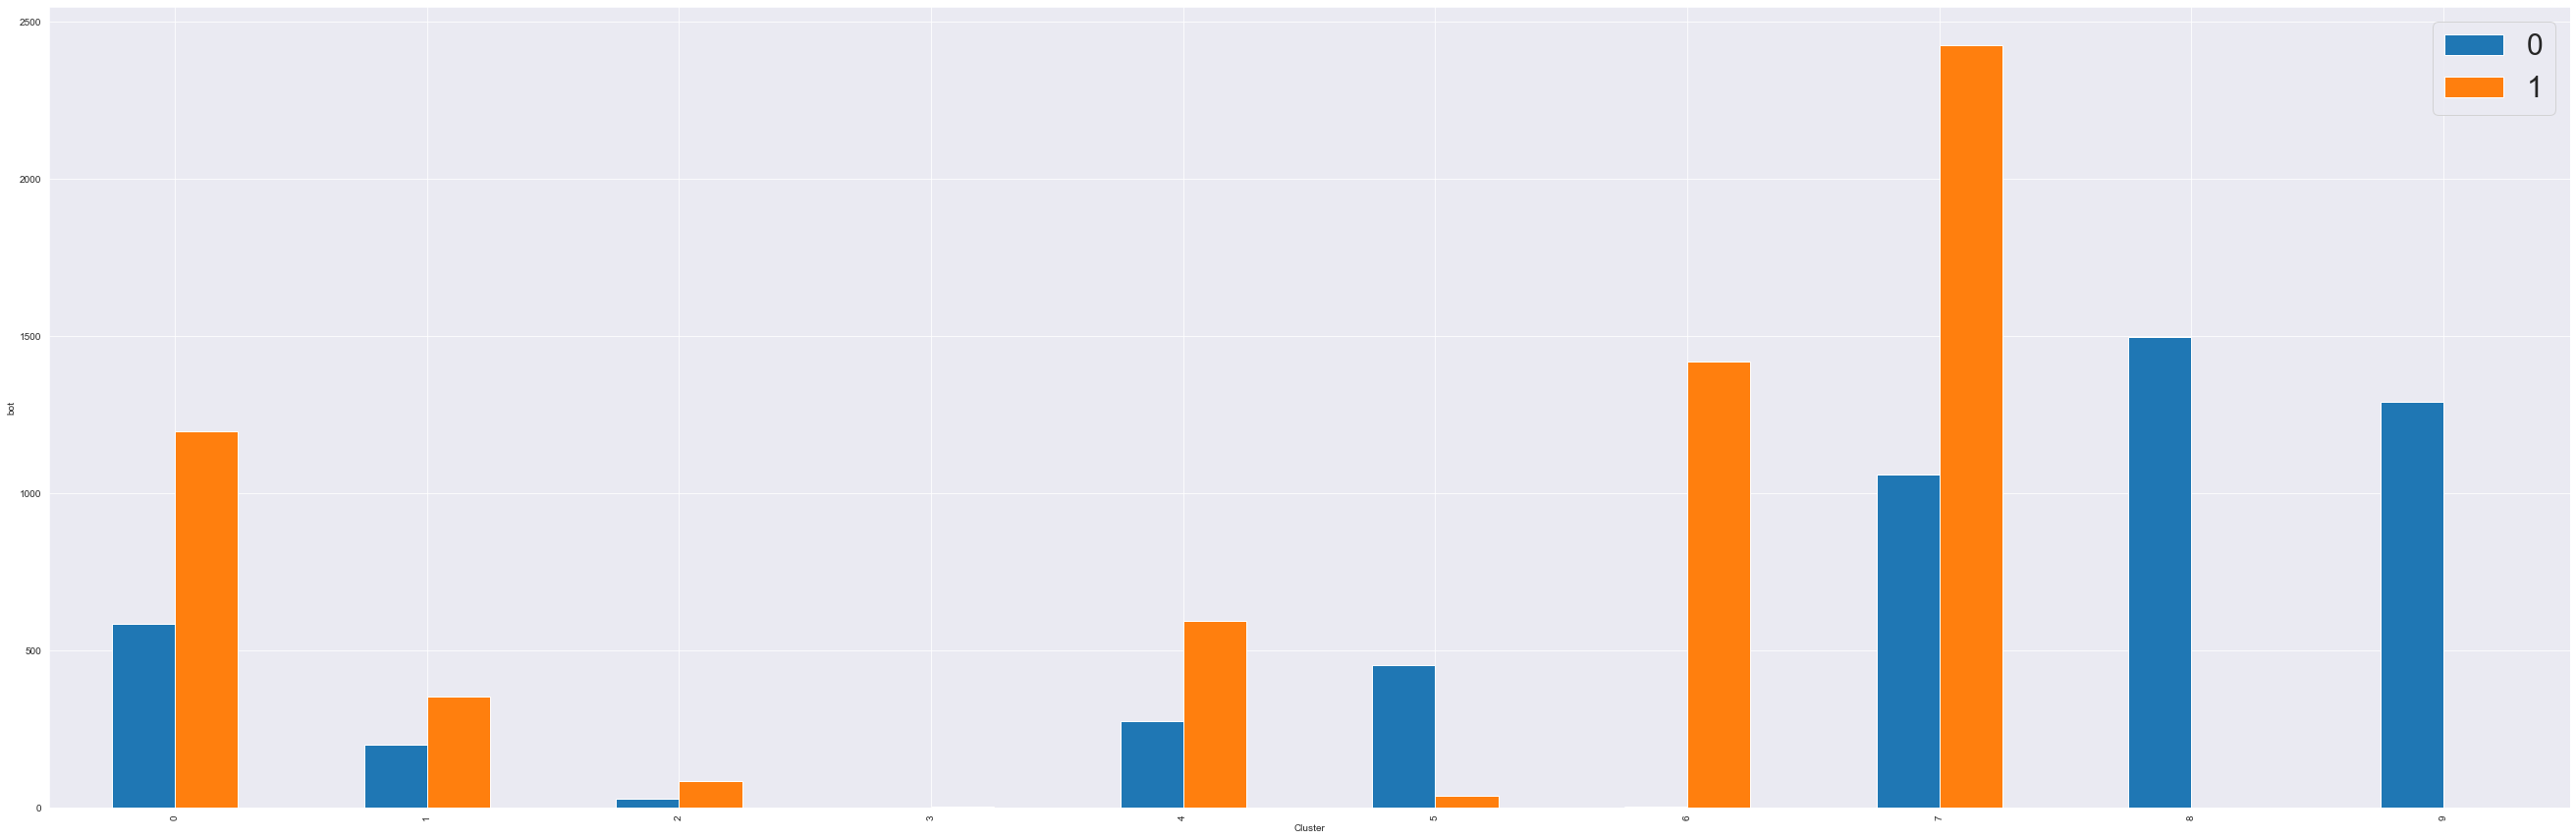

In [59]:
plots(df_merge_scaled, np.array(list(cluster_labels.values())), path='xmeans', centroids=np.array(centroids), attributes = numeric_attributes)